# Studying Biological Diversity

## Getting started: the sample by observation count/frequency table

From a bioinformatics perspective, studying biological diversity is centered around a few key pieces of information:

* A table of the counts (or relative abundances) of certain biological observations (e.g., species or OTUs) on a per sample basis.
* *Sample metadata* describing exactly what each of the samples is, as well as any relevant technical information. 
* Optionally, information on the relationships between the biological observations, typically in the form of a phylogenetic tree where tips in the tree correspond to OTUs in the table.

None of these are trival to generate (defining OTUs was described in the [OTU clustering chapter](../algorithms/5-sequence-mapping-and-clustering.ipynb), building trees in the [Phylogenetic reconstruction chapter](../algorithms/3-phylogeny-reconstruction.ipynb), and there is a lot of active work on standardized ways to describe samples in the form of metadata, for example [Yilmaz et al (2011)](http://www.nature.com/nbt/journal/v29/n5/full/nbt.1823.html) and the [isa-tab](http://isa-tools.org/) project. For this discussion we're going to largely ignore the complexities of generating each of these, so we can focus on how we study diversity.

<hr> 

The sample by observation count table is central to investigations of biological diversity. The Genomics Standards Consortium has recognized the [Biological Observation Matrix](http://www.biom-format.org) ([McDonald et al. (2011) *Gigascience*](http://www.gigasciencejournal.com/content/1/1/7)), or `biom-format` software and file format definition as a community standard for representing those tables. We'll use the `biom-format` python package here to work with these tables, and we'll refer to these tables through-out this chapter as *BIOM tables*.

The basic data that goes into a BIOM table is the list of sample ids, the list of observation (e.g., OTU) ids, and the count matrix, which describes how many times each OTU was observed in each sample. We can build and display a BIOM table as follows:

In [1]:
%pylab inline

from biom.table import table_factory, SparseOTUTable
from numpy import array

sample_ids = ['A', 'B', 'C']
observation_ids = ['OTU1', 'OTU2', 'OTU3', 'OTU4', 'OTU5']
data = array([[1, 0, 0],
              [3, 2, 0],
              [0, 0, 6],
              [1, 4, 2],
              [0, 4, 1]])

table1 = table_factory(data,
                  sample_ids,
                  observation_ids,
                  sample_md = [],
                  observation_md = [],
                  constructor=SparseOTUTable)

print table1

Populating the interactive namespace from numpy and matplotlib
# Constructed from biom file
#OTU ID	A	B	C
OTU1	1.0	0.0	0.0
OTU2	3.0	2.0	0.0
OTU3	0.0	0.0	6.0
OTU4	1.0	4.0	2.0
OTU5	0.0	4.0	1.0


The [biom-format API documentation](http://biom-format.org/documentation/table_objects.html) describes the functionality available for working with these tables once they're loaded. For example, if we want the observation count vector for sample `A` from the above table, we could get that as follows:

In [2]:
table1.sampleData('A')

array([ 1.,  3.,  0.,  1.,  0.])

**TODO**: Trees in newick format; sample metadata in tsv format, and loaded into a pandas DataFrame.

Before we start looking at what we can do with this data once we have it, let's discuss some terminology.

## Terminology

There are literally hundreds of metrics of biological diversity. Here is some terminology that is useful for classifying these metrics. 

**Alpha versus beta diversity**

 * $\alpha$ (i.e., within sample) diversity: Who is there? How many are there? 
 * $\beta$ (i.e., between sample) diversity: How similar are pairs of samples?    

**Quantitative versus qualitative metrics**

 * qualitative metrices only account for whether an organism is present or absent
 * quantitative metrics account for abundance 

**Phylogenetic versus non-phylogenetic metrics**

 * non-phylogenetic metrics treat all OTUs as being equally related
 * phylogenetic metrics incorporate evolutionary relationships between the OTUs


In the next sections we'll look at some metrics that cross these different categories. As new metrics are introduced, try to classify each them into one class for each of the above three categories.

## Measuring alpha diversity

The first type of metric that we'll look at will be alpha diversity, and we'll specifically focus on *richness* here. Richness refers to how many different *types* of organisms are present in a sample: for example, if we're interested in species richness of plants in the Sonoran Desert and the Costa Rican rainforest, we could go to each, count the number of different species of plants that we observe, and have a basic measure of species richness in each environment. 

An alternative type of alpha diversity measure would be *evenness*, and would tell us how even or uneven the distribution of species abundances are in a given environment. If, for example, the most abundant plant in the Sonoran desert was roughly as common as the least abundant plant (not the case!), we would say that the evenness of plant species was high. On the other hand, if the most abundant plant was thousands of times more common than the least common plant (probably closer to the truth), then we'd say that the evenness of plant species was low. We won't discuss evenness more here, but you can find coverage of this topic (as well as many of the others presented here) in [Measuring Biological Diversity](http://www.amazon.com/Measuring-Biological-Diversity-Anne-Magurran/dp/0632056339).

Let's look at two metrics of alpha diversity: observed species, and phylogenetic diversity.

#### Observed species (or Observed OTUs)

Observed species, or Observed OTUs as it's more accurately described, is about as simple of a metric as can be used to quantify alpha diversity. With this metric, we simply count the OTUs that are observed in a given sample. Note that this is a qualitative metric: we treat each OTU as being observed or not observed - we don't care how many times it was observed.

Let's define a new table for this analysis:

In [3]:
sample_ids = ['A', 'B', 'C']
observation_ids = ['B1','B2','B3','B4','B5','A1','E2']
data = array([[1, 1, 5],
              [1, 2, 0],
              [3, 1, 0],
              [0, 2, 0],
              [0, 0, 0],
              [0, 0, 3],
              [0, 0, 1]])

table2 = table_factory(data,
                  sample_ids,
                  observation_ids,
                  sample_md = [],
                  observation_md = [],
                  constructor=SparseOTUTable)

print table2

# Constructed from biom file
#OTU ID	A	B	C
B1	1.0	1.0	5.0
B2	1.0	2.0	0.0
B3	3.0	1.0	0.0
B4	0.0	2.0	0.0
B5	0.0	0.0	0.0
A1	0.0	0.0	3.0
E2	0.0	0.0	1.0


Our sample $A$ has an observed OTU count value of 3, sample $B$ has an observed OTU count of 4, and sample $C$ has an observed OTU count of 3. Note that this is different than the total counts for each column (which would be 5, 6, and 9 respectively). Based on the observed OTUs metric, we could consider samples $A$ and $C$ to have even OTU richness, and sample $B$ to have 33% higher OTU richness.

We could compute this in python as follows:

In [4]:
def observed_otus(table, sample_id):
    return sum([e > 0 for e in table.sampleData(sample_id)])

In [5]:
print observed_otus(table2, 'A')

3


In [6]:
print observed_otus(table2, 'B')

4


In [7]:
print observed_otus(table2, 'C')

3


#### A limitation of OTU counting

Imagine now that we have the same table, but some additional information about the OTUs in the table. Specifically, we've computed the following phylogenetic tree. And, for the sake of illustration, imagine that we've also assigned taxonomy to each of the OTUs and found that our samples contain representatives from the archaea, bacteria, and eukaryotes (their labels begin with `A`, `B`, and `E`, respectively).

<img src="files/images/pd_calc_tree.png">

Pairing this with the table we defined above (displayed again in the cell below), given what you now now about these OTUs, which would you consider the most diverse? Are you happy with the $\alpha$ diversity conclusion that you obtained when computing the number of observed OTUs in each sample?

In [8]:
print table2

# Constructed from biom file
#OTU ID	A	B	C
B1	1.0	1.0	5.0
B2	1.0	2.0	0.0
B3	3.0	1.0	0.0
B4	0.0	2.0	0.0
B5	0.0	0.0	0.0
A1	0.0	0.0	3.0
E2	0.0	0.0	1.0


#### Phylogenetic Diversity (PD)

Phylogenetic Diversity (PD) is a metric that was developed by Dan Faith in the early 1990s (find the original paper [here](http://www.sciencedirect.com/science/article/pii/0006320792912013)). Like many of the measures that are used in microbial community ecology, it wasn't initially designed for studying microbial communities, but rather communities of "macro-organisms" (macrobes?). Some of these metrics, including PD, do translate well to microbial community analysis, while some don't translate as well. (For an illustration of the effect of sequencing error on PD, where it is handled well, versus it's effect on the Chao1 metric, where it is handled less well, see Figure 1 of [Reeder and Knight (2010)](http://www.nature.com/nmeth/journal/v7/n9/full/nmeth0910-668b.html)).

PD is relatively simple to calculate. It is computed simply as the sum of the branch length in a phylogenetic tree that is "covered" or represented in a given sample. Let's look at an example to see how this works.

First, let's define a phylogenetic tree using the newick format (which is described [here](http://evolution.genetics.washington.edu/phylip/newicktree.html), and more formally defined [here](http://evolution.genetics.washington.edu/phylip/newick_doc.html)). We'll then load that up with using [scikit-bio](http://scikit-bio.org)'s [TreeNode](http://scikit-bio.org/generated/skbio.core.tree.TreeNode.html#skbio.core.tree.TreeNode) object.

In [9]:
newick_tree = '(((B1:0.2,B2:0.3):0.3,((B3:0.5,B4:0.3):0.2,B5:0.9):0.3):0.35,(((A1:0.2,A2:0.3):0.3,(E1:0.3,E2:0.4):0.7):0.2):0.05)root;'

from skbio.tree import TreeNode

tree = TreeNode.from_newick(newick_tree)
tree = tree.root_at_midpoint()

I'll now define a couple of functions that we'll use to compute PD. 

In [10]:
def get_observed_nodes(tree, table, sample_id, verbose=False):
    observed_otus = [obs_id for obs_id in table.ObservationIds 
                if table.getValueByIds(obs_id, sample_id) > 0]
    observed_nodes = set()
    # iterate over the observed OTUs
    for otu in observed_otus:
        t = tree.find(otu)
        observed_nodes.add(t)
        if verbose:
            print t.name, t.length, 
        for internal_node in t.ancestors():
            if internal_node.length is None:
                # we've hit the root
                if verbose:
                    print
            else:
                if verbose and internal_node not in observed_nodes:
                    print internal_node.length,
                observed_nodes.add(internal_node)
    return observed_nodes

def phylogenetic_diversity(tree, table, sample_id, verbose=False):
    observed_nodes = get_observed_nodes(tree, table, sample_id, verbose=verbose)
    pd = sum(o.length for o in observed_nodes)
    return pd

And then apply those to compute the PD of our three samples. For each computation, we're also printing out the branch lengths of the branches that are observed *for the first time* when looking at a given OTU. When computing PD, we include the length of each branch only one time.

In [11]:
pd_A = phylogenetic_diversity(tree, table2, 'A', verbose=True)
print pd_A

B1 0.2 0.3 0.25
B2 0.3
B3 0.5 0.2 0.3
2.05


In [12]:
pd_B = phylogenetic_diversity(tree, table2, 'B', verbose=True)
print pd_B

B1 0.2 0.3 0.25
B2 0.3
B3 0.5 0.2 0.3
B4 0.3
2.35


In [13]:
pd_C = phylogenetic_diversity(tree, table2, 'C', verbose=True)
print pd_C

B1 0.2 0.3 0.25
A1 0.2 0.3 0.2 0.05 0.1
E2 0.4 0.7
2.7


How does this result compare to what we observed above with the Observed OTUs metric? Based on your knowledge of biology, which do you think is a better representation of the relative diversities of these samples?

#### Even sampling

Imagine again that we're going out to count plants in the Sonoran Desert and the Costa Rican rainforest. We're interested in getting an idea of the plant richness in each environment. In the Sonoran Desert, we survey a square kilometer area, and count 150 species of plants. In the rainforest, we survey a square meter, and count 15 species of plants. So, clearly the plant species richness in the Sonoran Desert is higher, right? What's wrong with this comparison?

The problem is that we've expended a lot more sampling effort in the desert than we did in the rainforest, so it shouldn't be surprising that we observed more species there. If we expended the same effort in the rainforest, we'd probably observe a lot more than 15 or 150 plant species, and we'd have a more sound comparison.

In sequencing-based studies of microorganism richness, the analog of sampling area is sequencing depth. If we collect 100 sequences from one sample, and 10,000 sequences from another sample, we can't directly compare the number of observed OTUs or the phylogenetic diversity of these because we expended a lot more sampling effort on the sample with 10,000 sequences than on the sample with 100 sequences. The way this is typically handled is by randomly subsampling sequences from the sample with more sequences until the sequencing depth is equal to that in the sample with fewer sequences. If we randomly select 100 sequences at random from the sample with 10,000 sequences, and compute the alpha diversity based on that random subsample, we'll have a better idea of the relative alpha diversities of the two samples.

In [14]:
sample_ids = ['A', 'B', 'C']
observation_ids = ['OTU1', 'OTU2', 'OTU3', 'OTU4', 'OTU5']
data = array([[50, 4, 0],
              [35, 200, 0],
              [100, 2, 1],
              [15, 400, 1],
              [0, 40, 1]])

bad_table = table_factory(data,
                  sample_ids,
                  observation_ids,
                  sample_md = [],
                  observation_md = [],
                  constructor=SparseOTUTable)

print bad_table

# Constructed from biom file
#OTU ID	A	B	C
OTU1	50.0	4.0	0.0
OTU2	35.0	200.0	0.0
OTU3	100.0	2.0	1.0
OTU4	15.0	400.0	1.0
OTU5	0.0	40.0	1.0


In [15]:
print observed_otus(bad_table, 'A')

4


In [16]:
print observed_otus(bad_table, 'B')

5


In [17]:
print observed_otus(bad_table, 'C')

3


In [18]:
print zip(bad_table.SampleIds, bad_table.sum('sample'))

[('A', 200.0), ('B', 646.0), ('C', 3.0)]


**TODO**: Add alpha rarefaction discussion.

## Measuring beta diversity

$\beta$-diversity (canonically pronounced *beta diversity*) refers to **between sample diversity**, and is typically used to answer questions of the form: is sample $A$ more similar in composition to sample $B$ or sample $C$? In this section we'll explore two (of tens or hundreds) of metrics for computing pairwise dissimilarity of samples to estimate $\beta$ diversity.

### Distance metrics

#### Bray-Curtis

The first metric that we'll look at is a quantitative non-phylogenetic $\beta$ diversity metric called Bray-Curtis. The Bray-Curtis dissimilarity between a pair of samples, $j$ and $k$, is defined as follows:

$BC_{jk} = \frac{ \sum_{i} | X_{ij} – X_{ik}|} {\sum_{i} (X_{ij} + X_{ik})}$

$i$ : observation (e.g., OTUs)

$X_{ij}$ : count of observation $i$ in sample $j$

$X_{ik}$ : count of observation $i$ in sample $k$

This could be implemented in python as follows:


In [19]:
def bray_curtis_distance(table, sample1_id, sample2_id):
    numerator = 0
    denominator = 0
    sample1_counts = table.sampleData(sample1_id)
    sample2_counts = table.sampleData(sample2_id)
    for sample1_count, sample2_count in zip(sample1_counts, sample2_counts):
        numerator += abs(sample1_count - sample2_count)
        denominator += sample1_count + sample2_count
    return numerator / denominator

In [20]:
print table1

# Constructed from biom file
#OTU ID	A	B	C
OTU1	1.0	0.0	0.0
OTU2	3.0	2.0	0.0
OTU3	0.0	0.0	6.0
OTU4	1.0	4.0	2.0
OTU5	0.0	4.0	1.0


Let's now apply this to some pairs of samples:

In [21]:
print bray_curtis_distance(table1, 'A', 'B')

0.6


In [22]:
print bray_curtis_distance(table1, 'A', 'C')

0.857142857143


In [23]:
print bray_curtis_distance(table1, 'B', 'C')

0.684210526316


In [24]:
print bray_curtis_distance(table1, 'A', 'A')

0.0


In [25]:
print bray_curtis_distance(table1, 'C', 'B')

0.684210526316


Ultimately, we likely want to apply this to all pairs of samples to get a distance matrix containing all pairwise distances. Let's define a function for that, and then compute all pairwise Bray-Curtis distances between samples `A`, `B` and `C`.

In [26]:
from skbio.stats.distance import DistanceMatrix
from numpy import zeros

def table_to_distances(table, pairwise_distance_fn):
    sample_ids = table.SampleIds
    num_samples = len(sample_ids)
    data = zeros((num_samples, num_samples))
    for i, sample1_id in enumerate(sample_ids):
        for j, sample2_id in enumerate(sample_ids[:i]):
            data[i,j] = data[j,i] = \
             pairwise_distance_fn(table, sample1_id, sample2_id)
    return DistanceMatrix(data, sample_ids)

In [27]:
bc_dm = table_to_distances(table1, bray_curtis_distance)
print bc_dm

3x3 distance matrix
IDs:
'A', 'B', 'C'
Data:
[[ 0.          0.6         0.85714286]
 [ 0.6         0.          0.68421053]
 [ 0.85714286  0.68421053  0.        ]]


#### Unweighted UniFrac

Just as phylogenetic alpha diversity metrics can be more informative than non-phylogenetic alpha diversity metrics, phylogenetic beta diversity metrics offer advantages over non-phylogenetic metrics such as Bray-Curtis. The most widely applied phylogenetic beta diversity metric as of this writing is unweighted UniFrac. UniFrac was initially presented in [Lozupone and Knight, 2005, Applied and Environmental Microbiology](http://aem.asm.org/content/71/12/8228.abstract), and has been widely applied in microbial ecology since (and the illustration of UniFrac computation presented below is derived from a similar example originally developed by Lozupone and Knight).

The unweighted UniFrac distance between a pair of samples `A` and `B` is defined as follows:

$U_{AB} = \frac{unique}{observed}$

where:

$unique$ : the unique branch length, or branch length that only leads to OTU(s) observed in sample $A$ or sample $B$

$observed$ : the total branch length observed in either sample $A$ or sample $B$

<div style="float: right; margin-left: 30px;"><img title="Image by @gregcaporaso." style="float: right; margin-left: 30px;" src="files/images/unifrac_tree_d0.png" align=right/></div>

To illustrate how UniFrac distances are computed, before we get into actually computing them, let's look at a few examples. In these examples, imagine that we're determining the pairwise UniFrac distance between two samples: a red sample, and a blue sample. If a red box appears next to an OTU, that indicates that it's observed in the red sample; if a blue box appears next to the OTU, that indicates that it's observed in the blue sample; if a red and blue box appears next to the OTU, that indicates that the OTU is present in both samples; and if no box is presented next to the OTU, that indicates that it's present in neither sample.

To compute the UniFrac distance between a pair of samples, we need to know the sum of the branch length that was observed in either sample (the *observed* branch length), and the sum of the branch length that was observed only in a single sample (the *unique* branch length). In these examples, we color all of the *observed* branch length. Branch length that is unique to the red sample is red, branch length that is unique to the blue sample is blue, and branch length that is observed in both samples is purple. Unobserved branch length is black (as is the vertical branches, as those don't contribute to branch length - they are purely for visual presentation). 

In the tree on the right, all of the OTUs that are observed in either sample are observed in both samples. As a result, all of the observed branch length is purple. The unique branch length in this case is zero, so **we have a UniFrac distance of 0 between the red and blue samples**.

<hr>

<div style="float: right; margin-left: 30px;"><img title="Image by @gregcaporaso." style="float: right; margin-left: 30px;" src="files/images/unifrac_tree_d1.png" align=right/></div>

On the other end of the spectrum, in the second tree, all of the OTUs in the tree are observed either in the red sample, or in the blue sample. All of the observed branch length in the tree is either red or blue, meaning that if you follow a branch out to the tips, you will observed only red or blue samples. In this case the unique branch length is equal to the observed branch length, so **we have a UniFrac distance of 1 between the red and blue samples**.


<hr>

<div style="float: right; margin-left: 30px;"><img title="Image by @gregcaporaso." style="float: right; margin-left: 30px;" src="files/images/unifrac_tree_d0.5.png" align=right/></div>

Finally, most of the time we're somewhere in the middle. In this tree, some of our branch length is unique, and some is not. For example, OTU 1 is only observed in our red sample, so the terminal branch leading to OTU 1 is red (i.e., unique to the red sample). OTU 2 is only observed in our blue sample, so the terminal branch leading to OTU 2 is blue (i.e., unique to the blue sample). However, the internal branch leading to the node connecting OTU 1 and OTU 2 leads to OTUs observed in both the red and blue samples (i.e., OTU 1 and OTU 2), so is purple (i.e, observed branch length, but not unique branch length). In this case, **we have an intermediate UniFrac distance between the red and blue samples, maybe somewhere around 0.5**.

<hr>
<div style="float: right; margin-left: 30px;"><img title="Image by @gregcaporaso." style="float: right; margin-left: 30px;" src="files/images/unifrac_tree_with_distances.png" align=right/></div>

Let's now compute the Unweighted UniFrac distances between some samples. Imagine we have the following tree, paired with our table below (printed below, for quick reference).

In [28]:
print table1

# Constructed from biom file
#OTU ID	A	B	C
OTU1	1.0	0.0	0.0
OTU2	3.0	2.0	0.0
OTU3	0.0	0.0	6.0
OTU4	1.0	4.0	2.0
OTU5	0.0	4.0	1.0


<div style="float: right; margin-left: 30px;"><img title="Image by @gregcaporaso." style="float: right; margin-left: 30px;" src="files/images/unifrac_tree_with_distances_ab.png" align=right/></div>

First, let's compute the unweighted UniFrac distance between samples $A$ and $B$. The *unweighted* in *unweighted UniFrac* means that this is a qualitative diversity metric, meaning that we don't care about the abundances of the OTUs, only whether they are present in a given sample ($count > 0$) or not present ($count = 0$). 

Start at the top right branch in the tree, and for each branch, determine if the branch is observed, and if so, if it is also unique. If it is observed then you add its length to your observed branch length. If it is observed and unique, then you also add its length to your unique branch length. 

For samples $A$ and $B$, I get the following (in the tree on the right, red branches are those observed in $A$, blue branches are those observed in $B$, and purple are observed in both):

$unique_{ab} = 0.5 + 0.75 = 1.25$

$observed_{ab} = 0.5 + 0.5 + 0.5 + 1.0 + 1.25 + 0.75 + 0.75 = 5.25$

$uu_{ab} = \frac{unique_{ab}}{observed_{ab}} = \frac{1.25}{5.25} = 0.238$

As an exercise, now compute the UniFrac distances between samples $B$ and $C$, and samples $A$ and $C$, using the above table and tree. When I do this, I get the following distance matrix. 

In [29]:
ids = ['A', 'B', 'C']
d = [[0.00, 0.24, 0.52],
      [0.24, 0.00, 0.35],
      [0.52, 0.35, 0.00]]
print DistanceMatrix(d, ids)

3x3 distance matrix
IDs:
'A', 'B', 'C'
Data:
[[ 0.    0.24  0.52]
 [ 0.24  0.    0.35]
 [ 0.52  0.35  0.  ]]


 **TODO**: Interface change so this code can be used with ``table_to_distances``. 

In [30]:
## This is untested!! I'm not certain that it's exactly right, just a quick test.

newick_tree1 = '(((((OTU1:0.5,OTU2:0.5):0.5,OTU3:1.0):1.0),(OTU4:0.75,OTU5:0.75):1.25))root;'
tree1 = TreeNode.from_newick(newick_tree1)

def unweighted_unifrac(tree, table, sample_id1, sample_id2, verbose=False):
    observed_nodes1 = get_observed_nodes(tree, table, sample_id1, verbose=verbose)
    observed_nodes2 = get_observed_nodes(tree, table, sample_id2, verbose=verbose)
    observed_branch_length = sum(o.length for o in observed_nodes1 | observed_nodes2)
    shared_branch_length = sum(o.length for o in observed_nodes1 & observed_nodes2)
    unique_branch_length = observed_branch_length - shared_branch_length
    unweighted_unifrac = unique_branch_length / observed_branch_length
    return unweighted_unifrac

print unweighted_unifrac(tree1, table1, 'A', 'B')
print unweighted_unifrac(tree1, table1, 'A', 'C')
print unweighted_unifrac(tree1, table1, 'B', 'C')

0.238095238095
0.52
0.347826086957


#### Even sampling

**TODO**: Add discussion on necessity of even sampling

### Interpreting distance matrices

In the previous section we computed distance matrices that contained the pairwise distances between a few samples. You can look at those distance matrices and get a pretty good feeling for what the patterns are. For example, what are the most similar samples? What are the most dissimilar samples? 

What if instead of three samples though, we had more. Here's a screenshot from a distance martix containing data on 105 samples (this is just the first few rows and columns):

<img src='files/images/example_big_dm.png'>

Do you have a good feeling for the patterns here? What are the most similar samples? What are the most dissimilar samples? 

Chances are, you can't just squint at that table and understand what's going on (but if you can, I'm hiring!). The problem is exacerbated by the fact that in modern microbial ecology studies we may have thousands or tens of thousands of samples, not "just" hundreds as in the table above. We need tools to help us take these raw distances and convert them into something that we can interpret. In this section we'll look at some techniques, one of which we've covered previously, that will help us interpret large distance matrices.

<hr>

One excellent paper that includes a comparison of several different strategies for interpreting beta diversity results is [Costello *et al.* Science (2009) Bacterial Community Variation in Human Body Habitats Across Space and Time](https://www.sciencemag.org/content/326/5960/1694.full). In this study, the authors collected microbiome samples from 7 human subjects at about 25 sites on their bodies, at four different timepoints. 

Figure 1 shows several different approaches for comparing the resulting UniFrac distance matrix (this image is linked from the *Science* journal website - copyright belongs to *Science*):

<img src="https://www.sciencemag.org/content/326/5960/1694/F1.large.jpg">

Let's generate a small distance matrix representing just a few of these body sites, and figure out how we'd generate and interpret each of these visualizations. The values in the distance matrix below are a subset of the unweighted UniFrac distance matrix representing two samples each from three body sites from the Costello *et al.* (2009) study.

In [31]:
sample_ids = ['A', 'B', 'C', 'D', 'E', 'F']

human_microbiome_sample_md = {
                   'A': {'body_habitat': 'gut', 'person': 'subject 1'},
                   'B': {'body_habitat': 'gut', 'person': 'subject 2'},
                   'C': {'body_habitat': 'tongue', 'person': 'subject 1'},
                   'D': {'body_habitat': 'tongue', 'person': 'subject 2'},
                   'E': {'body_habitat': 'skin', 'person': 'subject 1'},
                   'F': {'body_habitat': 'skin', 'person': 'subject 2'}}

dm_data = array([[0.00, 0.35, 0.83, 0.83, 0.90, 0.90],
                 [0.35, 0.00, 0.86, 0.85, 0.92, 0.91],
                 [0.83, 0.86, 0.00, 0.25, 0.88, 0.87],
                 [0.83, 0.85, 0.25, 0.00, 0.88, 0.88],
                 [0.90, 0.92, 0.88, 0.88, 0.00, 0.50],
                 [0.90, 0.91, 0.87, 0.88, 0.50, 0.00]])

human_microbiome_dm = DistanceMatrix(dm_data, sample_ids)
print human_microbiome_dm

6x6 distance matrix
IDs:
'A', 'B', 'C', 'D', 'E', 'F'
Data:
[[ 0.    0.35  0.83  0.83  0.9   0.9 ]
 [ 0.35  0.    0.86  0.85  0.92  0.91]
 [ 0.83  0.86  0.    0.25  0.88  0.87]
 [ 0.83  0.85  0.25  0.    0.88  0.88]
 [ 0.9   0.92  0.88  0.88  0.    0.5 ]
 [ 0.9   0.91  0.87  0.88  0.5   0.  ]]


#### Distribution plots and comparisons

First, let's look at the analysis presented in panels E and F. Instead of generating bar plots here, we'll generate box plots as these are more informative (i.e., they provide a more detailed summary of the distribution being investigated). One important thing to notice here is the central role that the sample metadata plays in the visualization. If we just had our sample ids (i.e., letters ``A`` through ``F``) we wouldn't be able to group distances into *within* and *between* sample type categories, and we therefore couldn't perform the comparisons we're interested in.

In [32]:
def within_between_category_distributions(dm, md, md_category):
    within_category_distances = []
    between_category_distances = []
    for i, sample_id1 in enumerate(dm.ids):
        sample_md1 = md[sample_id1][md_category]
        for sample_id2 in dm.ids[:i]:
            sample_md2 = md[sample_id2][md_category]
            if sample_md1 == sample_md2:
                within_category_distances.append(dm[sample_id1, sample_id2])
            else:
                between_category_distances.append(dm[sample_id1, sample_id2])
    return within_category_distances, between_category_distances

In [33]:
within_category_distances, between_category_distances = \
    within_between_category_distributions(human_microbiome_dm, human_microbiome_sample_md, "body_habitat")
print within_category_distances
print between_category_distances

[0.34999999999999998, 0.25, 0.5]
[0.82999999999999996, 0.85999999999999999, 0.82999999999999996, 0.84999999999999998, 0.90000000000000002, 0.92000000000000004, 0.88, 0.88, 0.90000000000000002, 0.91000000000000003, 0.87, 0.88]


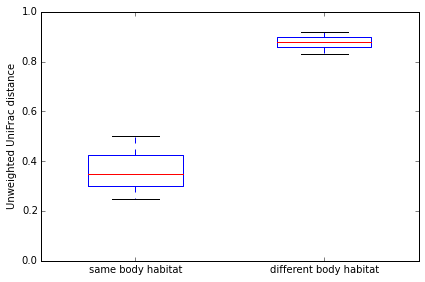

In [34]:
from skbio.draw import boxplots

plot = boxplots([within_category_distances, between_category_distances],
                x_tick_labels=['same body habitat', 'different body habitat'],
                x_tick_labels_orientation='horizontal',
                y_label="Unweighted UniFrac distance",
                y_min=0.0, y_max=1.0)

In [35]:
from scipy.stats import ttest_ind
t, p_value = ttest_ind(within_category_distances, between_category_distances)
print t, p_value

-14.0187203101 3.17133166547e-09


If we run through these same steps, but base our analysis on a different metadata category where we don't expect to see any significant clustering, you can see that we no longer get a significant result.

In [36]:
within_category_distances, between_category_distances = \
    within_between_category_distributions(human_microbiome_dm, human_microbiome_sample_md, "person")
print within_category_distances
print between_category_distances

[0.82999999999999996, 0.84999999999999998, 0.90000000000000002, 0.88, 0.91000000000000003, 0.88]
[0.34999999999999998, 0.85999999999999999, 0.82999999999999996, 0.25, 0.92000000000000004, 0.88, 0.90000000000000002, 0.87, 0.5]


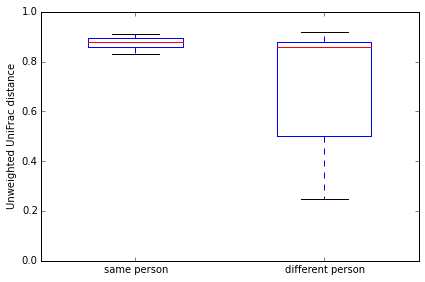

In [37]:
plot = boxplots([within_category_distances, between_category_distances],
                x_tick_labels=['same person', 'different person'],
                x_tick_labels_orientation='horizontal',
                y_label="Unweighted UniFrac distance",
                y_min=0.0, y_max=1.0)

In [38]:
t, p_value = ttest_ind(within_category_distances, between_category_distances)
print t, p_value

1.53700820694 0.148267378899


Why do you think the distribution of distances between people has such as larger range than the distribution of distances within people in this particular example?

#### Heirarchical clustering

Next, let's look at a hierarchical clustering analysis, similar to that presented in panel G above. Here I'm applying the UPGMA functionality implemented in [scipy](http://www.scipy.org/scipylib/index.html) to generate a tree which we visualize with a dendrogram. However the tips in this tree don't represent sequences or OTUs, like they did when we covered UPGMA in the [Phylogenetic reconstruction chapter](../algorithms/3-phylogeny-reconstruction.ipynb) chapter, but instead they represent samples, and samples with a smaller branch length between them are more similar in composition than samples with a longer branch length between them. (Remember that only horizontal branch length is counted - vertical branch length is just to aid in the organization of the dendrogram.)

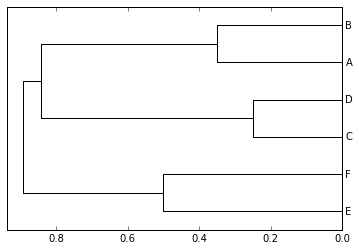

In [39]:
from scipy.cluster.hierarchy import average, dendrogram
lm = average(human_microbiome_dm.condensed_form())
d = dendrogram(lm, labels=human_microbiome_dm.ids, orientation='right', 
               link_color_func=lambda x: 'black')

Again, we can see how the data really only becomes interpretable in the context of metadata:

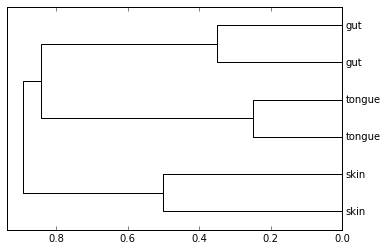

In [40]:
labels = [human_microbiome_sample_md[sid]['body_habitat'] for sid in sample_ids]
d = dendrogram(lm, labels=labels, orientation='right', 
               link_color_func=lambda x: 'black')

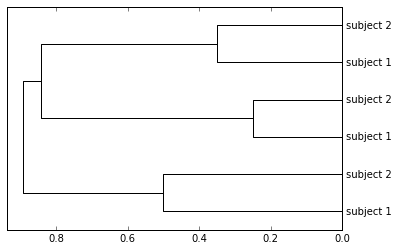

In [41]:
labels = [human_microbiome_sample_md[sid]['person'] for sid in sample_ids]
d = dendrogram(lm, labels=labels, orientation='right', 
               link_color_func=lambda x: 'black')

### Ordination

Finally, let's look at ordination, similar to that presented in panels A-D. The basic idea behind oridination is dimensionality reduction: we want to take high-dimensionality data (a distance matrix) and represent that in a few (usually two or three) dimensions. As humans, we're very bad at interpreting high dimensionality data directly: with ordination, we can take an $n$-dimensional data set (e.g., a distance matrix of shape $n \times n$, representing the distances between $n$ biological samples) and reduce that to a 2-dimensional scatter plot similar to that presented in panels A-D above. 

Ordination is a technique that is widely applied in ecology and in bioinformatics, but the math behind some of the methods such as *Principal Coordinates Analysis* is fairly complex, and as a result I've found that these methods are a black box for a lot of people. Possibly the most simple ordination technique is one called Polar Ordination. Polar Ordination is not widely applied because it has some incovenient features, but I find that it is useful for introducing the idea behind ordination. Here we'll work through a simple implementation of ordination to illustrate the process, which will help us to interpret ordination plots. In practice, you will use existing software, such as [scikit-bio](http://scikit-bio.org)'s [ordination module](http://scikit-bio.org/maths.stats.ordination.html). 

An excellent site for learning more about ordination is [Michael W. Palmer's Ordination Methods page](http://ordination.okstate.edu/).


#### Polar ordination

First, let's print our distance matrix again so we have it nearby.

In [42]:
print human_microbiome_dm

6x6 distance matrix
IDs:
'A', 'B', 'C', 'D', 'E', 'F'
Data:
[[ 0.    0.35  0.83  0.83  0.9   0.9 ]
 [ 0.35  0.    0.86  0.85  0.92  0.91]
 [ 0.83  0.86  0.    0.25  0.88  0.87]
 [ 0.83  0.85  0.25  0.    0.88  0.88]
 [ 0.9   0.92  0.88  0.88  0.    0.5 ]
 [ 0.9   0.91  0.87  0.88  0.5   0.  ]]


Polar ordination works in a few steps:

**Step 1.** Identify the largest distance in the distance matrix.

**Step 2.** Define a line, with the two samples contributing to that distance defining the endpoints.

**Step 3.** Compute the location of each other sample on that axis as follows:

$a = \frac{D^2 + D1^2 - D2^2}{2 \times D}$
   
where:

$D$ is distance between the endpoints

$D1$ is distance between the current sample and endpoint 1

$D2$ is distance between sample and endpoint 2.

**Step 4.** Find the next largest distance that could be used to define an *uncorrelated axis*. (This step can be labor-intensive to do by hand – usually you would compute all of the axes, along with correlation scores. I’ll pick one for the demo, and we'll wrap up by looking at all of the axes.)

Here is what steps 2 and 3 look like in python:

In [43]:
def compute_axis_values(dm, endpoint1, endpoint2):
    d = dm[endpoint1, endpoint2]
    result = {endpoint1: 0, endpoint2: d}
    non_endpoints = set(dm.ids) - set([endpoint1, endpoint2])
    for e in non_endpoints:
        d1 = dm[endpoint1, e]
        d2 = dm[endpoint2, e]
        result[e] = (d**2 + d1**2 - d2**2) / (2 * d)
    return d, [result[e] for e in dm.ids]

In [44]:
d, a1_values = compute_axis_values(human_microbiome_dm, 'B', 'E')
for sid, a1_value in zip(human_microbiome_dm.ids, a1_values):
    print sid, a1_value

A 0.0863586956522
B 0
C 0.441086956522
D 0.431793478261
E 0.92
F 0.774184782609


In [45]:
d, a2_values = compute_axis_values(human_microbiome_dm, 'D', 'E')
for sid, a2_value in zip(human_microbiome_dm.ids, a2_values):
    print sid, a2_value

A 0.371193181818
B 0.369602272727
C 0.0355113636364
D 0
E 0.88
F 0.737954545455


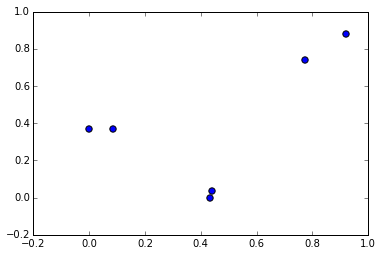

In [46]:
from pylab import scatter
ord_plot = scatter(a1_values, a2_values, s=40)

And again, let's look at how including metadata helps us to interpret our results.

First, we'll color the points by the body habitat that they're derived from:

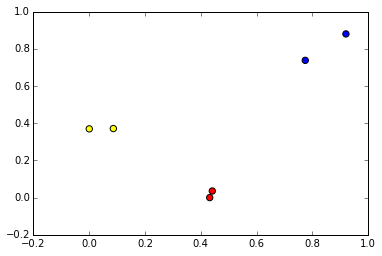

In [47]:
colors = {'tongue': 'red', 'gut':'yellow', 'skin':'blue'}
c = [colors[human_microbiome_sample_md[e]['body_habitat']] for e in human_microbiome_dm.ids]
ord_plot = scatter(a1_values, a2_values, s=40, c=c)

And next we'll color the samples by the person that they're derived from. Notice that this plot and the one above are identical except for coloring. Think about how the colors (and therefore the sample metadata) help you to interpret these plots.

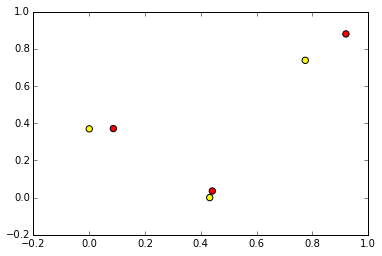

In [48]:
person_colors = {'subject 1': 'red', 'subject 2':'yellow'}
person_c = [person_colors[human_microbiome_sample_md[e]['person']] for e in human_microbiome_dm.ids]
ord_plot = scatter(a1_values, a2_values, s=40, c=person_c)

#### Determining the most important axes in polar ordination

Generally, you would compute the polar ordination axes for all possible axes. You could then order the axes by which represent the largest differences in sample composition, and the lowest correlation with previous axes. This might look like the following:

In [49]:
from scipy.stats import spearmanr

data = []
for i, sample_id1 in enumerate(human_microbiome_dm.ids):
    for sample_id2 in human_microbiome_dm.ids[:i]:
        d, axis_values = compute_axis_values(human_microbiome_dm, sample_id1, sample_id2)
        r, p = spearmanr(a1_values, axis_values)
        data.append((d, abs(r), sample_id1, sample_id2, axis_values))

data.sort()
data.reverse()
for i, e in enumerate(data):
    print "axis %d:" % i, 
    print "\t%1.3f\t%1.3f\t%s\t%s" % e[:4]

axis 0: 	0.920	1.000	E	B
axis 1: 	0.910	0.943	F	B
axis 2: 	0.900	0.928	E	A
axis 3: 	0.900	0.886	F	A
axis 4: 	0.880	0.543	E	D
axis 5: 	0.880	0.429	F	D
axis 6: 	0.880	0.429	E	C
axis 7: 	0.870	0.371	F	C
axis 8: 	0.860	0.543	C	B
axis 9: 	0.850	0.486	D	B
axis 10: 	0.830	0.429	C	A
axis 11: 	0.830	0.406	D	A
axis 12: 	0.500	0.232	F	E
axis 13: 	0.350	0.143	B	A
axis 14: 	0.250	0.493	D	C


So why do we care about axes being uncorrelated? And why do we care about explaining a lot of the variation? Let's look at a few of these plots and see how they compare to the plots above, where we compared axes 1 and 4.

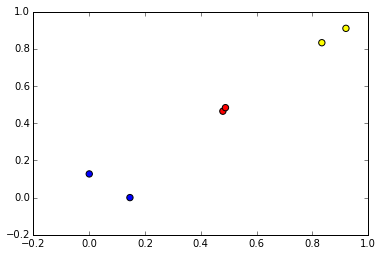

In [50]:
ord_plot = scatter(data[0][4], data[1][4], s=40, c=c)

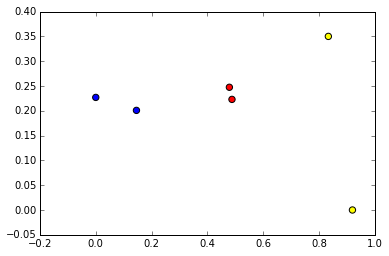

In [51]:
ord_plot = scatter(data[0][4], data[13][4], s=40, c=c)

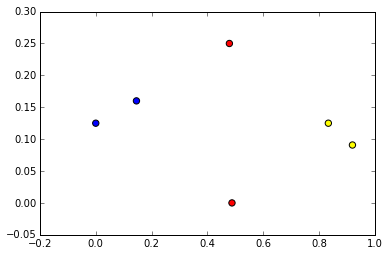

In [52]:
ord_plot = scatter(data[0][4], data[14][4], s=40, c=c)

#### Interpreting ordination plots

There are a few points that are important to keep in mind when interpreting ordination plots. Review each one of these in the context of polar ordination to figure out the reason for each.

**Directionality of the axes is not important (e.g., up/down/left/right)**

One thing that you may have notices as you computed the polar ordination above is that the method is *not symmetric*: in other words, the axis values for axis $EB$ are different than for axis $BE$. In practice though, we derive the same conclusions regardless of how we compute that axis: in this example, that samples cluster by body site.

In [53]:
d, a1_values = compute_axis_values(human_microbiome_dm, 'E', 'B')
d, a2_values = compute_axis_values(human_microbiome_dm, 'E', 'D')
d, alt_a1_values = compute_axis_values(human_microbiome_dm, 'B', 'E')

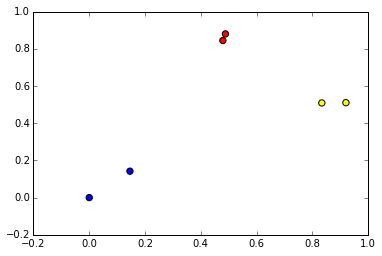

In [54]:
ord_plot = scatter(a1_values, a2_values, s=40, c=c)

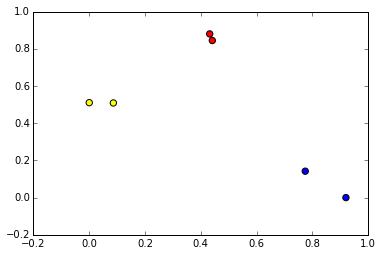

In [55]:
ord_plot = scatter(alt_a1_values, a2_values, s=40, c=c)

Some other important features:

* Numerical scale of the axis is generally not useful
* The order of axes is generally important (first axis explains the most variation, second axis explains the second most variation, ...)
* Most techniques result in uncorrelated axes.
* Additional axes can be generated (third, fourth, ...)

## Tools for using ordination in practice: scikit-bio, pandas, and matplotlib

As I mentioned above, polar ordination isn't widely used in practice, but the features that it illustrates are common to ordination methods. One of the most widely used ordination methods used to study biological diversity is Principal Coordinates Analysis or PCoA, which is implemented in [scikit-bio](http://scikit-bio.org/)'s [``ordination`` module](http://scikit-bio.org/maths.stats.ordination.html) (among many other packages). 

In this setion, we're going to make use of three python third-party modules to apply PCoA and visualize the results 3D scatter plots. The data we'll use here is the full unweighted UniFrac distance matrix from a study of soil microbial communities across North and South America (originally published in [Lauber *et al.* (2009)](http://www.ncbi.nlm.nih.gov/pubmed/19502440)). We're going to use [pandas](http://pandas.pydata.org/) to manage the metadata, [scikit-bio](http://scikit-bio.org/) to manage the distance matrix and compute PCoA, and [matplotlib](http://matplotlib.org/) to visualize the results.

First, we'll load sample metadata into a [pandas DateFrame](http://pandas.pydata.org/pandas-docs/dev/generated/pandas.DataFrame.html). These are really useful for loading and working with the type of tabular information that you'd typically store in a spreadsheet or database table. (Note that one thing I'm doing in the following cell is tricking pandas into thinking that it's getting a file as input, even though I have the information represented as tab-separated lines in a multiline string. [python's StringIO](https://docs.python.org/2/library/stringio.html) is very useful for this, and it's especially convenient in your unit tests... which you're writing for all of your code, right?) Here we'll load the tab-separated text, and then print it.


In [56]:
from StringIO import StringIO
import pandas as pd

soil_sample_md_str = """	pH	ENVO biome	Latitude
CF3.141691	3.56	ENVO:Temperate broadleaf and mixed forest biome	42.11666667
PE5.141692	3.57	ENVO:Tropical humid forests	-12.63333333
BF2.141708	3.61	ENVO:Temperate broadleaf and mixed forest biome	41.58333333
CF2.141679	3.63	ENVO:Temperate broadleaf and mixed forest biome	41.93333333
CF1.141675	3.92	ENVO:Temperate broadleaf and mixed forest biome	42.15833333
HF2.141686	3.98	ENVO:Temperate broadleaf and mixed forest biome	42.5
BF1.141647	4.05	ENVO:Temperate broadleaf and mixed forest biome	41.58333333
PE4.141683	4.1	ENVO:Tropical humid forests	-13.08333333
PE2.141725	4.11	ENVO:Tropical humid forests	-13.08333333
PE1.141715	4.12	ENVO:Tropical humid forests	-13.08333333
PE6.141700	4.12	ENVO:Tropical humid forests	-12.65
TL3.141709	4.23	ENVO:shrubland	68.63333333
HF1.141663	4.25	ENVO:Temperate broadleaf and mixed forest biome	42.5
PE3.141731	4.25	ENVO:Tropical humid forests	-13.08333333
BB1.141690	4.3	ENVO:Tropical humid forests	44.87
MP2.141695	4.38	ENVO:Temperate broadleaf and mixed forest biome	49.46666667
MP1.141661	4.56	ENVO:Temperate grasslands	49.46666667
TL1.141653	4.58	ENVO:grassland	68.63333333
BB2.141659	4.6	ENVO:Temperate broadleaf and mixed forest biome	44.86666667
LQ3.141712	4.67	ENVO:Tropical humid forests	18.3
CL3.141664	4.89	ENVO:Temperate broadleaf and mixed forest biome	34.61666667
LQ1.141701	4.89	ENVO:Tropical humid forests	18.3
HI4.141735	4.92	ENVO:Tropical and subtropical grasslands, savannas, and shrubland biome	20.08333333
SN1.141681	4.95	ENVO:Temperate broadleaf and mixed forest biome	36.45
LQ2.141729	5.03	ENVO:Tropical humid forests	18.3
CL4.141667	5.03	ENVO:Temperate grasslands	34.61666667
DF3.141696	5.05	ENVO:Temperate broadleaf and mixed forest biome	35.96666667
BZ1.141724	5.12	ENVO:forest	64.8
SP2.141678	5.13	ENVO:Temperate grasslands	36.61666667
IE1.141648	5.27	ENVO:Temperate grasslands	41.8
HJ2.141717	5.36	ENVO:Temperate broadleaf and mixed forest biome	44.21666667
DF1.141684	5.37	ENVO:Temperate broadleaf and mixed forest biome	35.96666667
HJ1.141718	5.41	ENVO:Temperate broadleaf and mixed forest biome	44.21666667
IT2.141720	5.42	ENVO:Temperate broadleaf and mixed forest biome	47.18333333
SK1.141669	5.45	ENVO:forest	53.9
PE7.141734	5.51	ENVO:Tropical humid forests	-12.65
IE2.141655	5.52	ENVO:Temperate grasslands	41.8
VC1.141722	5.55	ENVO:forest	35.9
CL2.141671	5.57	ENVO:Temperate grasslands	34.61666667
CL1.141697	5.68	ENVO:Temperate broadleaf and mixed forest biome	34.61666667
CO2.141657	5.68	ENVO:forest	40.58333333
SN3.141650	5.74	ENVO:shrubland	36.45
IT1.141711	5.78	ENVO:Temperate broadleaf and mixed forest biome	47.16666667
AR1.141727	5.8	ENVO:Tropical humid forests	-27.73333333
SK3.141716	5.83	ENVO:forest	53.6
AR3.141705	5.9	ENVO:Tropical humid forests	-27.73333333
VC2.141694	5.99	ENVO:grassland	35.9
AR2.141703	6.0	ENVO:Tropical humid forests	-27.73333333
CO3.141651	6.02	ENVO:grassland	40.8
CC1.141721	6.06	ENVO:Temperate grasslands	45.4
CO1.141714	6.13	ENVO:forest	40.4
SK2.141662	6.18	ENVO:forest	53.98333333
SP1.141656	6.25	ENVO:shrubland	36.5
HI2.141672	6.32	ENVO:Tropical and subtropical grasslands, savannas, and shrubland biome	20.08333333
KP1.141713	6.37	ENVO:Temperate grasslands	39.1
HI1.141693	6.45	ENVO:Tropical and subtropical grasslands, savannas, and shrubland biome	20.08333333
TL2.141706	6.47	ENVO:shrubland	68.63333333
HI3.141676	6.53	ENVO:Tropical and subtropical grasslands, savannas, and shrubland biome	20.08333333
MT2.141698	6.66	ENVO:forest	46.8
DF2.141726	6.84	ENVO:Temperate broadleaf and mixed forest biome	35.96666667
GB1.141665	6.84	ENVO:grassland	39.33333333
SR1.141680	6.84	ENVO:shrubland	34.7
SA1.141670	6.9	ENVO:forest	35.36666667
SR3.141674	6.95	ENVO:shrubland	34.68333333
KP4.141733	7.1	ENVO:shrubland	39.1
GB3.141652	7.18	ENVO:forest	39.31666667
CA1.141704	7.27	ENVO:forest	36.05
BP1.141702	7.53	ENVO:grassland	43.75
GB2.141732	7.57	ENVO:forest	39.31666667
MT1.141719	7.57	ENVO:forest	46.8
JT1.141699	7.6	ENVO:shrubland	33.96666667
MD2.141689	7.65	ENVO:shrubland	34.9
SF1.141728	7.71	ENVO:shrubland	35.38333333
CM1.141723	7.85	ENVO:Temperate grasslands	33.3
MD3.141707	7.9	ENVO:shrubland	34.9
KP3.141658	7.92	ENVO:shrubland	39.1
SB1.141730	7.92	ENVO:shrubland	34.46666667
RT1.141654	7.92	ENVO:shrubland	31.46666667
SR2.141673	8.0	ENVO:shrubland	34.68333333
CR1.141682	8.0	ENVO:Temperate grasslands	33.93333333
CA2.141685	8.02	ENVO:shrubland	36.05
RT2.141710	8.07	ENVO:Temperate grasslands	31.46666667
MD5.141688	8.07	ENVO:shrubland	35.2
SA2.141687	8.1	ENVO:shrubland	35.36666667
GB5.141668	8.22	ENVO:shrubland	39.35
SV1.141649	8.31	ENVO:shrubland	34.33333333
SF2.141677	8.38	ENVO:shrubland	35.38333333
SV2.141666	8.44	ENVO:grassland	34.33333333
MD4.141660	8.86	ENVO:shrubland	35.2"""

soil_sample_md = pd.read_csv(StringIO(soil_sample_md_str), sep='\t', index_col=0)
print soil_sample_md

              pH                                         ENVO biome   Latitude
CF3.141691  3.56    ENVO:Temperate broadleaf and mixed forest biome  42.116667
PE5.141692  3.57                        ENVO:Tropical humid forests -12.633333
BF2.141708  3.61    ENVO:Temperate broadleaf and mixed forest biome  41.583333
CF2.141679  3.63    ENVO:Temperate broadleaf and mixed forest biome  41.933333
CF1.141675  3.92    ENVO:Temperate broadleaf and mixed forest biome  42.158333
HF2.141686  3.98    ENVO:Temperate broadleaf and mixed forest biome  42.500000
BF1.141647  4.05    ENVO:Temperate broadleaf and mixed forest biome  41.583333
PE4.141683  4.10                        ENVO:Tropical humid forests -13.083333
PE2.141725  4.11                        ENVO:Tropical humid forests -13.083333
PE1.141715  4.12                        ENVO:Tropical humid forests -13.083333
PE6.141700  4.12                        ENVO:Tropical humid forests -12.650000
TL3.141709  4.23                                    

Just as one simple example of the many things that pandas can do, to look up a value, such as the pH of sample ``MT2.141698``, we can do the following. If you're interesting in learning more about pandas, [*Python for Data Analysis*](http://shop.oreilly.com/product/0636920023784.do) is a very good resource.

In [57]:
soil_sample_md['pH']['MT2.141698']

6.6600000000000001

Next we'll load our distance matrix. This is similar to ``human_microbiome_dm_data`` one that we loaded above, just a little bigger. After loading, we can print the resulting ``DistanceMatrix`` object for a summary. How many samples are represented in this distance matrix?

In [58]:
soil_dm_str = """	IT2.141720	HI3.141676	MD2.141689	CA1.141704	PE5.141692	CO1.141714	DF3.141696	PE1.141715	SP2.141678	CO3.141651	SA2.141687	CM1.141723	LQ2.141729	SR2.141673	CR1.141682	VC1.141722	IE2.141655	RT2.141710	CC1.141721	TL2.141706	PE6.141700	HI1.141693	PE7.141734	BF1.141647	MP2.141695	KP1.141713	CL3.141664	SK3.141716	SF1.141728	PE4.141683	BP1.141702	SB1.141730	SF2.141677	SN1.141681	SA1.141670	KP3.141658	IE1.141648	CL1.141697	MD5.141688	SR1.141680	HI2.141672	MT1.141719	TL3.141709	SV1.141649	CO2.141657	MT2.141698	HF1.141663	CF2.141679	RT1.141654	GB1.141665	DF1.141684	PE2.141725	CA2.141685	CF1.141675	GB5.141668	LQ3.141712	DF2.141726	LQ1.141701	MD4.141660	IT1.141711	BF2.141708	SN3.141650	TL1.141653	AR3.141705	JT1.141699	BZ1.141724	HI4.141735	AR2.141703	SV2.141666	MD3.141707	KP4.141733	HJ2.141717	SR3.141674	CF3.141691	SK2.141662	AR1.141727	BB2.141659	GB3.141652	HJ1.141718	PE3.141731	MP1.141661	SP1.141656	CL4.141667	HF2.141686	VC2.141694	GB2.141732	CL2.141671	SK1.141669
IT2.141720	0.0	0.725773091052	0.840423748527	0.758482011874	0.771359564922	0.701826470377	0.703129567066	0.759157912705	0.733834113466	0.728857809727	0.779159522647	0.779077557214	0.771873434323	0.793005811266	0.779888061433	0.667300873793	0.640906302613	0.784000837393	0.692952713183	0.752485289039	0.776979159076	0.824563507319	0.722355420178	0.735134301999	0.697642054616	0.719166984884	0.678999994481	0.637515880591	0.786679757284	0.790354038163	0.755533203689	0.783381686383	0.830620234033	0.75646306659	0.728694333885	0.778714889996	0.660807943732	0.693423789512	0.838269383093	0.746090037924	0.760916673451	0.734032134333	0.700861918649	0.836923582576	0.653458845523	0.638683822007	0.753317335989	0.80785480165	0.77652521287	0.755777524938	0.668460544639	0.772640789823	0.777783719901	0.763243754162	0.802743437466	0.798105495544	0.722004061492	0.770545467085	0.876612094285	0.640903736276	0.741517185699	0.726887960639	0.740259851582	0.753887960732	0.821143939862	0.652739486274	0.78666651507	0.73784805049	0.826864477696	0.830157365182	0.711727965435	0.658102009525	0.783980531592	0.82161856584	0.710510899571	0.74654765423	0.777694289473	0.725898143961	0.708411254858	0.77617146466	0.704315546191	0.722196372016	0.723687929105	0.770607237982	0.713622333656	0.770994532905	0.713860366658	0.673966462302
HI3.141676	0.725773091052	0.0	0.81429343677	0.704665508827	0.844842481347	0.741592097109	0.77993688397	0.840415653631	0.793692039276	0.73462144505	0.748971911772	0.726967385044	0.806249711955	0.747223990154	0.726444982036	0.735887881472	0.69770222342	0.714504901033	0.70646384851	0.738422613935	0.817166853011	0.79288700253	0.715694868608	0.821348150515	0.810171843632	0.695878471242	0.726284278394	0.766466567718	0.729117548277	0.855397762605	0.697311848764	0.720575594818	0.781619830918	0.824432503645	0.742774527311	0.692466768727	0.67562843859	0.739137708135	0.805357753547	0.693125255157	0.733787366154	0.676144596063	0.805080331155	0.814804616773	0.724618208348	0.705956537748	0.83058108071	0.869761152057	0.718627893901	0.726922123354	0.76965150158	0.835449205807	0.740776552254	0.807102707019	0.747249905597	0.830017228532	0.652435950745	0.792999185826	0.839742991202	0.70729868634	0.828030738304	0.768700087368	0.833690812475	0.685875755202	0.802664501304	0.789331736942	0.818764478591	0.696691764219	0.801976687282	0.798461810061	0.666367634388	0.75021673688	0.72531515505	0.87371599298	0.746251775006	0.713439352711	0.830441268028	0.689037145585	0.789717105851	0.829189945535	0.793596976211	0.705973521787	0.712975534343	0.839352222705	0.71075488152	0.71206229417	0.700396287442	0.784531402763
MD2.141689	0.840423748527	0.81429343677	0.0	0.746520096574	0.88760585428	0.797294357301	0.868194577459	0.881765126376	0.868516190918	0.762795500279	0.735334884156	0.808751822141	0.875553646567	0.67864427186	0.770165085885	0.823355752554	0.821204500737	0.78717159326	0.819016238986	0.851417586185	0.882892475174	0.73945867647	0.853574027459	0.874712411813	0.858530990581	0.795486334044	0.852024218899	0.850647116438	0.700201392784	0.891812250929	0.757845378831	0.71161079096	0.654155972636	0.829284103694	0.73364306828	0.787195983486	0.842024508449	0.852452605398	0.638075501449	0.754625993223	0.804373137596	0.81351771316	0.853124210063	0.604686583191	0.822305326325	0.823810266968	0.872066389807	0.901704083136	0.796714315897	0.71620113723	0.855576402608	0.869997687833	0.739660111692	0.873243042166	0.668985930799	0.880044779978	0.825228753019	0.865538294052	0.694235142588	0.828622421807	0.877323266126	0.77633980072	0.871972417202	0.832669314188	0.638767783691	0.852473067506	0.892169390036	0.839222502153	0.616619726252	0.608185255122	0.793956150507	0.852932510351	0.715473308803	0.905377211994	0.8464667955	0.818747345545	0.868163796082	0.793072256006	0.843330717689	0.881565195289	0.855258825558	0.77884674162	0.816955958717	0.884155144409	0.770377998309	0.747001448824	0.829163370451	0.84125975609
CA1.141704	0.758482011874	0.704665508827	0.746520096574	0.0	0.864457805475	0.709445648312	0.829472621217	0.858239914754	0.811825652188	0.661045684539	0.65794176434	0.703023584226	0.836874803642	0.658709237576	0.680075618307	0.735500992613	0.72904417536	0.698957499106	0.712113313084	0.725173723859	0.842216816076	0.78627834568	0.761988529372	0.851152316998	0.833594088464	0.687245040254	0.76137815712	0.791039771569	0.655964075997	0.884698247334	0.651622255046	0.683515442701	0.702586011866	0.827971851617	0.676864474754	0.696916909616	0.748503873342	0.754490209797	0.794978591406	0.647139653868	0.787233044906	0.694396584761	0.823425661703	0.745785284058	0.724608641344	0.711706052509	0.8640955885	0.895160861788	0.708725196696	0.640023870345	0.798848964148	0.849435226727	0.607475382778	0.858361139887	0.68827743653	0.862534174637	0.713619265134	0.833901721981	0.817408722742	0.729757766678	0.857441315808	0.741821002834	0.839170444899	0.727572885222	0.751533995993	0.803164301688	0.85698333904	0.745888090994	0.726309630882	0.766499619083	0.696622673929	0.752703538113	0.681854897974	0.902217157188	0.741753630523	0.753128102784	0.853209737603	0.666137427308	0.798937677593	0.85959893929	0.817143715833	0.670163054887	0.75631808707	0.876014949306	0.695058991488	0.632045389698	0.745395557492	0.802090919047
PE5.141692	0.771359564922	0.844842481347	0.88760585428	0.864457805475	0.0	0.845818399475	0.687665997056	0.636487291322	0.738010912081	0.812566357989	0.865485790103	0.868234390325	0.682374001252	0.871083004944	0.872344762121	0.80052054247	0.794387394303	0.861174933218	0.820213972414	0.84915777173	0.646132454796	0.858072554376	0.773660636707	0.662497570886	0.694653318567	0.849413632276	0.745495375448	0.742729077253	0.874939320877	0.608025609053	0.860947318323	0.86809773012	0.891308559891	0.788430835983	0.849150967687	0.865901931992	0.802117585933	0.732457690067	0.888955427624	0.856465387962	0.827393158652	0.86592238082	0.709546037837	0.89791545284	0.796208932978	0.802851265845	0.669674141769	0.70111220887	0.870618505486	0.867068977134	0.740382028757	0.693578150717	0.877323057868	0.698663834425	0.888090492655	0.673072834119	0.840395566157	0.75777425288	0.909516261776	0.815725429545	0.675817072916	0.81971066228	0.778376893482	0.82754703566	0.899838806239	0.744306398546	0.743584456297	0.831103755948	0.892091550025	0.886732524628	0.845877826604	0.76056292442	0.874508881968	0.683099220853	0.831739420003	0.835904945733	0.718443198271	0.838609461325	0.749828090683	0.616498812321	0.714103352794	0.833033117018	0.778213349223	0.684182167348	0.808667885206	0.874000155512	0.803646149281	0.757202316601
CO1.141714	0.701826470377	0.741592097109	0.797294357301	0.709445648312	0.845818399475	0.0	0.783542540367	0.83921586106	0.77241642283	0.707242620534	0.755505241034	0.781309451413	0.824398434366	0.748625952809	0.779358359946	0.672382074031	0.679511117223	0.770542168481	0.706971441315	0.734758646115	0.82635663189	0.814643836036	0.776428099901	0.813985995187	0.780522635614	0.745644384649	0.726770661408	0.708545826305	0.764351453917	0.856313845859	0.709846737221	0.741664918384	0.77486070035	0.753661288151	0.700327728059	0.766320907675	0.718933751925	0.762711503564	0.814739334195	0.723181781599	0.798359191777	0.742494042586	0.775214787008	0.806350875416	0.673315235424	0.682229231222	0.818591995203	0.864036905321	0.790553187439	0.714115996809	0.742844058375	0.827522763616	0.756638841505	0.830420628365	0.756872709118	0.835425293592	0.756659425164	0.816326607343	0.836989180708	0.696972735314	0.805316222255	0.671144220669	0.797769114063	0.756578609073	0.792722559973	0.722359318109	0.825194981264	0.76477220949	0.788834444516	0.792823136623	0.727375793632	0.724170001708	0.737269438796	0.878315694715	0.734825967476	0.761878108235	0.823549513674	0.715683670904	0.756257777735	0.833671076529	0.778340785101	0.700818101966	0.729729299347	0.840337744149	0.707534609909	0.734445360388	0.721950100873	0.7312195981
DF3.141696	0.703129567066	0.77993688397	0.868194577459	0.829472621217	0.687665997056	0.783542540367	0.0	0.67259196636	0.691059722298	0.788354441309	0.834355233899	0.833614246515	0.707328995193	0.840635667045	0.838618765224	0.732282961226	0.716506100671	0.829236520199	0.766185183113	0.810563567535	0.69804305061	0.83371239657	0.749320410482	0.653849845862	0.657706653003	0.812102215213	0.656890248525	0.676892115458	0.837613898876	0.697858758804	0.82413700179	0.837848152447	0.870040988918	0.743537980269	0.81319295055	0.839039865949	0.73587632348	0.661736720843	0.867410150701	0.810512302516	0.782255509709	0.82111618802	0.65755706484	0.882781445907	0.725692327223	0.743902232785	0.635947727533	0.727988390789	0.837471553774	0.826074713469	0.665777000518	0.71977389406	0.84481635113	0.666204950601	0.852565471972	0.726135973874	0.78922830885	0.736359341407	0.897293436128	0.751557922894	0.677820272629	0.779117782739	0.755544363413	0.791360067642	0.870963428815	0.685052988159	0.70360531656	0.788308218602	0.863650793482	0.858556411253	0.800674039008	0.69975054384	0.827248878353	0.734921435387	0.786373955582	0.794253324271	0.701710331124	0.790108849618	0.671714344819	0.68797405464	0.691372287918	0.786542592456	0.732935216409	0.665883334697	0.768556021105	0.854646046721	0.732598123492	0.683121159457
PE1.141715	0.759157912705	0.840415653631	0.881765126376	0.858239914754	0.636487291322	0.83921586106	0.67259196636	0.0	0.71707907341	0.824251536046	0.859930532777	0.857991642038	0.71053485237	0.870371273876	0.870010184484	0.792712975418	0.776796210654	0.85039475219	0.798047962057	0.839104786808	0.690002607463	0.849859795678	0.77106969353	0.659405757273	0.66825780799	0.840473629692	0.728610924548	0.703451815224	0.872683467839	0.623142635198	0.857593689387	0.87001539661	0.89172523266	0.785917354724	0.849847144416	0.857903389931	0.773460966558	0.723258912759	0.87792806532	0.848679905899	0.82532382892	0.851767837836	0.706756514296	0.891038147849	0.778764994873	0.791641982742	0.651756893815	0.719835521661	0.87043710991	0.852329691091	0.711858221284	0.624159317868	0.86687621503	0.676067010672	0.873383537153	0.701222947934	0.824318724963	0.732141477538	0.902938092579	0.805482709558	0.689103150204	0.821984192086	0.759311153687	0.820567123911	0.881651476748	0.724358760311	0.728211317649	0.814388528339	0.890911243332	0.87136751646	0.828976917881	0.744424940536	0.87221887496	0.6867591797	0.807663299423	0.806313613938	0.706825193863	0.839026964343	0.720878157725	0.603029451919	0.699456696089	0.822439626464	0.781969112594	0.652984881002	0.812657135171	0.862470516065	0.79780306402	0.755930422531
SP2.141678	0.733834113466	0.793692039276	0.868516190918	0.811825652188	0.738010912081	0.77241642283	0.691059722298	0.71707907341	0.0	0.784878483446	0.837401489276	0.828875434699	0.756783109579	0.842443438713	0.842344742885	0.736618779194	0.725898659561	0.830750173154	0.753106723879	0.771840325344	0.729769159496	0.835168572598	0.7568801097	0.696387556883	0.686815358071	0.81147000027	0.715837161478	0.686614237821	0.837842883587	0.765894671756	0.818645642813	0.836418893534	0.855901266132	0.754977729403	0.815935895523	0.823779453221	0.730250045352	0.730211188839	0.866371680678	0.800543583673	0.815103446415	0.81905693441	0.693808653912	0.871996479807	0.741565787031	0.742839845162	0.692708055202	0.768826919463	0.840004756388	0.815884916633	0.695160801387	0.730991678664	0.824791558891	0.70777205938	0.841445655169	0.740458709307	0.792515605324	0.731112247606	0.889227221478	0.755814178825	0.730728192703	0.76008986703	0.700045946964	0.791592600714	0.863372598427	0.695712427626	0.700085508054	0.792760912785	0.86222369994	0.85351565461	0.798410017846	0.687683085231	0.828322879517	0.780822594856	0.766185185574	0.793804218083	0.692302692993	0.80153752729	0.67990172952	0.714809653421	0.683800250685	0.784794919774	0.758564389048	0.743270793638	0.764164355083	0.826204667726	0.75773899141	0.723513824746
CO3.141651	0.728857809727	0.73462144505	0.762795500279	0.661045684539	0.812566357989	0.707242620534	0.788354441309	0.824251536046	0.784878483446	0.0	0.703038409514	0.741648220397	0.807416882564	0.686387126298	0.718692938842	0.725031317479	0.705751640203	0.730371791039	0.708274709212	0.749675433299	0.804130879475	0.762432729927	0.758331364881	0.810847766873	0.795808299223	0.696128673102	0.72829612156	0.755692960687	0.697870581167	0.841617501897	0.664724373526	0.717457135295	0.738859271259	0.759950171723	0.667202089025	0.742157347087	0.736411277536	0.726486447016	0.798193983877	0.66021607033	0.73046140988	0.75180310546	0.768583772757	0.779167651223	0.692336061678	0.688650329686	0.810843390609	0.852697710292	0.745847973316	0.701711026871	0.75100411499	0.820986719879	0.671640359541	0.808987527016	0.723360384149	0.816997542507	0.756536274665	0.806234225273	0.829944461183	0.743393430273	0.812615591153	0.675973844667	0.822100266528	0.699914907977	0.775258889503	0.76782749339	0.812974142516	0.739924044512	0.747622388586	0.765542338916	0.694414439295	0.749771220136	0.694201138619	0.858056548	0.76329759714	0.739720569932	0.810991772858	0.689819590321	0.753250208983	0.815778574072	0.771872875944	0.651626188349	0.707914683679	0.827680895118	0.647314738749	0.695879701421	0.681958043459	0.737931920496
SA2.141687	0.779159522647	0.748971911772	0.735334884156	0.65794176434	0.865485790103	0.755505241034	0.834355233899	0.859930532777	0.837401489276	0.703038409514	0.0	0.705311950633	0.838282046908	0.635495189234	0.722675416152	0.764800147138	0.76882577951	0.712404277462	0.745727843909	0.758982265689	0.856926876788	0.791074704609	0.779613506542	0.858838091035	0.834490998254	0.727803573744	0.783502834302	0.814129338471	0.66779833512	0.884266363012	0.669028400108	0.691103837434	0.695152158015	0.830573704333	0.664690562864	0.714443960138	0.781302096797	0.795571315405	0.769239684627	0.689375574015	0.771613250929	0.715701400643	0.840777075772	0.707852243199	0.762797334078	0.736549854424	0.863324133378	0.897280664834	0.714361589922	0.679457343211	0.809441475058	0.852584326724	0.651782715904	0.878386969029	0.661966806804	0.863085212828	0.744183180783	0.843111502142	0.807027223876	0.779701104811	0.86816812113	0.76721806775	0.854848136275	0.743563636606	0.74028978077	0.826661460803	0.863808609763	0.755044729753	0.698945571407	0.738177840359	0.726206923747	0.781533339812	0.710147439431	0.912904216004	0.767646384776	0.766379796199	0.863363917278	0.696992168017	0.804731059845	0.870291133454	0.840538484781	0.710082741172	0.78440334936	0.891223298179	0.73475744922	0.634899737912	0.784995003277	0.821181930555
CM1.141723	0.779077557214	0.726967385044	0.808751822141	0.703023584226	0.868234390325	0.781309451413	0.833614246515	0.857991642038	0.828875434699	0.741648220397	0.705311950633	0.0	0.833284385792	0.698647582582	0.638507643135	0.779621218158	0.759078582308	0.600797771225	0.726909687787	0.761601280066	0.850858904272	0.798569170526	0.755411100208	0.85118353212	0.844160513622	0.700148947983	0.779850325776	0.8110962908	0.732409363381	0.886302928407	0.682261235402	0.704149467029	0.749264529436	0.838942192551	0.764866219214	0.617266806866	0.749433291355	0.771762830717	0.797553295971	0.717100814611	0.784265608414	0.695606435068	0.850316283678	0.796966352522	0.778572739916	0.767840089697	0.846300406184	0.902997856548	0.593691431066	0.712743561299	0.810772544699	0.850523502313	0.699722560733	0.862470227453	0.726218690033	0.844621596662	0.701754594741	0.835027330383	0.826588682382	0.777838898117	0.881227348575	0.79371114945	0.869680547024	0.703168472928	0.786872082185	0.810479731343	0.855308364472	0.70099513347	0.76914594767	0.798426973081	0.663119049829	0.810775570242	0.734226258909	0.909186703963	0.779320388087	0.705303186181	0.856122591078	0.705972422181	0.824954646378	0.867024930485	0.834702657821	0.729864700353	0.753693065609	0.867234991527	0.725149389329	0.675452873053	0.761509560089	0.823124060588
LQ2.141729	0.771873434323	0.806249711955	0.875553646567	0.836874803642	0.682374001252	0.824398434366	0.707328995193	0.71053485237	0.756783109579	0.807416882564	0.838282046908	0.833284385792	0.0	0.845680515759	0.83658133747	0.800101425206	0.769177469399	0.831656822439	0.792191168579	0.814254448313	0.63458500578	0.821969466646	0.721009098133	0.723155811836	0.706819279886	0.826791404195	0.748256058507	0.759742514943	0.846269269206	0.704121846178	0.834915200057	0.85162601626	0.871376822251	0.817924332009	0.849346870546	0.832486720336	0.772416955502	0.743694130835	0.859033338561	0.832330581039	0.795272014011	0.849354072548	0.766564628902	0.885212984199	0.793727787668	0.794572562357	0.723488044173	0.740933918519	0.835671832495	0.833163378977	0.743269783817	0.728613820153	0.858250328324	0.733820615284	0.857529649241	0.666643274917	0.810088964135	0.734016616138	0.895148747778	0.810386684569	0.72019419991	0.815610867919	0.783534173261	0.783417516492	0.867177795779	0.770169194806	0.678124775046	0.785178933951	0.872572956786	0.871758375485	0.805969465569	0.758744662481	0.842289126025	0.758578278268	0.816361229208	0.792811484097	0.727310921447	0.799288150128	0.754548568735	0.673839285199	0.741108769666	0.812675673757	0.742448001348	0.735634048261	0.800480544075	0.849515947701	0.778526897193	0.755217446253
SR2.141673	0.793005811266	0.747223990154	0.67864427186	0.658709237576	0.871083004944	0.748625952809	0.840635667045	0.870371273876	0.842443438713	0.686387126298	0.635495189234	0.698647582582	0.845680515759	0.0	0.681397405071	0.762612253515	0.764651738798	0.697634160038	0.751379802455	0.779361198446	0.854979519052	0.766034183474	0.785218710767	0.865981882917	0.851182896039	0.735259324206	0.801711411429	0.817203292254	0.62654897933	0.88892914054	0.668505866055	0.629487679568	0.640312208208	0.83080258644	0.676314984064	0.694109085235	0.790129273643	0.7929845126	0.744375206268	0.665615071567	0.791246018414	0.747114891693	0.817645926908	0.68043761518	0.753100753884	0.775120499647	0.861704173237	0.900939281881	0.69949221772	0.653610840536	0.820274384809	0.848544490545	0.638709579716	0.867842017221	0.645111518129	0.861525687031	0.758881955637	0.844263432479	0.77837278228	0.776654657581	0.869176969536	0.770826552817	0.85593481368	0.764639879972	0.696224309354	0.815202856768	0.864785834391	0.77403729995	0.655899441967	0.715976394412	0.726725367393	0.790191452797	0.655589488905	0.910496002937	0.796976939799	0.777017964429	0.860540013083	0.720552780385	0.818225060212	0.870279325125	0.840536341577	0.699715221345	0.783493783577	0.889042410545	0.718765195529	0.668264491098	0.776245244538	0.82191314658
CR1.141682	0.779888061433	0.726444982036	0.770165085885	0.680075618307	0.872344762121	0.779358359946	0.838618765224	0.870010184484	0.842344742885	0.718692938842	0.722675416152	0.638507643135	0.83658133747	0.681397405071	0.0	0.778610437063	0.759809984757	0.622823502511	0.73605246628	0.763529064881	0.839064209861	0.792381139213	0.760626415457	0.858917572403	0.84387861183	0.682668814085	0.778028421733	0.811789363109	0.693566074352	0.881990704942	0.678702049626	0.699671173321	0.710859271744	0.841653129227	0.74248607128	0.632654530787	0.770468875297	0.784690957579	0.76832899316	0.688354237779	0.787195923915	0.728926788286	0.843253127075	0.75556143777	0.772393003415	0.770698876494	0.85481740449	0.895183873351	0.607162441621	0.69651754313	0.80946021145	0.847784548931	0.68810596536	0.850010625242	0.69554264464	0.849659487592	0.723062183156	0.823151885306	0.80798096466	0.761800136689	0.868740355105	0.793059219689	0.861308612151	0.701734699323	0.775306635803	0.818747615993	0.852625870852	0.723460696346	0.715489480589	0.76483932267	0.66753270657	0.800597670401	0.718680215026	0.907262644143	0.789591534197	0.716943972817	0.852374123494	0.706848470525	0.822970255019	0.86341518169	0.835489422175	0.713833115724	0.754138156441	0.868728551256	0.720212169885	0.688543055343	0.746855720937	0.816435570277
VC1.141722	0.667300873793	0.735887881472	0.823355752554	0.735500992613	0.80052054247	0.672382074031	0.732282961226	0.792712975418	0.736618779194	0.725031317479	0.764800147138	0.779621218158	0.800101425206	0.762612253515	0.778610437063	0.0	0.679786276869	0.76790748862	0.695662055829	0.729382010493	0.792523123815	0.826371683399	0.751126150208	0.765597342645	0.738505508792	0.722102166078	0.675949631388	0.664550896788	0.773921182068	0.796597907822	0.72713773241	0.756506254024	0.815205640576	0.766723416525	0.725142729687	0.767564172721	0.700127101029	0.71378095005	0.837961230313	0.72933600179	0.789685379904	0.726442143595	0.730434873445	0.828516305179	0.654237193381	0.654448704052	0.765010904911	0.825763452265	0.77635842845	0.716870873802	0.670383565938	0.778265143564	0.751048857663	0.773288013108	0.78506119248	0.797217859438	0.736977024711	0.796177064019	0.863515905328	0.672352337346	0.770976129567	0.720270712711	0.772203126103	0.743889288395	0.811647197085	0.673299120636	0.785342505833	0.738043667043	0.819155115172	0.824362122001	0.713253002134	0.68473667596	0.744073286994	0.836273373634	0.728289041834	0.763779621677	0.792007189004	0.707137063976	0.71093656244	0.801834680598	0.727909782339	0.708600231448	0.722703435595	0.774114230451	0.696387849976	0.753568917792	0.695651663401	0.702129776343
IE2.141655	0.640906302613	0.69770222342	0.821204500737	0.72904417536	0.794387394303	0.679511117223	0.716506100671	0.776796210654	0.725898659561	0.705751640203	0.76882577951	0.759078582308	0.769177469399	0.764651738798	0.759809984757	0.679786276869	0.0	0.767035682833	0.655917328884	0.731455151643	0.779182602253	0.794651607765	0.715422769554	0.751271116964	0.725415967837	0.683939496308	0.660068931276	0.680654379107	0.773457979874	0.804375515117	0.73374761111	0.755846705765	0.8018900672	0.748431377699	0.729285518492	0.767003637676	0.608616163877	0.686523508784	0.826260045439	0.709457157981	0.771792065189	0.709590977805	0.744197898904	0.831311016324	0.678743803422	0.631586254389	0.757018467258	0.819221250894	0.765092400954	0.735266148253	0.667427341309	0.777404094028	0.763444215625	0.759667285565	0.779185566334	0.787458169921	0.700870466695	0.76020357933	0.858920644907	0.636889718158	0.769787121613	0.703264923553	0.769565676597	0.715103475076	0.819412569946	0.676011987709	0.773469262855	0.70743451709	0.80939992279	0.811456520233	0.673280765522	0.675573406305	0.742756595559	0.834009400394	0.708927460989	0.737543848698	0.769148152673	0.711862325997	0.702387079173	0.774955620755	0.714530715176	0.668538337679	0.687929862504	0.790244779836	0.656341427193	0.733058031358	0.651169888444	0.703262973651
RT2.141710	0.784000837393	0.714504901033	0.78717159326	0.698957499106	0.861174933218	0.770542168481	0.829236520199	0.85039475219	0.830750173154	0.730371791039	0.712404277462	0.600797771225	0.831656822439	0.697634160038	0.622823502511	0.76790748862	0.767035682833	0.0	0.735704187218	0.748567322092	0.836027230604	0.783425390753	0.750308130308	0.835055193289	0.837610187802	0.706968247579	0.771545872095	0.812459259466	0.704282769584	0.878061387235	0.666865672938	0.701188156028	0.728653473707	0.833634168305	0.721440063488	0.616480080006	0.757423963554	0.744119275356	0.80528321173	0.699747093299	0.773366683271	0.712319918289	0.842632137884	0.773679492489	0.765709295759	0.752246024737	0.845084479626	0.889343368237	0.569277443512	0.698154177134	0.808979165221	0.843829412152	0.690321224812	0.856081867188	0.712641802895	0.841136161672	0.704707597511	0.826279987525	0.830916434445	0.746368063685	0.863483329618	0.783704676627	0.861727917832	0.685331653839	0.782881117515	0.817300810412	0.852635723231	0.705478131054	0.748420689514	0.781366878611	0.668224564526	0.779266222612	0.717844462919	0.898380058816	0.776448401108	0.721323277399	0.836729712138	0.693307897403	0.803628974461	0.85003531817	0.820764206987	0.701171677338	0.758667220661	0.860835373051	0.73754725046	0.673653230302	0.756546671436	0.814004504088
CC1.141721	0.692952713183	0.70646384851	0.819016238986	0.712113313084	0.820213972414	0.706971441315	0.766185183113	0.798047962057	0.753106723879	0.708274709212	0.745727843909	0.726909687787	0.792191168579	0.751379802455	0.73605246628	0.695662055829	0.655917328884	0.735704187218	0.0	0.709321676283	0.799561000734	0.814935915561	0.689004675148	0.793712480256	0.772429216314	0.70163029715	0.699847431311	0.706357650495	0.742444815294	0.830760867864	0.695733005245	0.75302277993	0.797792468323	0.808356483408	0.730452190534	0.744317488914	0.683120734661	0.703453953314	0.829503486021	0.703796735929	0.778973888576	0.677231925211	0.787941605074	0.81654903395	0.706305301724	0.662542616104	0.792514293982	0.840607072763	0.753330147862	0.702283917452	0.718878504591	0.786607608827	0.733677874942	0.774149075313	0.769504764675	0.810541772956	0.664619411375	0.773824087945	0.867261222182	0.666994194424	0.805851892003	0.734984295315	0.803276379537	0.702715092266	0.819455027325	0.71635868189	0.806504901786	0.703386169882	0.797166629747	0.807608669568	0.683247906828	0.721841637429	0.739972782547	0.857782992451	0.725595189282	0.721381752396	0.79367996072	0.701575704356	0.755563020301	0.801910773217	0.77059548501	0.694580667882	0.710019180318	0.817955239376	0.6557433525	0.701916751581	0.689915792303	0.753669878145
TL2.141706	0.752485289039	0.738422613935	0.851417586185	0.725173723859	0.84915777173	0.734758646115	0.810563567535	0.839104786808	0.771840325344	0.749675433299	0.758982265689	0.761601280066	0.814254448313	0.779361198446	0.763529064881	0.729382010493	0.731455151643	0.748567322092	0.709321676283	0.0	0.803466335525	0.819545591599	0.727732800211	0.829405374386	0.818206836482	0.752696872726	0.749337644953	0.748334461267	0.768663266182	0.865976468659	0.722375067593	0.792222532824	0.810126302266	0.854614270039	0.771833800232	0.750980473516	0.697586663977	0.753128938782	0.862312738017	0.72865905199	0.796357973499	0.684121749391	0.81930946909	0.844023164204	0.742590347222	0.713382875826	0.843248688165	0.883441809986	0.76641349967	0.750441036567	0.77596033445	0.818701689511	0.749390164803	0.847303181765	0.792432749338	0.829321090127	0.698155037543	0.789260396662	0.877296272715	0.730444538101	0.853937915098	0.792500913024	0.779277384827	0.708596779384	0.845338436734	0.760661264322	0.80404305677	0.734410252108	0.834945325677	0.839206324376	0.716485188372	0.729376434624	0.78522254999	0.893664837566	0.685075900157	0.739238258969	0.812867260613	0.693128357064	0.775101484237	0.83464557581	0.797362503075	0.729430738656	0.788636774944	0.851111430626	0.709079480929	0.728078250552	0.751563116106	0.803409848127
PE6.141700	0.776979159076	0.817166853011	0.882892475174	0.842216816076	0.646132454796	0.82635663189	0.69804305061	0.690002607463	0.729769159496	0.804130879475	0.856926876788	0.850858904272	0.63458500578	0.854979519052	0.839064209861	0.792523123815	0.779182602253	0.836027230604	0.799561000734	0.803466335525	0.0	0.847426525371	0.723537074044	0.686921587143	0.725455315475	0.822409955576	0.733504566035	0.753328743593	0.85779962736	0.705967858299	0.842544934946	0.860512835503	0.875223241931	0.816598506134	0.851943221587	0.832306843531	0.776056533839	0.719611376705	0.877472425163	0.836924544989	0.814485390546	0.842506723367	0.757616817258	0.882788177304	0.790295832566	0.797829248724	0.716529397441	0.758459227732	0.841781184113	0.837539299702	0.744828396122	0.719394084203	0.862419208596	0.729334859676	0.862240180115	0.683076803195	0.804937226745	0.726005194866	0.911289877171	0.80955083219	0.718823736033	0.815887099889	0.792097480619	0.789266101075	0.883237111157	0.751630723418	0.686431238318	0.784390941598	0.880120079963	0.873016986493	0.807250756691	0.740163430566	0.854269421601	0.734572113664	0.811030528734	0.793656420131	0.730917164815	0.818086107697	0.742767501204	0.672714495193	0.706804662862	0.813952346709	0.744931612501	0.727007922727	0.802939081576	0.846225316004	0.757698941496	0.77377147222
HI1.141693	0.824563507319	0.79288700253	0.73945867647	0.78627834568	0.858072554376	0.814643836036	0.83371239657	0.849859795678	0.835168572598	0.762432729927	0.791074704609	0.798569170526	0.821969466646	0.766034183474	0.792381139213	0.826371683399	0.794651607765	0.783425390753	0.814935915561	0.819545591599	0.847426525371	0.0	0.819479974245	0.84684351806	0.835649569047	0.781464221192	0.816914429026	0.832132876304	0.772986667449	0.866265549327	0.778906289908	0.783842948689	0.748860795453	0.799059353923	0.780458780025	0.786949059793	0.814982168163	0.817751747845	0.766609699935	0.77609517874	0.763089742313	0.833991587114	0.848327137046	0.76471394971	0.795676883686	0.811613078363	0.848608795731	0.874792747873	0.792178441006	0.785388350966	0.823829850633	0.839706579019	0.779098244349	0.842526645031	0.766338742597	0.854098987973	0.814280176094	0.833019398568	0.764004534646	0.820607408838	0.85958413785	0.780440400592	0.861280758208	0.777485332847	0.759385829732	0.849380938387	0.847317837043	0.803915704268	0.755256712781	0.741169391433	0.780290459457	0.811628756573	0.778212248794	0.879116536392	0.826197395653	0.77855595941	0.823919460954	0.784669504061	0.796524941288	0.840509650122	0.834225564742	0.782672300792	0.805424451503	0.864344327398	0.781702051654	0.784083591095	0.81521784111	0.811811506882
PE7.141734	0.722355420178	0.715694868608	0.853574027459	0.761988529372	0.773660636707	0.776428099901	0.749320410482	0.77106969353	0.7568801097	0.758331364881	0.779613506542	0.755411100208	0.721009098133	0.785218710767	0.760626415457	0.751126150208	0.715422769554	0.750308130308	0.689004675148	0.727732800211	0.723537074044	0.819479974245	0.0	0.772602761798	0.776059267145	0.748905466869	0.700921970799	0.728200322892	0.790137921749	0.790137241786	0.772432685931	0.790331272719	0.830592331693	0.832274494437	0.780892510677	0.759624320473	0.68268696433	0.699712469949	0.8523892821	0.746013103795	0.791519520449	0.733286366053	0.771272130116	0.847523781415	0.750512165369	0.733010518737	0.781754671344	0.829931038706	0.75797510656	0.770349310414	0.735988752191	0.764561384722	0.775699567731	0.774699488543	0.808951362706	0.745242218279	0.692037519917	0.722162788342	0.8809270802	0.730417518182	0.797949538331	0.790742235293	0.804462961794	0.697639205245	0.856326440442	0.739426622573	0.768491435275	0.685856386435	0.837344348928	0.836870906544	0.714385669014	0.721514621161	0.788081795552	0.841377031985	0.746311580458	0.680749773043	0.790245994953	0.756493749776	0.762395676647	0.76282766951	0.772506622167	0.747938978935	0.725603710821	0.801849604228	0.731395561479	0.768804971837	0.72246988506	0.790669441712
BF1.141647	0.735134301999	0.821348150515	0.874712411813	0.851152316998	0.662497570886	0.813985995187	0.653849845862	0.659405757273	0.696387556883	0.810847766873	0.858838091035	0.85118353212	0.723155811836	0.865981882917	0.858917572403	0.765597342645	0.751271116964	0.835055193289	0.793712480256	0.829405374386	0.686921587143	0.84684351806	0.772602761798	0.0	0.649336267957	0.839760011328	0.694667361066	0.704750443286	0.865708664723	0.673911197281	0.844278663847	0.866973884951	0.868737527496	0.755902225709	0.833803225406	0.844537006765	0.760685301542	0.722547424742	0.874981148695	0.83141951775	0.806306344482	0.845947607258	0.69683314748	0.881091251602	0.776287736426	0.770877824957	0.61704133899	0.674628008147	0.861421704488	0.847448073753	0.687071982169	0.703337213519	0.860086142102	0.623791589325	0.863446825867	0.714506481421	0.823143827354	0.75529721931	0.9030449087	0.780415126809	0.627593894033	0.78663575701	0.738246024948	0.808127232172	0.880863135971	0.696814742377	0.722311373135	0.823540557127	0.871594897806	0.862925088201	0.824468858734	0.704845046156	0.856883199136	0.671860719608	0.790138725204	0.808899775819	0.664009455802	0.821118922037	0.694855515007	0.667511117148	0.662077904522	0.81612466437	0.768888153836	0.635775284016	0.786032105803	0.861268828623	0.766678118035	0.729267507328
MP2.141695	0.697642054616	0.810171843632	0.858530990581	0.833594088464	0.694653318567	0.780522635614	0.657706653003	0.66825780799	0.686815358071	0.795808299223	0.834490998254	0.844160513622	0.706819279886	0.851182896039	0.84387861183	0.738505508792	0.725415967837	0.837610187802	0.772429216314	0.818206836482	0.725455315475	0.835649569047	0.776059267145	0.649336267957	0.0	0.818509841241	0.700025798168	0.64564269524	0.85011452552	0.704706511281	0.833352715315	0.855352559245	0.873081663305	0.756302955879	0.816244848335	0.840940894641	0.751861878414	0.719969046217	0.85713537084	0.827525596954	0.805365478028	0.835205684398	0.659476385505	0.872403630202	0.725828165748	0.755282108068	0.639459276736	0.692679818811	0.849385330001	0.818989596367	0.667611274334	0.700611143507	0.84384700745	0.65571599957	0.863909083225	0.736690225336	0.820541595803	0.76341060037	0.895840600831	0.775555143225	0.652542871162	0.772291856544	0.737528062437	0.808350611626	0.876240709612	0.642214666725	0.739194600577	0.805932812982	0.868510369521	0.865636253103	0.811533211967	0.688151181265	0.851976283741	0.715821827937	0.796941343939	0.802880449301	0.680880094477	0.80619210053	0.669522101695	0.674551228276	0.605050082901	0.807277581499	0.760291188397	0.64854609308	0.766643831029	0.837943721195	0.779913619543	0.679808173491
KP1.141713	0.719166984884	0.695878471242	0.795486334044	0.687245040254	0.849413632276	0.745644384649	0.812102215213	0.840473629692	0.81147000027	0.696128673102	0.727803573744	0.700148947983	0.826791404195	0.735259324206	0.682668814085	0.722102166078	0.683939496308	0.706968247579	0.70163029715	0.752696872726	0.822409955576	0.781464221192	0.748905466869	0.839760011328	0.818509841241	0.0	0.742617190197	0.780517401741	0.720322245143	0.863610561579	0.670270843067	0.722839316502	0.760581507436	0.812531565874	0.721743308381	0.695669790387	0.726641067943	0.754625715518	0.810545271055	0.680639177543	0.744366386792	0.707113666772	0.827926153319	0.787872934111	0.727379461681	0.704144824432	0.829986991113	0.881187017822	0.688537623631	0.686321401412	0.759830422472	0.844854165556	0.684267882453	0.830677664566	0.729767016672	0.839501381306	0.680608345479	0.825898391635	0.854917405907	0.695099543292	0.857402160078	0.751479193417	0.858273564517	0.667612410223	0.785932285769	0.789254627155	0.839601803064	0.701077373106	0.772194440055	0.79064669179	0.624995547617	0.756073964233	0.708392581684	0.886388440299	0.74048113731	0.691463081411	0.8426989821	0.688511561036	0.78576869639	0.838330436408	0.796369444306	0.682620029979	0.719027623923	0.850533574247	0.676570436042	0.687593993656	0.721905945293	0.786178142443
CL3.141664	0.678999994481	0.726284278394	0.852024218899	0.76137815712	0.745495375448	0.726770661408	0.656890248525	0.728610924548	0.715837161478	0.72829612156	0.783502834302	0.779850325776	0.748256058507	0.801711411429	0.778028421733	0.675949631388	0.660068931276	0.771545872095	0.699847431311	0.749337644953	0.733504566035	0.816914429026	0.700921970799	0.694667361066	0.700025798168	0.742617190197	0.0	0.66447979478	0.789635027035	0.750057517794	0.759005439498	0.783922682774	0.831498951458	0.75741118912	0.768572889068	0.769941719307	0.681599108488	0.633221821038	0.851734119015	0.740728888323	0.772538805889	0.753669235396	0.69378582543	0.847518525963	0.693183376853	0.684207676958	0.719828121638	0.771423604316	0.777875520431	0.766724211719	0.645665193578	0.745234165012	0.788887020778	0.722223132912	0.804686770643	0.766674606384	0.720745147176	0.752200020501	0.881344682185	0.706048277966	0.710523010823	0.756700391823	0.764245496488	0.731901037053	0.836249526489	0.678242085893	0.731569604845	0.728643858699	0.839907335957	0.839474054687	0.727266140328	0.68789390335	0.777729105061	0.788502970875	0.727662145373	0.747571785492	0.747089827634	0.744134109298	0.694226033328	0.743140068465	0.717283569296	0.712550974897	0.6603153984	0.739642229848	0.721663255289	0.778750962915	0.629557344015	0.702153083184
SK3.141716	0.637515880591	0.766466567718	0.850647116438	0.791039771569	0.742729077253	0.708545826305	0.676892115458	0.703451815224	0.686614237821	0.755692960687	0.814129338471	0.8110962908	0.759742514943	0.817203292254	0.811789363109	0.664550896788	0.680654379107	0.812459259466	0.706357650495	0.748334461267	0.753328743593	0.832132876304	0.728200322892	0.704750443286	0.64564269524	0.780517401741	0.66447979478	0.0	0.815471425621	0.750327379884	0.78365110375	0.803734804586	0.843700875301	0.743060292511	0.777957584171	0.810877960415	0.681604500855	0.698361832115	0.858851682976	0.765582297283	0.799918443932	0.779268697308	0.679783842011	0.85267236306	0.676393945731	0.674743324676	0.712433390955	0.779314931646	0.811901010995	0.786558266046	0.626429923687	0.715744694711	0.799150832949	0.713670065973	0.821117120349	0.770049719832	0.760186415803	0.747905257554	0.88894693942	0.693398626004	0.706388676358	0.72164586394	0.720702433087	0.775782223007	0.852392038632	0.584048078566	0.755577815534	0.761577515877	0.847689436156	0.847227422126	0.752998091639	0.661233504684	0.808999009976	0.774973958252	0.708874499747	0.76993438331	0.724451530524	0.771934535582	0.668857288111	0.738091570358	0.690661314517	0.746959553708	0.732454508825	0.738040106634	0.724919029001	0.810168353197	0.729317687442	0.656183111229
SF1.141728	0.786679757284	0.729117548277	0.700201392784	0.655964075997	0.874939320877	0.764351453917	0.837613898876	0.872683467839	0.837842883587	0.697870581167	0.66779833512	0.732409363381	0.846269269206	0.62654897933	0.693566074352	0.773921182068	0.773457979874	0.704282769584	0.742444815294	0.768663266182	0.85779962736	0.772986667449	0.790137921749	0.865708664723	0.85011452552	0.720322245143	0.789635027035	0.815471425621	0.0	0.883700514721	0.655087407807	0.651376295212	0.642947103526	0.832844432399	0.686146486696	0.699380490114	0.787913070841	0.794766513339	0.753168631705	0.671296318585	0.783901642496	0.738842124373	0.841186228827	0.690947946041	0.749055737358	0.77399878441	0.866267535922	0.899918371643	0.692995555458	0.683257353808	0.814632760145	0.865898482163	0.658178005689	0.868392445517	0.649880312411	0.866677154354	0.746270419822	0.847428955172	0.779937112625	0.774534308126	0.864311784501	0.765604642036	0.851276763112	0.766864919784	0.725355017308	0.825275820594	0.865333990144	0.777206149216	0.683482195276	0.730568708499	0.727474420584	0.791664177531	0.667856100827	0.903309757149	0.791818894552	0.776419845802	0.854876719946	0.709104498775	0.830781567451	0.871003964265	0.840739294571	0.70738690954	0.768201372361	0.878115100752	0.740070761202	0.659605362215	0.775284115744	0.823802643262
PE4.141683	0.790354038163	0.855397762605	0.891812250929	0.884698247334	0.608025609053	0.856313845859	0.697858758804	0.623142635198	0.765894671756	0.841617501897	0.884266363012	0.886302928407	0.704121846178	0.88892914054	0.881990704942	0.796597907822	0.804375515117	0.878061387235	0.830760867864	0.865976468659	0.705967858299	0.866265549327	0.790137241786	0.673911197281	0.704706511281	0.863610561579	0.750057517794	0.750327379884	0.883700514721	0.0	0.880570340822	0.888064257235	0.899489912351	0.811880242687	0.867183970912	0.878223294231	0.811538299881	0.757194299828	0.890807934695	0.86969185194	0.837923045635	0.885116975545	0.715608731303	0.898950122381	0.801142572021	0.82656426941	0.671234324898	0.667373629953	0.886361439801	0.883160619142	0.732441919224	0.636741963922	0.891891127253	0.680799906585	0.886505833391	0.692775302213	0.864668638391	0.748553102947	0.915545241142	0.837363487785	0.677226800752	0.851643334771	0.801802120801	0.850423372054	0.893201245358	0.761401280972	0.725864855813	0.852268902229	0.901799741429	0.882164335594	0.863512874309	0.772847143775	0.881848080268	0.665562540664	0.842593321231	0.84933773755	0.721084242879	0.86176965778	0.746934731683	0.60199781592	0.719197304417	0.86084585693	0.812269108288	0.656070957254	0.842059387299	0.884111307714	0.809585278998	0.763273198585
BP1.141702	0.755533203689	0.697311848764	0.757845378831	0.651622255046	0.860947318323	0.709846737221	0.82413700179	0.857593689387	0.818645642813	0.664724373526	0.669028400108	0.682261235402	0.834915200057	0.668505866055	0.678702049626	0.72713773241	0.73374761111	0.666865672938	0.695733005245	0.722375067593	0.842544934946	0.778906289908	0.772432685931	0.844278663847	0.833352715315	0.670270843067	0.759005439498	0.78365110375	0.655087407807	0.880570340822	0.0	0.678692483942	0.692017857033	0.822849590547	0.694938459512	0.690284356132	0.73566666875	0.758688827944	0.780963915557	0.656379013872	0.768784437995	0.704390824577	0.830767819457	0.753126367094	0.736427557052	0.719439745224	0.845154139737	0.886518812428	0.675334268551	0.651052562274	0.792193415539	0.84880112963	0.647547222099	0.851235808769	0.673611873563	0.852557260892	0.72429977013	0.829526957974	0.824558321524	0.735987544613	0.855725123325	0.739208446567	0.847613775318	0.703645483707	0.75479758115	0.802410419345	0.851893311327	0.740398886758	0.723952705972	0.757120346565	0.669702170773	0.766374637746	0.684913439589	0.899922793851	0.74848678173	0.730702245749	0.834367800174	0.65039998134	0.794355884183	0.856175436856	0.805937616591	0.665416198445	0.73696596013	0.8680183401	0.671013306447	0.617102771113	0.752867926027	0.791789365256
SB1.141730	0.783381686383	0.720575594818	0.71161079096	0.683515442701	0.86809773012	0.741664918384	0.837848152447	0.87001539661	0.836418893534	0.717457135295	0.691103837434	0.704149467029	0.85162601626	0.629487679568	0.699671173321	0.756506254024	0.755846705765	0.701188156028	0.75302277993	0.792222532824	0.860512835503	0.783842948689	0.790331272719	0.866973884951	0.855352559245	0.722839316502	0.783922682774	0.803734804586	0.651376295212	0.888064257235	0.678692483942	0.0	0.668908451461	0.834638737979	0.699591549781	0.698176087792	0.774445095101	0.792047812658	0.741196786921	0.667565844459	0.794471227785	0.715275170938	0.821202980373	0.691793049752	0.765629463199	0.753450021083	0.868074723497	0.901300187825	0.704640232284	0.666514329583	0.803984186734	0.858567129445	0.669908387649	0.869040733592	0.636730891931	0.862737605387	0.732511111819	0.838897428284	0.790039914396	0.761019259331	0.852780667436	0.758245589038	0.855273548314	0.769836287081	0.710389958251	0.816247834657	0.859154685755	0.785951488568	0.690471963308	0.730596014304	0.724430488403	0.808502377035	0.636396451068	0.907886032385	0.786753582472	0.785088042752	0.863906747966	0.725768479104	0.826468057743	0.868953606787	0.834533005395	0.677726649764	0.767945116413	0.881913071593	0.724459714468	0.676800645518	0.765915147902	0.815177493712
SF2.141677	0.830620234033	0.781619830918	0.654155972636	0.702586011866	0.891308559891	0.77486070035	0.870040988918	0.89172523266	0.855901266132	0.738859271259	0.695152158015	0.749264529436	0.871376822251	0.640312208208	0.710859271744	0.815205640576	0.8018900672	0.728653473707	0.797792468323	0.810126302266	0.875223241931	0.748860795453	0.830592331693	0.868737527496	0.873081663305	0.760581507436	0.831498951458	0.843700875301	0.642947103526	0.899489912351	0.692017857033	0.668908451461	0.0	0.839029710402	0.717289066319	0.711869620385	0.809976186081	0.831219072863	0.707749415811	0.71456577346	0.813346939172	0.774715185342	0.852680973491	0.607335831561	0.806962253186	0.813298074013	0.874512528766	0.914590514392	0.742956563962	0.700571277646	0.84229746456	0.878974157071	0.701776886266	0.88033167648	0.622799761335	0.88690951421	0.785753640481	0.867701578296	0.718241521092	0.809209812313	0.877351448428	0.782883560997	0.87022431036	0.789414920439	0.691813541905	0.849101542868	0.882829691644	0.793654128294	0.602689663454	0.651701109819	0.758476906686	0.821600961953	0.699340093436	0.918605766316	0.820632270316	0.796688972026	0.870511024079	0.754067408397	0.843357267586	0.887424312976	0.848820948224	0.740983321555	0.793351855937	0.898197320086	0.760632930054	0.701954495981	0.797341731143	0.841684348216
SN1.141681	0.75646306659	0.824432503645	0.829284103694	0.827971851617	0.788430835983	0.753661288151	0.743537980269	0.785917354724	0.754977729403	0.759950171723	0.830573704333	0.838942192551	0.817924332009	0.83080258644	0.841653129227	0.766723416525	0.748431377699	0.833634168305	0.808356483408	0.854614270039	0.816598506134	0.799059353923	0.832274494437	0.755902225709	0.756302955879	0.812531565874	0.75741118912	0.743060292511	0.832844432399	0.811880242687	0.822849590547	0.834638737979	0.839029710402	0.0	0.756439274744	0.847810955295	0.79105268867	0.788756531736	0.83136737793	0.816534493801	0.80393684579	0.837055867691	0.728371902543	0.843947990395	0.724337524649	0.743617230071	0.759472865929	0.815034954273	0.849801822611	0.812948946742	0.754662111975	0.801721652525	0.816538239292	0.778286216842	0.835040662019	0.808111899847	0.833250225454	0.838215036374	0.84868157032	0.782024610921	0.761621294653	0.678492329138	0.756102304219	0.813351601181	0.821012459586	0.747797937436	0.826825237907	0.837170946612	0.826461599934	0.843035757713	0.819202022992	0.751679467936	0.808056015948	0.815506409146	0.814687773572	0.84053241514	0.781773290665	0.809033398121	0.732200252934	0.803370367029	0.750276790156	0.771019258023	0.76698235206	0.775923619821	0.761734802906	0.841850450134	0.779371890673	0.701138200838
SA1.141670	0.728694333885	0.742774527311	0.73364306828	0.676864474754	0.849150967687	0.700327728059	0.81319295055	0.849847144416	0.815935895523	0.667202089025	0.664690562864	0.764866219214	0.849346870546	0.676314984064	0.74248607128	0.725142729687	0.729285518492	0.721440063488	0.730452190534	0.771833800232	0.851943221587	0.780458780025	0.780892510677	0.833803225406	0.816244848335	0.721743308381	0.768572889068	0.777957584171	0.686146486696	0.867183970912	0.694938459512	0.699591549781	0.717289066319	0.756439274744	0.0	0.74449548419	0.746799299487	0.772416992495	0.786801417321	0.692788252741	0.776176973757	0.726419747599	0.804547000899	0.740170609466	0.708704979861	0.70819587233	0.841531456849	0.872826761956	0.751443581388	0.684864746763	0.770722745928	0.841627589232	0.677561307244	0.842444202204	0.711378074221	0.853404291009	0.744825115657	0.836483508761	0.817072077633	0.727137569156	0.833174226243	0.700694027366	0.825152163674	0.758620186916	0.740110319735	0.785071094429	0.853414639709	0.763063142125	0.715723163215	0.744923667533	0.713235091589	0.752260463943	0.694298443818	0.886790137622	0.751427108422	0.779698409554	0.835934509599	0.71320314302	0.795584395313	0.850315750343	0.812943337791	0.681593480744	0.768337536433	0.853070772835	0.710579083958	0.695534295702	0.75355544013	0.767966829765
KP3.141658	0.778714889996	0.692466768727	0.787195983486	0.696916909616	0.865901931992	0.766320907675	0.839039865949	0.857903389931	0.823779453221	0.742157347087	0.714443960138	0.617266806866	0.832486720336	0.694109085235	0.632654530787	0.767564172721	0.767003637676	0.616480080006	0.744317488914	0.750980473516	0.832306843531	0.786949059793	0.759624320473	0.844537006765	0.840940894641	0.695669790387	0.769941719307	0.810877960415	0.699380490114	0.878223294231	0.690284356132	0.698176087792	0.711869620385	0.847810955295	0.74449548419	0.0	0.757731850305	0.774731778594	0.794844301172	0.707152169362	0.772214509607	0.73354256359	0.837454112895	0.769120279892	0.76564770838	0.771778795512	0.852616618609	0.890898775584	0.599367049302	0.713667881206	0.800429875998	0.853562899495	0.691347164106	0.850948567951	0.707935363631	0.845735882841	0.708822856312	0.821991999346	0.825271463795	0.768332025438	0.85468635799	0.789377565975	0.854732454226	0.690426845005	0.764304349572	0.813886735065	0.854065971024	0.694983339192	0.753547881828	0.790430153402	0.691188878421	0.794901877553	0.726281224082	0.891347919061	0.772529524898	0.705353418799	0.848344034255	0.69910968012	0.806248192875	0.856142462515	0.821483331789	0.727337048023	0.756843043507	0.862697227388	0.733314575624	0.670386730768	0.763336486511	0.821362691168
IE1.141648	0.660807943732	0.67562843859	0.842024508449	0.748503873342	0.802117585933	0.718933751925	0.73587632348	0.773460966558	0.730250045352	0.736411277536	0.781302096797	0.749433291355	0.772416955502	0.790129273643	0.770468875297	0.700127101029	0.608616163877	0.757423963554	0.683120734661	0.697586663977	0.776056533839	0.814982168163	0.68268696433	0.760685301542	0.751861878414	0.726641067943	0.681599108488	0.681604500855	0.787913070841	0.811538299881	0.73566666875	0.774445095101	0.809976186081	0.79105268867	0.746799299487	0.757731850305	0.0	0.693486928712	0.83440004808	0.728768225194	0.776082354725	0.702176038883	0.759282907726	0.845521125442	0.709134188908	0.673948101451	0.782952172087	0.825519860979	0.750903795286	0.758626122928	0.670314173439	0.768028858395	0.776908670013	0.773543610172	0.784052694333	0.785682168902	0.684940050069	0.750237493651	0.865716803679	0.659296989244	0.774112071052	0.750076042525	0.776632256231	0.711445938491	0.8331554696	0.703075839262	0.765003152513	0.701154823444	0.836565575786	0.823648360464	0.690680605127	0.682611612799	0.772177582879	0.846919440426	0.704415382896	0.714648112462	0.783841237029	0.7191106209	0.723785164186	0.798397562759	0.728323398329	0.707369948519	0.707560085653	0.789883257837	0.695372891581	0.744835907608	0.678168586188	0.74459360168
CL1.141697	0.693423789512	0.739137708135	0.852452605398	0.754490209797	0.732457690067	0.762711503564	0.661736720843	0.723258912759	0.730211188839	0.726486447016	0.795571315405	0.771762830717	0.743694130835	0.7929845126	0.784690957579	0.71378095005	0.686523508784	0.744119275356	0.703453953314	0.753128938782	0.719611376705	0.817751747845	0.699712469949	0.722547424742	0.719969046217	0.754625715518	0.633221821038	0.698361832115	0.794766513339	0.757194299828	0.758688827944	0.792047812658	0.831219072863	0.788756531736	0.772416992495	0.774731778594	0.693486928712	0.0	0.859896947152	0.753590176031	0.780416549777	0.763619409656	0.717370258121	0.850948156191	0.707711709753	0.704334443888	0.727452926172	0.764277850833	0.776079496646	0.762792138204	0.675593339389	0.750912248803	0.780279820788	0.728941511717	0.809290791433	0.766451684457	0.717617410811	0.746245846473	0.895394244344	0.708591006129	0.728352018257	0.76876931054	0.778196901791	0.734113750777	0.84039479331	0.695352304063	0.756519612745	0.734840435725	0.8295823744	0.836418195216	0.722057724269	0.698137810347	0.784682237503	0.787591913976	0.73680779414	0.734055343707	0.743715952704	0.725951210222	0.676964516046	0.746119301156	0.71685930503	0.713326498038	0.693910455149	0.732274947001	0.724879141875	0.771160684122	0.693450677791	0.715329224577
MD5.141688	0.838269383093	0.805357753547	0.638075501449	0.794978591406	0.888955427624	0.814739334195	0.867410150701	0.87792806532	0.866371680678	0.798193983877	0.769239684627	0.797553295971	0.859033338561	0.744375206268	0.76832899316	0.837961230313	0.826260045439	0.80528321173	0.829503486021	0.862312738017	0.877472425163	0.766609699935	0.8523892821	0.874981148695	0.85713537084	0.810545271055	0.851734119015	0.858851682976	0.753168631705	0.890807934695	0.780963915557	0.741196786921	0.707749415811	0.83136737793	0.786801417321	0.794844301172	0.83440004808	0.859896947152	0.0	0.800340245389	0.839171892978	0.827522224492	0.867418677893	0.6743067092	0.847871778763	0.829551785711	0.872645826582	0.890455914089	0.802735124464	0.759308650438	0.855532451105	0.867710411719	0.789323637156	0.870737950047	0.705238994966	0.875100392691	0.840475822222	0.865916549531	0.6611365949	0.831534387641	0.883250172569	0.799542580786	0.880087955235	0.834349461417	0.651292459181	0.862398943792	0.882722782117	0.828472848338	0.666449097739	0.65759914082	0.805450506586	0.84403337841	0.748843191026	0.89918720929	0.857403821099	0.825720350682	0.875060548019	0.808056665544	0.851816342503	0.877134567684	0.840690778947	0.802511897609	0.820048961123	0.872670172552	0.812322185084	0.777042889592	0.845666360765	0.84387524155
SR1.141680	0.746090037924	0.693125255157	0.754625993223	0.647139653868	0.856465387962	0.723181781599	0.810512302516	0.848679905899	0.800543583673	0.66021607033	0.689375574015	0.717100814611	0.832330581039	0.665615071567	0.688354237779	0.72933600179	0.709457157981	0.699747093299	0.703796735929	0.72865905199	0.836924544989	0.77609517874	0.746013103795	0.83141951775	0.827525596954	0.680639177543	0.740728888323	0.765582297283	0.671296318585	0.86969185194	0.656379013872	0.667565844459	0.71456577346	0.816534493801	0.692788252741	0.707152169362	0.728768225194	0.753590176031	0.800340245389	0.0	0.768212508376	0.703898467653	0.821498517528	0.76064052396	0.721912848803	0.703306013676	0.84565965181	0.889479444213	0.701295561514	0.660811663089	0.772109547166	0.839270599231	0.656279620523	0.840051912603	0.700638473476	0.840291319268	0.712891422367	0.820268510388	0.824999037778	0.725123487838	0.858938153853	0.741967330411	0.833589592368	0.698770712976	0.750734409707	0.775362566748	0.845337308309	0.723299836265	0.743343233272	0.770425798197	0.677968589568	0.76095707198	0.655671253826	0.90292883427	0.74190549994	0.725132131291	0.831198620193	0.68463685521	0.788928980306	0.849846873694	0.812767583157	0.653993350149	0.734150867579	0.867277184482	0.679892329604	0.684411624551	0.73562906966	0.789672553182
HI2.141672	0.760916673451	0.733787366154	0.804373137596	0.787233044906	0.827393158652	0.798359191777	0.782255509709	0.82532382892	0.815103446415	0.73046140988	0.771613250929	0.784265608414	0.795272014011	0.791246018414	0.787195923915	0.789685379904	0.771792065189	0.773366683271	0.778973888576	0.796357973499	0.814485390546	0.763089742313	0.791519520449	0.806306344482	0.805365478028	0.744366386792	0.772538805889	0.799918443932	0.783901642496	0.837923045635	0.768784437995	0.794471227785	0.813346939172	0.80393684579	0.776176973757	0.772214509607	0.776082354725	0.780416549777	0.839171892978	0.768212508376	0.0	0.787419669312	0.836132513063	0.820862079329	0.76788390611	0.760508307108	0.811960954129	0.851502010857	0.786941792922	0.783961434526	0.781854905658	0.824422954903	0.793945823847	0.818116577826	0.772932625086	0.830557148663	0.768442860475	0.817977509727	0.866876396662	0.786343079602	0.824081034273	0.790117291482	0.849056947638	0.749564837455	0.833960320484	0.815558648213	0.81289074737	0.756258249271	0.81153678264	0.818265555108	0.754098926909	0.786147475742	0.770177613265	0.843242265846	0.783762118536	0.762862196202	0.82013393625	0.747621654536	0.777224948543	0.8197875321	0.799643262117	0.763109134935	0.758528768088	0.822897780874	0.75452338345	0.781727738939	0.749605300872	0.79599170556
MT1.141719	0.734032134333	0.676144596063	0.81351771316	0.694396584761	0.86592238082	0.742494042586	0.82111618802	0.851767837836	0.81905693441	0.75180310546	0.715701400643	0.695606435068	0.849354072548	0.747114891693	0.728926788286	0.726442143595	0.709590977805	0.712319918289	0.677231925211	0.684121749391	0.842506723367	0.833991587114	0.733286366053	0.845947607258	0.835205684398	0.707113666772	0.753669235396	0.779268697308	0.738842124373	0.885116975545	0.704390824577	0.715275170938	0.774715185342	0.837055867691	0.726419747599	0.73354256359	0.702176038883	0.763619409656	0.827522224492	0.703898467653	0.787419669312	0.0	0.828489670458	0.805240961221	0.744906893005	0.703514596913	0.853766766854	0.897597116233	0.712585442125	0.697620323036	0.79374811896	0.856383833743	0.712865696849	0.850702783322	0.75615097627	0.853075810208	0.633932270048	0.815070784305	0.83989439699	0.701351309884	0.860090592164	0.778631088215	0.830088931807	0.733441493038	0.816918888507	0.786461809884	0.860741977007	0.720438258287	0.793425868483	0.80868378116	0.683993352567	0.770271041434	0.734616354694	0.911113760098	0.729171431768	0.751050530243	0.869025609289	0.676636645915	0.804028936728	0.865527152699	0.817432086173	0.696203679094	0.765461010956	0.865319436723	0.722655885129	0.677240404892	0.734576179976	0.802285642218
TL3.141709	0.700861918649	0.805080331155	0.853124210063	0.823425661703	0.709546037837	0.775214787008	0.65755706484	0.706756514296	0.693808653912	0.768583772757	0.840777075772	0.850316283678	0.766564628902	0.817645926908	0.843253127075	0.730434873445	0.744197898904	0.842632137884	0.787941605074	0.81930946909	0.757616817258	0.848327137046	0.771272130116	0.69683314748	0.659476385505	0.827926153319	0.69378582543	0.679783842011	0.841186228827	0.715608731303	0.830767819457	0.821202980373	0.852680973491	0.728371902543	0.804547000899	0.837454112895	0.759282907726	0.717370258121	0.867418677893	0.821498517528	0.836132513063	0.828489670458	0.0	0.861221245455	0.69924856851	0.753180753943	0.677130184341	0.727512023719	0.854853466308	0.823546595406	0.674099127462	0.733519507228	0.833968623841	0.674884220926	0.851685488339	0.750866286172	0.820147080246	0.776876408753	0.880250252355	0.748829162737	0.666817360644	0.7675517811	0.727123412444	0.819532925483	0.856921820886	0.660770084251	0.764543543711	0.826300387985	0.847728106815	0.84727791643	0.816920502961	0.70910620691	0.834742053747	0.720769244049	0.793823652185	0.837116985943	0.715845152082	0.813675153314	0.697995921759	0.712966773086	0.66885994148	0.794968119327	0.766300395511	0.660533140577	0.765270778933	0.848591531374	0.77040933545	0.663088580062
SV1.141649	0.836923582576	0.814804616773	0.604686583191	0.745785284058	0.89791545284	0.806350875416	0.882781445907	0.891038147849	0.871996479807	0.779167651223	0.707852243199	0.796966352522	0.885212984199	0.68043761518	0.75556143777	0.828516305179	0.831311016324	0.773679492489	0.81654903395	0.844023164204	0.882788177304	0.76471394971	0.847523781415	0.881091251602	0.872403630202	0.787872934111	0.847518525963	0.85267236306	0.690947946041	0.898950122381	0.753126367094	0.691793049752	0.607335831561	0.843947990395	0.740170609466	0.769120279892	0.845521125442	0.850948156191	0.6743067092	0.76064052396	0.820862079329	0.805240961221	0.861221245455	0.0	0.824330484824	0.825592258346	0.888753513206	0.916844839558	0.779850769936	0.726999126712	0.853247715563	0.871230335242	0.709105163278	0.89767524371	0.64561842717	0.891508732788	0.823671297142	0.872686112771	0.734575278862	0.830024709384	0.887851667216	0.79142906913	0.874577613231	0.829438957759	0.672024049655	0.855832081558	0.893129885582	0.829976372707	0.582879319138	0.630833088257	0.798500944445	0.843406861844	0.725404459013	0.911304529419	0.843259937295	0.824681876776	0.872525834579	0.799906127612	0.853228485199	0.895211866774	0.855780781848	0.776097871861	0.821377271917	0.899908587875	0.792148096985	0.742799484469	0.840375768701	0.861461411726
CO2.141657	0.653458845523	0.724618208348	0.822305326325	0.724608641344	0.796208932978	0.673315235424	0.725692327223	0.778764994873	0.741565787031	0.692336061678	0.762797334078	0.778572739916	0.793727787668	0.753100753884	0.772393003415	0.654237193381	0.678743803422	0.765709295759	0.706305301724	0.742590347222	0.790295832566	0.795676883686	0.750512165369	0.776287736426	0.725828165748	0.727379461681	0.693183376853	0.676393945731	0.749055737358	0.801142572021	0.736427557052	0.765629463199	0.806962253186	0.724337524649	0.708704979861	0.76564770838	0.709134188908	0.707711709753	0.847871778763	0.721912848803	0.76788390611	0.744906893005	0.69924856851	0.824330484824	0.0	0.634362634089	0.76238594593	0.822817744058	0.76355196994	0.738291689047	0.698004512518	0.791529771472	0.739042723874	0.776502589665	0.782964960944	0.810571196155	0.74295870691	0.785026656056	0.863600788981	0.691414789841	0.762297643932	0.705921764774	0.762224972675	0.752838878843	0.816239064355	0.67867126701	0.799423370929	0.761579281724	0.801246887571	0.820459986661	0.719992790684	0.675114404506	0.744390843033	0.819806532779	0.726480926509	0.775314105461	0.79106347329	0.702589525887	0.682967239188	0.77899199588	0.730652961695	0.704365750991	0.734368889023	0.769813229397	0.691947469267	0.741760647444	0.712626943013	0.659512110227
MT2.141698	0.638683822007	0.705956537748	0.823810266968	0.711706052509	0.802851265845	0.682229231222	0.743902232785	0.791641982742	0.742839845162	0.688650329686	0.736549854424	0.767840089697	0.794572562357	0.775120499647	0.770698876494	0.654448704052	0.631586254389	0.752246024737	0.662542616104	0.713382875826	0.797829248724	0.811613078363	0.733010518737	0.770877824957	0.755282108068	0.704144824432	0.684207676958	0.674743324676	0.77399878441	0.82656426941	0.719439745224	0.753450021083	0.813298074013	0.743617230071	0.70819587233	0.771778795512	0.673948101451	0.704334443888	0.829551785711	0.703306013676	0.760508307108	0.703514596913	0.753180753943	0.825592258346	0.634362634089	0.0	0.777814039884	0.840709811956	0.775997412518	0.723935817094	0.681657116529	0.800747029413	0.741287424156	0.785257138799	0.776976450221	0.811544344112	0.723022650696	0.780925705627	0.861384069166	0.619565252686	0.786604179279	0.681899645223	0.768033695259	0.715150856755	0.804538267903	0.683770823125	0.800110999287	0.738421762258	0.804507533138	0.811049522408	0.684786559918	0.69248212991	0.734773851705	0.839848698373	0.703454010937	0.759235951558	0.792005697224	0.685464246146	0.707920573195	0.798936775763	0.749664659277	0.666893791776	0.718612881775	0.810250716743	0.67957234526	0.721351153488	0.697185267367	0.678818668805
HF1.141663	0.753317335989	0.83058108071	0.872066389807	0.8640955885	0.669674141769	0.818591995203	0.635947727533	0.651756893815	0.692708055202	0.810843390609	0.863324133378	0.846300406184	0.723488044173	0.861704173237	0.85481740449	0.765010904911	0.757018467258	0.845084479626	0.792514293982	0.843248688165	0.716529397441	0.848608795731	0.781754671344	0.61704133899	0.639459276736	0.829986991113	0.719828121638	0.712433390955	0.866267535922	0.671234324898	0.845154139737	0.868074723497	0.874512528766	0.759472865929	0.841531456849	0.852616618609	0.782952172087	0.727452926172	0.872645826582	0.84565965181	0.811960954129	0.853766766854	0.677130184341	0.888753513206	0.76238594593	0.777814039884	0.0	0.656641111247	0.858774027247	0.846334524147	0.698144621215	0.681715592698	0.85672134006	0.639715488037	0.868494441837	0.714076052886	0.841536942457	0.765963563884	0.888727688187	0.800058867846	0.64595243066	0.79213190379	0.759338191725	0.823626829223	0.87923937062	0.725606850017	0.716889484601	0.816030383281	0.866716150338	0.861859185402	0.819115830503	0.732237129881	0.849997100122	0.679357899178	0.821383772378	0.811950169493	0.680932725777	0.829102378374	0.707816303543	0.670318674172	0.650819193642	0.825662756444	0.769795583288	0.599627386916	0.796344569105	0.86161053667	0.787297088617	0.73039256079
CF2.141679	0.80785480165	0.869761152057	0.901704083136	0.895160861788	0.70111220887	0.864036905321	0.727988390789	0.719835521661	0.768826919463	0.852697710292	0.897280664834	0.902997856548	0.740933918519	0.900939281881	0.895183873351	0.825763452265	0.819221250894	0.889343368237	0.840607072763	0.883441809986	0.758459227732	0.874792747873	0.829931038706	0.674628008147	0.692679818811	0.881187017822	0.771423604316	0.779314931646	0.899918371643	0.667373629953	0.886518812428	0.901300187825	0.914590514392	0.815034954273	0.872826761956	0.890898775584	0.825519860979	0.764277850833	0.890455914089	0.889479444213	0.851502010857	0.897597116233	0.727512023719	0.916844839558	0.822817744058	0.840709811956	0.656641111247	0.0	0.901397065511	0.886047865323	0.765515326253	0.702254693552	0.90853530209	0.656427899041	0.902320270574	0.765172850979	0.878118352242	0.795495887999	0.917276017824	0.850780411212	0.668779448354	0.845288052115	0.779954057023	0.869479087743	0.902132275301	0.780928767558	0.759849031171	0.865420084994	0.906110048443	0.892360650938	0.874347762671	0.794458175329	0.890396202051	0.586915934962	0.841764273471	0.871921916506	0.718379394963	0.864562635498	0.765867825956	0.713476009266	0.712832722366	0.874323536665	0.830499259234	0.627483929896	0.852543361058	0.898995474904	0.839673548631	0.781965790877
RT1.141654	0.77652521287	0.718627893901	0.796714315897	0.708725196696	0.870618505486	0.790553187439	0.837471553774	0.87043710991	0.840004756388	0.745847973316	0.714361589922	0.593691431066	0.835671832495	0.69949221772	0.607162441621	0.77635842845	0.765092400954	0.569277443512	0.753330147862	0.76641349967	0.841781184113	0.792178441006	0.75797510656	0.861421704488	0.849385330001	0.688537623631	0.777875520431	0.811901010995	0.692995555458	0.886361439801	0.675334268551	0.704640232284	0.742956563962	0.849801822611	0.751443581388	0.599367049302	0.750903795286	0.776079496646	0.802735124464	0.701295561514	0.786941792922	0.712585442125	0.854853466308	0.779850769936	0.76355196994	0.775997412518	0.858774027247	0.901397065511	0.0	0.71303102717	0.813176740727	0.865354538714	0.701116295846	0.86230598622	0.722044878529	0.847650172554	0.705012401728	0.826916097358	0.829410170858	0.768401585993	0.874021366247	0.805110325431	0.862968049207	0.698411068841	0.776287545447	0.820662865222	0.857498547586	0.700751405101	0.75823513286	0.78856189469	0.674341655053	0.798730445686	0.724320681818	0.91122108989	0.79471622439	0.700867897259	0.861355187289	0.690687811806	0.815914931382	0.869270020001	0.837916177809	0.724878182466	0.762729675011	0.879193830584	0.741747125382	0.679145677822	0.768325279187	0.824930354978
GB1.141665	0.755777524938	0.726922123354	0.71620113723	0.640023870345	0.867068977134	0.714115996809	0.826074713469	0.852329691091	0.815884916633	0.701711026871	0.679457343211	0.712743561299	0.833163378977	0.653610840536	0.69651754313	0.716870873802	0.735266148253	0.698154177134	0.702283917452	0.750441036567	0.837539299702	0.785388350966	0.770349310414	0.847448073753	0.818989596367	0.686321401412	0.766724211719	0.786558266046	0.683257353808	0.883160619142	0.651052562274	0.666514329583	0.700571277646	0.812948946742	0.684864746763	0.713667881206	0.758626122928	0.762792138204	0.759308650438	0.660811663089	0.783961434526	0.697620323036	0.823546595406	0.726999126712	0.738291689047	0.723935817094	0.846334524147	0.886047865323	0.71303102717	0.0	0.789200611616	0.849301330565	0.639661203466	0.85296114709	0.667991183756	0.854736014445	0.724744948261	0.830556310472	0.81062977452	0.696159138873	0.849582333114	0.747936789474	0.834782590538	0.74028765686	0.714952251227	0.782345008668	0.846846054062	0.759542048808	0.725120568515	0.74466248458	0.693622882485	0.753096263197	0.658046444405	0.893539095221	0.76088922964	0.755325038021	0.848155317504	0.665092835435	0.799699016283	0.857063676868	0.805458895614	0.669825931037	0.741156935924	0.859787090071	0.685878150025	0.637913550416	0.764218460162	0.801021957759
DF1.141684	0.668460544639	0.76965150158	0.855576402608	0.798848964148	0.740382028757	0.742844058375	0.665777000518	0.711858221284	0.695160801387	0.75100411499	0.809441475058	0.810772544699	0.743269783817	0.820274384809	0.80946021145	0.670383565938	0.667427341309	0.808979165221	0.718878504591	0.77596033445	0.744828396122	0.823829850633	0.735988752191	0.687071982169	0.667611274334	0.759830422472	0.645665193578	0.626429923687	0.814632760145	0.732441919224	0.792193415539	0.803984186734	0.84229746456	0.754662111975	0.770722745928	0.800429875998	0.670314173439	0.675593339389	0.855532451105	0.772109547166	0.781854905658	0.79374811896	0.674099127462	0.853247715563	0.698004512518	0.681657116529	0.698144621215	0.765515326253	0.813176740727	0.789200611616	0.0	0.732500900747	0.802692788755	0.703967563786	0.817104643936	0.751581258812	0.754456544261	0.73527180882	0.885935795026	0.698890037245	0.683538287407	0.744389076358	0.754527467015	0.759188402808	0.851853734585	0.650384482975	0.732993444208	0.754292978188	0.846379710123	0.844319325705	0.734637236471	0.677378697177	0.80346322955	0.781013272252	0.736388260999	0.762651183952	0.717252338889	0.780026629006	0.672290334191	0.730021436673	0.683858809061	0.752377763381	0.701729298261	0.713408702839	0.731341652987	0.809092958293	0.69649557949	0.667803314634
PE2.141725	0.772640789823	0.835449205807	0.869997687833	0.849435226727	0.693578150717	0.827522763616	0.71977389406	0.624159317868	0.730991678664	0.820986719879	0.852584326724	0.850523502313	0.728613820153	0.848544490545	0.847784548931	0.778265143564	0.777404094028	0.843829412152	0.786607608827	0.818701689511	0.719394084203	0.839706579019	0.764561384722	0.703337213519	0.700611143507	0.844854165556	0.745234165012	0.715744694711	0.865898482163	0.636741963922	0.84880112963	0.858567129445	0.878974157071	0.801721652525	0.841627589232	0.853562899495	0.768028858395	0.750912248803	0.867710411719	0.839270599231	0.824422954903	0.856383833743	0.733519507228	0.871230335242	0.791529771472	0.800747029413	0.681715592698	0.702254693552	0.865354538714	0.849301330565	0.732500900747	0.0	0.856619572592	0.712216157849	0.860849174141	0.721896197812	0.823763686426	0.721841830834	0.904706441452	0.811794325517	0.719777144454	0.829223544514	0.759485727558	0.812228084208	0.871768411473	0.725110755789	0.726678675612	0.80349717501	0.873601852035	0.855716542172	0.831279514476	0.734002632698	0.861253229584	0.710262743689	0.800355321482	0.814280062838	0.689597881821	0.837993210009	0.716470775623	0.648213561275	0.723089598359	0.824533981021	0.797872199229	0.713737862829	0.798772170216	0.859539159625	0.797925934359	0.760561506299
CA2.141685	0.777783719901	0.740776552254	0.739660111692	0.607475382778	0.877323057868	0.756638841505	0.84481635113	0.86687621503	0.824791558891	0.671640359541	0.651782715904	0.699722560733	0.858250328324	0.638709579716	0.68810596536	0.751048857663	0.763444215625	0.690321224812	0.733677874942	0.749390164803	0.862419208596	0.779098244349	0.775699567731	0.860086142102	0.84384700745	0.684267882453	0.788887020778	0.799150832949	0.658178005689	0.891891127253	0.647547222099	0.669908387649	0.701776886266	0.816538239292	0.677561307244	0.691347164106	0.776908670013	0.780279820788	0.789323637156	0.656279620523	0.793945823847	0.712865696849	0.833968623841	0.709105163278	0.739042723874	0.741287424156	0.85672134006	0.90853530209	0.701116295846	0.639661203466	0.802692788755	0.856619572592	0.0	0.863510280701	0.669158532006	0.875737850099	0.739599339987	0.848799489719	0.819201521065	0.747842682385	0.86322933848	0.756898525179	0.845514055114	0.738295917366	0.741867268744	0.808407536146	0.858541871966	0.76010045352	0.699245871551	0.752542948029	0.700546299966	0.779362925967	0.688413156496	0.909986940448	0.769600099418	0.761369693686	0.853070846027	0.698072734338	0.809850844421	0.860143720418	0.828662532291	0.685589028372	0.780296048909	0.881374570981	0.705417670458	0.630375026126	0.784459699516	0.806981994218
CF1.141675	0.763243754162	0.807102707019	0.873243042166	0.858361139887	0.698663834425	0.830420628365	0.666204950601	0.676067010672	0.70777205938	0.808987527016	0.878386969029	0.862470227453	0.733820615284	0.867842017221	0.850010625242	0.773288013108	0.759667285565	0.856081867188	0.774149075313	0.847303181765	0.729334859676	0.842526645031	0.774699488543	0.623791589325	0.65571599957	0.830677664566	0.722223132912	0.713670065973	0.868392445517	0.680799906585	0.851235808769	0.869040733592	0.88033167648	0.778286216842	0.842444202204	0.850948567951	0.773543610172	0.728941511717	0.870737950047	0.840051912603	0.818116577826	0.850702783322	0.674884220926	0.89767524371	0.776502589665	0.785257138799	0.639715488037	0.656427899041	0.86230598622	0.85296114709	0.703967563786	0.712216157849	0.863510280701	0.0	0.868396180857	0.735150086863	0.833160991095	0.746775890861	0.898000061924	0.785937200435	0.634957084361	0.808341294574	0.772360209571	0.812868201054	0.891272433157	0.717709778929	0.740095194697	0.82390779749	0.873926433373	0.866222642545	0.820749490736	0.739803095022	0.870591296488	0.684670944361	0.812499438425	0.828835977255	0.696529153184	0.826676252515	0.733154163668	0.667008612691	0.686790454189	0.834023484736	0.785907363899	0.633492459719	0.786999045018	0.867329265308	0.78240093762	0.736833908955
GB5.141668	0.802743437466	0.747249905597	0.668985930799	0.68827743653	0.888090492655	0.756872709118	0.852565471972	0.873383537153	0.841445655169	0.723360384149	0.661966806804	0.726218690033	0.857529649241	0.645111518129	0.69554264464	0.78506119248	0.779185566334	0.712641802895	0.769504764675	0.792432749338	0.862240180115	0.766338742597	0.808951362706	0.863446825867	0.863909083225	0.729767016672	0.804686770643	0.821117120349	0.649880312411	0.886505833391	0.673611873563	0.636730891931	0.622799761335	0.835040662019	0.711378074221	0.707935363631	0.784052694333	0.809290791433	0.705238994966	0.700638473476	0.772932625086	0.75615097627	0.851685488339	0.64561842717	0.782964960944	0.776976450221	0.868494441837	0.902320270574	0.722044878529	0.667991183756	0.817104643936	0.860849174141	0.669158532006	0.868396180857	0.0	0.871705380477	0.771288005736	0.8509542343	0.755071240621	0.778484931069	0.861963764879	0.767627215592	0.871266489777	0.771542378402	0.678191126167	0.832053087776	0.865284056047	0.77697374285	0.65224841761	0.672851083703	0.732622143984	0.811098747701	0.682339231977	0.902157351384	0.805836409822	0.778236999509	0.861396376253	0.72259616622	0.817077244362	0.874286583779	0.841466238172	0.722762454168	0.777238497398	0.871759067258	0.740445937605	0.662347151758	0.773979887967	0.82626469244
LQ3.141712	0.798105495544	0.830017228532	0.880044779978	0.862534174637	0.673072834119	0.835425293592	0.726135973874	0.701222947934	0.740458709307	0.816997542507	0.863085212828	0.844621596662	0.666643274917	0.861525687031	0.849659487592	0.797217859438	0.787458169921	0.841136161672	0.810541772956	0.829321090127	0.683076803195	0.854098987973	0.745242218279	0.714506481421	0.736690225336	0.839501381306	0.766674606384	0.770049719832	0.866677154354	0.692775302213	0.852557260892	0.862737605387	0.88690951421	0.808111899847	0.853404291009	0.845735882841	0.785682168902	0.766451684457	0.875100392691	0.840291319268	0.830557148663	0.853075810208	0.750866286172	0.891508732788	0.810571196155	0.811544344112	0.714076052886	0.765172850979	0.847650172554	0.854736014445	0.751581258812	0.721896197812	0.875737850099	0.735150086863	0.871705380477	0.0	0.81971458849	0.649166101995	0.900182621764	0.817710218942	0.75229815865	0.828584309383	0.795941703732	0.799161417929	0.881939821646	0.769626252154	0.700818647091	0.809819913229	0.880831098637	0.875931978917	0.824824418155	0.780639477697	0.863990865442	0.761824877679	0.815163261068	0.80726569321	0.743106920984	0.834347290358	0.756118562305	0.699750102228	0.750253693586	0.821003341087	0.774707403051	0.743366296325	0.806490041837	0.863526620261	0.782306077586	0.778301060805
DF2.141726	0.722004061492	0.652435950745	0.825228753019	0.713619265134	0.840395566157	0.756659425164	0.78922830885	0.824318724963	0.792515605324	0.756536274665	0.744183180783	0.701754594741	0.810088964135	0.758881955637	0.723062183156	0.736977024711	0.700870466695	0.704707597511	0.664619411375	0.698155037543	0.804937226745	0.814280176094	0.692037519917	0.823143827354	0.820541595803	0.680608345479	0.720745147176	0.760186415803	0.746270419822	0.864668638391	0.72429977013	0.732511111819	0.785753640481	0.833250225454	0.744825115657	0.708822856312	0.684940050069	0.717617410811	0.840475822222	0.712891422367	0.768442860475	0.633932270048	0.820147080246	0.823671297142	0.74295870691	0.723022650696	0.841536942457	0.878118352242	0.705012401728	0.724744948261	0.754456544261	0.823763686426	0.739599339987	0.833160991095	0.771288005736	0.81971458849	0.0	0.795574277891	0.856416697345	0.704011537484	0.844665122421	0.788176738635	0.829012626446	0.69734857933	0.813307306299	0.775855763032	0.82448252683	0.672609649693	0.814199324291	0.819796873873	0.665674586729	0.754799891911	0.743751330826	0.891880009125	0.725309198479	0.712354412776	0.827804268829	0.679347078955	0.782750792904	0.828453828124	0.8005754653	0.697159852837	0.738249420685	0.854121961974	0.734445025982	0.699873653053	0.693960004203	0.805009332868
LQ1.141701	0.770545467085	0.792999185826	0.865538294052	0.833901721981	0.75777425288	0.816326607343	0.736359341407	0.732141477538	0.731112247606	0.806234225273	0.843111502142	0.835027330383	0.734016616138	0.844263432479	0.823151885306	0.796177064019	0.76020357933	0.826279987525	0.773824087945	0.789260396662	0.726005194866	0.833019398568	0.722162788342	0.75529721931	0.76341060037	0.825898391635	0.752200020501	0.747905257554	0.847428955172	0.748553102947	0.829526957974	0.838897428284	0.867701578296	0.838215036374	0.836483508761	0.821991999346	0.750237493651	0.746245846473	0.865916549531	0.820268510388	0.817977509727	0.815070784305	0.776876408753	0.872686112771	0.785026656056	0.780925705627	0.765963563884	0.795495887999	0.826916097358	0.830556310472	0.73527180882	0.721841830834	0.848799489719	0.746775890861	0.8509542343	0.649166101995	0.795574277891	0.0	0.895536703332	0.790553040582	0.779445048551	0.824382362339	0.784273194829	0.788602718407	0.869347428628	0.761233922679	0.706641346719	0.782386489949	0.865225680805	0.856477460849	0.802005669013	0.774747491312	0.841922822194	0.803817606122	0.77088643819	0.786804108476	0.769161223704	0.816292233614	0.746620000565	0.711329792778	0.763871709845	0.802024560394	0.769856611976	0.795425592732	0.797851510677	0.83752164786	0.765860544383	0.776666452051
MD4.141660	0.876612094285	0.839742991202	0.694235142588	0.817408722742	0.909516261776	0.836989180708	0.897293436128	0.902938092579	0.889227221478	0.829944461183	0.807027223876	0.826588682382	0.895148747778	0.77837278228	0.80798096466	0.863515905328	0.858920644907	0.830916434445	0.867261222182	0.877296272715	0.911289877171	0.764004534646	0.8809270802	0.9030449087	0.895840600831	0.854917405907	0.881344682185	0.88894693942	0.779937112625	0.915545241142	0.824558321524	0.790039914396	0.718241521092	0.84868157032	0.817072077633	0.825271463795	0.865716803679	0.895394244344	0.6611365949	0.824999037778	0.866876396662	0.83989439699	0.880250252355	0.734575278862	0.863600788981	0.861384069166	0.888727688187	0.917276017824	0.829410170858	0.81062977452	0.885935795026	0.904706441452	0.819201521065	0.898000061924	0.755071240621	0.900182621764	0.856416697345	0.895536703332	0.0	0.866739757549	0.913298949439	0.824396015737	0.887969601543	0.862700332785	0.733088637279	0.893731215975	0.907479799111	0.85420973919	0.709101732306	0.674478164104	0.848104896037	0.882750341168	0.793157711059	0.922203738117	0.877904356046	0.859498525253	0.903458253269	0.850726194515	0.867836648462	0.907189575518	0.884325432404	0.830939691135	0.859505241939	0.905626781473	0.853861443653	0.808653858523	0.860081326243	0.863537928291
IT1.141711	0.640903736276	0.70729868634	0.828622421807	0.729757766678	0.815725429545	0.696972735314	0.751557922894	0.805482709558	0.755814178825	0.743393430273	0.779701104811	0.777838898117	0.810386684569	0.776654657581	0.761800136689	0.672352337346	0.636889718158	0.746368063685	0.666994194424	0.730444538101	0.80955083219	0.820607408838	0.730417518182	0.780415126809	0.775555143225	0.695099543292	0.706048277966	0.693398626004	0.774534308126	0.837363487785	0.735987544613	0.761019259331	0.809209812313	0.782024610921	0.727137569156	0.768332025438	0.659296989244	0.708591006129	0.831534387641	0.725123487838	0.786343079602	0.701351309884	0.748829162737	0.830024709384	0.691414789841	0.619565252686	0.800058867846	0.850780411212	0.768401585993	0.696159138873	0.698890037245	0.811794325517	0.747842682385	0.785937200435	0.778484931069	0.817710218942	0.704011537484	0.790553040582	0.866739757549	0.0	0.801154496377	0.724074691133	0.783670509471	0.731710314859	0.806458552659	0.697805194418	0.81764206753	0.745897219089	0.812493626925	0.812079896919	0.680460618859	0.690917682903	0.750130108251	0.85528659151	0.701497212396	0.748168473696	0.796238704977	0.717815380654	0.733061924669	0.815226368767	0.752711987377	0.698741519809	0.703590106963	0.815971601857	0.697598491387	0.730544700821	0.715520474708	0.713350692266
BF2.141708	0.741517185699	0.828030738304	0.877323266126	0.857441315808	0.675817072916	0.805316222255	0.677820272629	0.689103150204	0.730728192703	0.812615591153	0.86816812113	0.881227348575	0.72019419991	0.869176969536	0.868740355105	0.770976129567	0.769787121613	0.863483329618	0.805851892003	0.853937915098	0.718823736033	0.85958413785	0.797949538331	0.627593894033	0.652542871162	0.857402160078	0.710523010823	0.706388676358	0.864311784501	0.677226800752	0.855725123325	0.852780667436	0.877351448428	0.761621294653	0.833174226243	0.85468635799	0.774112071052	0.728352018257	0.883250172569	0.858938153853	0.824081034273	0.860090592164	0.666817360644	0.887851667216	0.762297643932	0.786604179279	0.64595243066	0.668779448354	0.874021366247	0.849582333114	0.683538287407	0.719777144454	0.86322933848	0.634957084361	0.861963764879	0.75229815865	0.844665122421	0.779445048551	0.913298949439	0.801154496377	0.0	0.795762947282	0.770211031668	0.838108445594	0.884449803536	0.708358893591	0.739444066484	0.842077710237	0.869857008983	0.879066059887	0.841070139742	0.742294663962	0.865246696628	0.675651003589	0.821360997606	0.847113400781	0.75248174024	0.838187024358	0.732201372503	0.676898132308	0.686374310709	0.831572464169	0.771717596097	0.622990659516	0.79710378232	0.86735641637	0.782664039728	0.731933317937
SN3.141650	0.726887960639	0.768700087368	0.77633980072	0.741821002834	0.81971066228	0.671144220669	0.779117782739	0.821984192086	0.76008986703	0.675973844667	0.76721806775	0.79371114945	0.815610867919	0.770826552817	0.793059219689	0.720270712711	0.703264923553	0.783704676627	0.734984295315	0.792500913024	0.815887099889	0.780440400592	0.790742235293	0.78663575701	0.772291856544	0.751479193417	0.756700391823	0.72164586394	0.765604642036	0.851643334771	0.739208446567	0.758245589038	0.782883560997	0.678492329138	0.700694027366	0.789377565975	0.750076042525	0.76876931054	0.799542580786	0.741967330411	0.790117291482	0.778631088215	0.7675517811	0.79142906913	0.705921764774	0.681899645223	0.79213190379	0.845288052115	0.805110325431	0.747936789474	0.744389076358	0.829223544514	0.756898525179	0.808341294574	0.767627215592	0.828584309383	0.788176738635	0.824382362339	0.824396015737	0.724074691133	0.795762947282	0.0	0.802165215668	0.781074659984	0.756531841759	0.73944413058	0.84202170004	0.785733245009	0.7678879336	0.778063938639	0.741664626256	0.728738488546	0.736902588312	0.849882187501	0.780213338369	0.789359454631	0.801155323184	0.74930991421	0.737385658074	0.815333568572	0.746355630296	0.718167709122	0.718816958651	0.815717348088	0.706071350699	0.757584274262	0.732265197025	0.716594089061
TL1.141653	0.740259851582	0.833690812475	0.871972417202	0.839170444899	0.778376893482	0.797769114063	0.755544363413	0.759311153687	0.700045946964	0.822100266528	0.854848136275	0.869680547024	0.783534173261	0.85593481368	0.861308612151	0.772203126103	0.769565676597	0.861727917832	0.803276379537	0.779277384827	0.792097480619	0.861280758208	0.804462961794	0.738246024948	0.737528062437	0.858273564517	0.764245496488	0.720702433087	0.851276763112	0.801802120801	0.847613775318	0.855273548314	0.87022431036	0.756102304219	0.825152163674	0.854732454226	0.776632256231	0.778196901791	0.880087955235	0.833589592368	0.849056947638	0.830088931807	0.727123412444	0.874577613231	0.762224972675	0.768033695259	0.759338191725	0.779954057023	0.862968049207	0.834782590538	0.754527467015	0.759485727558	0.845514055114	0.772360209571	0.871266489777	0.795941703732	0.829012626446	0.784273194829	0.887969601543	0.783670509471	0.770211031668	0.802165215668	0.0	0.822092435202	0.871541982147	0.696969851353	0.759692824748	0.833349475457	0.873620082488	0.872995828805	0.833522791141	0.750716209991	0.852341011386	0.787466297924	0.752662023511	0.840202768064	0.740497877012	0.817514516571	0.719072019228	0.777986148844	0.722501557359	0.818419288981	0.799472678379	0.76581273241	0.799393035236	0.848556995076	0.801505220155	0.733506706792
AR3.141705	0.753887960732	0.685875755202	0.832669314188	0.727572885222	0.82754703566	0.756578609073	0.791360067642	0.820567123911	0.791592600714	0.699914907977	0.743563636606	0.703168472928	0.783417516492	0.764639879972	0.701734699323	0.743889288395	0.715103475076	0.685331653839	0.702715092266	0.708596779384	0.789266101075	0.777485332847	0.697639205245	0.808127232172	0.808350611626	0.667612410223	0.731901037053	0.775782223007	0.766864919784	0.850423372054	0.703645483707	0.769836287081	0.789414920439	0.813351601181	0.758620186916	0.690426845005	0.711445938491	0.734113750777	0.834349461417	0.698770712976	0.749564837455	0.733441493038	0.819532925483	0.829438957759	0.752838878843	0.715150856755	0.823626829223	0.869479087743	0.698411068841	0.74028765686	0.759188402808	0.812228084208	0.738295917366	0.812868201054	0.771542378402	0.799161417929	0.69734857933	0.788602718407	0.862700332785	0.731710314859	0.838108445594	0.781074659984	0.822092435202	0.0	0.824571844192	0.774769332532	0.800990096535	0.630905153832	0.813611258879	0.81806854914	0.645145050998	0.758776499821	0.753826450786	0.881070701911	0.740098279972	0.598185999071	0.806068922233	0.697758984032	0.778532739714	0.822153720916	0.792515332555	0.707517750335	0.732218384242	0.841591743629	0.676404575861	0.730858546781	0.702009156586	0.796756728962
JT1.141699	0.821143939862	0.802664501304	0.638767783691	0.751533995993	0.899838806239	0.792722559973	0.870963428815	0.881651476748	0.863372598427	0.775258889503	0.74028978077	0.786872082185	0.867177795779	0.696224309354	0.775306635803	0.811647197085	0.819412569946	0.782881117515	0.819455027325	0.845338436734	0.883237111157	0.759385829732	0.856326440442	0.880863135971	0.876240709612	0.785932285769	0.836249526489	0.852392038632	0.725355017308	0.893201245358	0.75479758115	0.710389958251	0.691813541905	0.821012459586	0.740110319735	0.764304349572	0.8331554696	0.84039479331	0.651292459181	0.750734409707	0.833960320484	0.816918888507	0.856921820886	0.672024049655	0.816239064355	0.804538267903	0.87923937062	0.902132275301	0.776287545447	0.714952251227	0.851853734585	0.871768411473	0.741867268744	0.891272433157	0.678191126167	0.881939821646	0.813307306299	0.869347428628	0.733088637279	0.806458552659	0.884449803536	0.756531841759	0.871541982147	0.824571844192	0.0	0.852320406807	0.885789594363	0.817429354785	0.689073207834	0.657242755575	0.791046520349	0.842560709619	0.718764915002	0.899420455418	0.841345800335	0.816052842592	0.879271477907	0.778533394703	0.844523765184	0.888091233565	0.853006122668	0.769060527107	0.809564014874	0.881841077057	0.802264773055	0.733001692069	0.823135630763	0.836501727494
BZ1.141724	0.652739486274	0.789331736942	0.852473067506	0.803164301688	0.744306398546	0.722359318109	0.685052988159	0.724358760311	0.695712427626	0.76782749339	0.826661460803	0.810479731343	0.770169194806	0.815202856768	0.818747615993	0.673299120636	0.676011987709	0.817300810412	0.71635868189	0.760661264322	0.751630723418	0.849380938387	0.739426622573	0.696814742377	0.642214666725	0.789254627155	0.678242085893	0.584048078566	0.825275820594	0.761401280972	0.802410419345	0.816247834657	0.849101542868	0.747797937436	0.785071094429	0.813886735065	0.703075839262	0.695352304063	0.862398943792	0.775362566748	0.815558648213	0.786461809884	0.660770084251	0.855832081558	0.67867126701	0.683770823125	0.725606850017	0.780928767558	0.820662865222	0.782345008668	0.650384482975	0.725110755789	0.808407536146	0.717709778929	0.832053087776	0.769626252154	0.775855763032	0.761233922679	0.893731215975	0.697805194418	0.708358893591	0.73944413058	0.696969851353	0.774769332532	0.852320406807	0.0	0.76416001095	0.77504422452	0.852914275897	0.855716348986	0.764476633362	0.651721843532	0.813681720354	0.782206827952	0.740270972327	0.797941979412	0.726275720544	0.766996009551	0.667576247149	0.747510012451	0.663446432585	0.757604200475	0.749694802705	0.726135081299	0.725628661743	0.819622339098	0.734859452185	0.643385919151
HI4.141735	0.78666651507	0.818764478591	0.892169390036	0.85698333904	0.743584456297	0.825194981264	0.70360531656	0.728211317649	0.700085508054	0.812974142516	0.863808609763	0.855308364472	0.678124775046	0.864785834391	0.852625870852	0.785342505833	0.773469262855	0.852635723231	0.806504901786	0.80404305677	0.686431238318	0.847317837043	0.768491435275	0.722311373135	0.739194600577	0.839601803064	0.731569604845	0.755577815534	0.865333990144	0.725864855813	0.851893311327	0.859154685755	0.882829691644	0.826825237907	0.853414639709	0.854065971024	0.765003152513	0.756519612745	0.882722782117	0.845337308309	0.81289074737	0.860741977007	0.764543543711	0.893129885582	0.799423370929	0.800110999287	0.716889484601	0.759849031171	0.857498547586	0.846846054062	0.732993444208	0.726678675612	0.858541871966	0.740095194697	0.865284056047	0.700818647091	0.82448252683	0.706641346719	0.907479799111	0.81764206753	0.739444066484	0.84202170004	0.759692824748	0.800990096535	0.885789594363	0.76416001095	0.0	0.812667255241	0.888200758334	0.881447456513	0.816469920859	0.764839984492	0.856981199739	0.772183563849	0.79817195551	0.811773290301	0.725453771557	0.828774977137	0.744794621165	0.700849234768	0.72962769328	0.818624170794	0.76863102726	0.735534451903	0.813375126363	0.85655782029	0.771993470771	0.772000300991
AR2.141703	0.73784805049	0.696691764219	0.839222502153	0.745888090994	0.831103755948	0.76477220949	0.788308218602	0.814388528339	0.792760912785	0.739924044512	0.755044729753	0.70099513347	0.785178933951	0.77403729995	0.723460696346	0.738043667043	0.70743451709	0.705478131054	0.703386169882	0.734410252108	0.784390941598	0.803915704268	0.685856386435	0.823540557127	0.805932812982	0.701077373106	0.728643858699	0.761577515877	0.777206149216	0.852268902229	0.740398886758	0.785951488568	0.793654128294	0.837170946612	0.763063142125	0.694983339192	0.701154823444	0.734840435725	0.828472848338	0.723299836265	0.756258249271	0.720438258287	0.826300387985	0.829976372707	0.761579281724	0.738421762258	0.816030383281	0.865420084994	0.700751405101	0.759542048808	0.754292978188	0.80349717501	0.76010045352	0.82390779749	0.77697374285	0.809819913229	0.672609649693	0.782386489949	0.85420973919	0.745897219089	0.842077710237	0.785733245009	0.833349475457	0.630905153832	0.817429354785	0.77504422452	0.812667255241	0.0	0.817781102233	0.828819254297	0.659516989049	0.760634533762	0.753737409729	0.882095166012	0.757913544341	0.610997137746	0.825589301839	0.718970156853	0.777009022143	0.82585700041	0.78624279357	0.736496134107	0.720645676271	0.834110326334	0.73414481383	0.729948790326	0.702695024981	0.788380579067
SV2.141666	0.826864477696	0.801976687282	0.616619726252	0.726309630882	0.892091550025	0.788834444516	0.863650793482	0.890911243332	0.86222369994	0.747622388586	0.698945571407	0.76914594767	0.872572956786	0.655899441967	0.715489480589	0.819155115172	0.80939992279	0.748420689514	0.797166629747	0.834945325677	0.880120079963	0.755256712781	0.837344348928	0.871594897806	0.868510369521	0.772194440055	0.839907335957	0.847689436156	0.683482195276	0.901799741429	0.723952705972	0.690471963308	0.602689663454	0.826461599934	0.715723163215	0.753547881828	0.836565575786	0.8295823744	0.666449097739	0.743343233272	0.81153678264	0.793425868483	0.847728106815	0.582879319138	0.801246887571	0.804507533138	0.866716150338	0.906110048443	0.75823513286	0.725120568515	0.846379710123	0.873601852035	0.699245871551	0.873926433373	0.65224841761	0.880831098637	0.814199324291	0.865225680805	0.709101732306	0.812493626925	0.869857008983	0.7678879336	0.873620082488	0.813611258879	0.689073207834	0.852914275897	0.888200758334	0.817781102233	0.0	0.635379880547	0.772850284824	0.829466371533	0.704921556014	0.910825497743	0.834325315481	0.816760145028	0.866053128371	0.781535169866	0.834251202414	0.882525417602	0.848970178217	0.757250392949	0.811463941305	0.888624749827	0.768846336659	0.745086529527	0.816809984731	0.836449672179
MD3.141707	0.830157365182	0.798461810061	0.608185255122	0.766499619083	0.886732524628	0.792823136623	0.858556411253	0.87136751646	0.85351565461	0.765542338916	0.738177840359	0.798426973081	0.871758375485	0.715976394412	0.76483932267	0.824362122001	0.811456520233	0.781366878611	0.807608669568	0.839206324376	0.873016986493	0.741169391433	0.836870906544	0.862925088201	0.865636253103	0.79064669179	0.839474054687	0.847227422126	0.730568708499	0.882164335594	0.757120346565	0.730596014304	0.651701109819	0.843035757713	0.744923667533	0.790430153402	0.823648360464	0.836418195216	0.65759914082	0.770425798197	0.818265555108	0.80868378116	0.84727791643	0.630833088257	0.820459986661	0.811049522408	0.861859185402	0.892360650938	0.78856189469	0.74466248458	0.844319325705	0.855716542172	0.752542948029	0.866222642545	0.672851083703	0.875931978917	0.819796873873	0.856477460849	0.674478164104	0.812079896919	0.879066059887	0.778063938639	0.872995828805	0.81806854914	0.657242755575	0.855716348986	0.881447456513	0.828819254297	0.635379880547	0.0	0.794514506399	0.840076951319	0.744488533527	0.890313555804	0.840472063766	0.803472100216	0.859398202596	0.806154716375	0.837772432062	0.874595496094	0.842388755233	0.784814822211	0.815646762224	0.879847357602	0.788130986456	0.754114996833	0.811763294725	0.834159376
KP4.141733	0.711727965435	0.666367634388	0.793956150507	0.696622673929	0.845877826604	0.727375793632	0.800674039008	0.828976917881	0.798410017846	0.694414439295	0.726206923747	0.663119049829	0.805969465569	0.726725367393	0.66753270657	0.713253002134	0.673280765522	0.668224564526	0.683247906828	0.716485188372	0.807250756691	0.780290459457	0.714385669014	0.824468858734	0.811533211967	0.624995547617	0.727266140328	0.752998091639	0.727474420584	0.863512874309	0.669702170773	0.724430488403	0.758476906686	0.819202022992	0.713235091589	0.691188878421	0.690680605127	0.722057724269	0.805450506586	0.677968589568	0.754098926909	0.683993352567	0.816920502961	0.798500944445	0.719992790684	0.684786559918	0.819115830503	0.874347762671	0.674341655053	0.693622882485	0.734637236471	0.831279514476	0.700546299966	0.820749490736	0.732622143984	0.824824418155	0.665674586729	0.802005669013	0.848104896037	0.680460618859	0.841070139742	0.741664626256	0.833522791141	0.645145050998	0.791046520349	0.764476633362	0.816469920859	0.659516989049	0.772850284824	0.794514506399	0.0	0.746008404015	0.719947960865	0.882987457305	0.724086910969	0.653079329765	0.821805397263	0.673666372762	0.777541874717	0.832202241621	0.778965295856	0.662095061814	0.707780286095	0.836909225786	0.691018029792	0.677000003005	0.684700821115	0.762304956908
HJ2.141717	0.658102009525	0.75021673688	0.852932510351	0.752703538113	0.76056292442	0.724170001708	0.69975054384	0.744424940536	0.687683085231	0.749771220136	0.781533339812	0.810775570242	0.758744662481	0.790191452797	0.800597670401	0.68473667596	0.675573406305	0.779266222612	0.721841637429	0.729376434624	0.740163430566	0.811628756573	0.721514621161	0.704845046156	0.688151181265	0.756073964233	0.68789390335	0.661233504684	0.791664177531	0.772847143775	0.766374637746	0.808502377035	0.821600961953	0.751679467936	0.752260463943	0.794901877553	0.682611612799	0.698137810347	0.84403337841	0.76095707198	0.786147475742	0.770271041434	0.70910620691	0.843406861844	0.675114404506	0.69248212991	0.732237129881	0.794458175329	0.798730445686	0.753096263197	0.677378697177	0.734002632698	0.779362925967	0.739803095022	0.811098747701	0.780639477697	0.754799891911	0.774747491312	0.882750341168	0.690917682903	0.742294663962	0.728738488546	0.750716209991	0.758776499821	0.842560709619	0.651721843532	0.764839984492	0.760634533762	0.829466371533	0.840076951319	0.746008404015	0.0	0.798013745461	0.793165400655	0.714521070433	0.757294387276	0.722509118599	0.74181654755	0.644802209614	0.745630107459	0.687253061743	0.735462596795	0.72115514838	0.74211171729	0.702516428317	0.776229191185	0.717361093102	0.681262319968
SR3.141674	0.783980531592	0.72531515505	0.715473308803	0.681854897974	0.874508881968	0.737269438796	0.827248878353	0.87221887496	0.828322879517	0.694201138619	0.710147439431	0.734226258909	0.842289126025	0.655589488905	0.718680215026	0.744073286994	0.742756595559	0.717844462919	0.739972782547	0.78522254999	0.854269421601	0.778212248794	0.788081795552	0.856883199136	0.851976283741	0.708392581684	0.777729105061	0.808999009976	0.667856100827	0.881848080268	0.684913439589	0.636396451068	0.699340093436	0.808056015948	0.694298443818	0.726281224082	0.772177582879	0.784682237503	0.748843191026	0.655671253826	0.770177613265	0.734616354694	0.834742053747	0.725404459013	0.744390843033	0.734773851705	0.849997100122	0.890396202051	0.724320681818	0.658046444405	0.80346322955	0.861253229584	0.688413156496	0.870591296488	0.682339231977	0.863990865442	0.743751330826	0.841922822194	0.793157711059	0.750130108251	0.865246696628	0.736902588312	0.852341011386	0.753826450786	0.718764915002	0.813681720354	0.856981199739	0.753737409729	0.704921556014	0.744488533527	0.719947960865	0.798013745461	0.0	0.905681517789	0.781848105471	0.772946981518	0.859551715111	0.712454237223	0.816547256461	0.868770818909	0.820425482616	0.662502446071	0.74945085281	0.87990316156	0.717350647285	0.69956122176	0.756004682491	0.802222279629
CF3.141691	0.82161856584	0.87371599298	0.905377211994	0.902217157188	0.683099220853	0.878315694715	0.734921435387	0.6867591797	0.780822594856	0.858056548	0.912904216004	0.909186703963	0.758578278268	0.910496002937	0.907262644143	0.836273373634	0.834009400394	0.898380058816	0.857782992451	0.893664837566	0.734572113664	0.879116536392	0.841377031985	0.671860719608	0.715821827937	0.886388440299	0.788502970875	0.774973958252	0.903309757149	0.665562540664	0.899922793851	0.907886032385	0.918605766316	0.815506409146	0.886790137622	0.891347919061	0.846919440426	0.787591913976	0.89918720929	0.90292883427	0.843242265846	0.911113760098	0.720769244049	0.911304529419	0.819806532779	0.839848698373	0.679357899178	0.586915934962	0.91122108989	0.893539095221	0.781013272252	0.710262743689	0.909986940448	0.684670944361	0.902157351384	0.761824877679	0.891880009125	0.803817606122	0.922203738117	0.85528659151	0.675651003589	0.849882187501	0.787466297924	0.881070701911	0.899420455418	0.782206827952	0.772183563849	0.882095166012	0.910825497743	0.890313555804	0.882987457305	0.793165400655	0.905681517789	0.0	0.856538656286	0.880515529567	0.719395580256	0.877779283678	0.773202214919	0.706974413821	0.727240620756	0.881877743078	0.826403732759	0.611744880521	0.865205521974	0.905900693941	0.849322421317	0.778005573478
SK2.141662	0.710510899571	0.746251775006	0.8464667955	0.741753630523	0.831739420003	0.734825967476	0.786373955582	0.807663299423	0.766185185574	0.76329759714	0.767646384776	0.779320388087	0.816361229208	0.796976939799	0.789591534197	0.728289041834	0.708927460989	0.776448401108	0.725595189282	0.685075900157	0.811030528734	0.826197395653	0.746311580458	0.790138725204	0.796941343939	0.74048113731	0.727662145373	0.708874499747	0.791818894552	0.842593321231	0.74848678173	0.786753582472	0.820632270316	0.814687773572	0.751427108422	0.772529524898	0.704415382896	0.73680779414	0.857403821099	0.74190549994	0.783762118536	0.729171431768	0.793823652185	0.843259937295	0.726480926509	0.703454010937	0.821383772378	0.841764273471	0.79471622439	0.76088922964	0.736388260999	0.800355321482	0.769600099418	0.812499438425	0.805836409822	0.815163261068	0.725309198479	0.77088643819	0.877904356046	0.701497212396	0.821360997606	0.780213338369	0.752662023511	0.740098279972	0.841345800335	0.740270972327	0.79817195551	0.757913544341	0.834325315481	0.840472063766	0.724086910969	0.714521070433	0.781848105471	0.856538656286	0.0	0.752289436164	0.793461045905	0.712858524986	0.750282579047	0.808269005674	0.774996203374	0.746126421904	0.763017486634	0.837689250972	0.749864260158	0.748039824524	0.746125579708	0.750758368474
AR1.141727	0.74654765423	0.713439352711	0.818747345545	0.753128102784	0.835904945733	0.761878108235	0.794253324271	0.806313613938	0.793804218083	0.739720569932	0.766379796199	0.705303186181	0.792811484097	0.777017964429	0.716943972817	0.763779621677	0.737543848698	0.721323277399	0.721381752396	0.739238258969	0.793656420131	0.77855595941	0.680749773043	0.808899775819	0.802880449301	0.691463081411	0.747571785492	0.76993438331	0.776419845802	0.84933773755	0.730702245749	0.785088042752	0.796688972026	0.84053241514	0.779698409554	0.705353418799	0.714648112462	0.734055343707	0.825720350682	0.725132131291	0.762862196202	0.751050530243	0.837116985943	0.824681876776	0.775314105461	0.759235951558	0.811950169493	0.871921916506	0.700867897259	0.755325038021	0.762651183952	0.814280062838	0.761369693686	0.828835977255	0.778236999509	0.80726569321	0.712354412776	0.786804108476	0.859498525253	0.748168473696	0.847113400781	0.789359454631	0.840202768064	0.598185999071	0.816052842592	0.797941979412	0.811773290301	0.610997137746	0.816760145028	0.803472100216	0.653079329765	0.757294387276	0.772946981518	0.880515529567	0.752289436164	0.0	0.814865632292	0.715279675452	0.773203085828	0.823512851163	0.788612454698	0.736177402545	0.74264802718	0.84056632118	0.720529426439	0.741279835045	0.723754219342	0.801738612034
BB2.141659	0.777694289473	0.830441268028	0.868163796082	0.853209737603	0.718443198271	0.823549513674	0.701710331124	0.706825193863	0.692302692993	0.810991772858	0.863363917278	0.856122591078	0.727310921447	0.860540013083	0.852374123494	0.792007189004	0.769148152673	0.836729712138	0.79367996072	0.812867260613	0.730917164815	0.823919460954	0.790245994953	0.664009455802	0.680880094477	0.8426989821	0.747089827634	0.724451530524	0.854876719946	0.721084242879	0.834367800174	0.863906747966	0.870511024079	0.781773290665	0.835934509599	0.848344034255	0.783841237029	0.743715952704	0.875060548019	0.831198620193	0.82013393625	0.869025609289	0.715845152082	0.872525834579	0.79106347329	0.792005697224	0.680932725777	0.718379394963	0.861355187289	0.848155317504	0.717252338889	0.689597881821	0.853070846027	0.696529153184	0.861396376253	0.743106920984	0.827804268829	0.769161223704	0.903458253269	0.796238704977	0.75248174024	0.801155323184	0.740497877012	0.806068922233	0.879271477907	0.726275720544	0.725453771557	0.825589301839	0.866053128371	0.859398202596	0.821805397263	0.722509118599	0.859551715111	0.719395580256	0.793461045905	0.814865632292	0.0	0.826487238128	0.688840115991	0.694939314006	0.686474564619	0.819938195939	0.809983952256	0.714126616863	0.797969848218	0.856836960687	0.795333572811	0.732038610247
GB3.141652	0.725898143961	0.689037145585	0.793072256006	0.666137427308	0.838609461325	0.715683670904	0.790108849618	0.839026964343	0.80153752729	0.689819590321	0.696992168017	0.705972422181	0.799288150128	0.720552780385	0.706848470525	0.707137063976	0.711862325997	0.693307897403	0.701575704356	0.693128357064	0.818086107697	0.784669504061	0.756493749776	0.821118922037	0.80619210053	0.688511561036	0.744134109298	0.771934535582	0.709104498775	0.86176965778	0.65039998134	0.725768479104	0.754067408397	0.809033398121	0.71320314302	0.69910968012	0.7191106209	0.725951210222	0.808056665544	0.68463685521	0.747621654536	0.676636645915	0.813675153314	0.799906127612	0.702589525887	0.685464246146	0.829102378374	0.864562635498	0.690687811806	0.665092835435	0.780026629006	0.837993210009	0.698072734338	0.826676252515	0.72259616622	0.834347290358	0.679347078955	0.816292233614	0.850726194515	0.717815380654	0.838187024358	0.74930991421	0.817514516571	0.697758984032	0.778533394703	0.766996009551	0.828774977137	0.718970156853	0.781535169866	0.806154716375	0.673666372762	0.74181654755	0.712454237223	0.877779283678	0.712858524986	0.715279675452	0.826487238128	0.0	0.764475781348	0.838836118985	0.767211556957	0.685735445544	0.733803678175	0.845093027174	0.683222666422	0.645054411855	0.725113726775	0.766520804916
HJ1.141718	0.708411254858	0.789717105851	0.843330717689	0.798937677593	0.749828090683	0.756257777735	0.671714344819	0.720878157725	0.67990172952	0.753250208983	0.804731059845	0.824954646378	0.754548568735	0.818225060212	0.822970255019	0.71093656244	0.702387079173	0.803628974461	0.755563020301	0.775101484237	0.742767501204	0.796524941288	0.762395676647	0.694855515007	0.669522101695	0.78576869639	0.694226033328	0.668857288111	0.830781567451	0.746934731683	0.794355884183	0.826468057743	0.843357267586	0.732200252934	0.795584395313	0.806248192875	0.723785164186	0.676964516046	0.851816342503	0.788928980306	0.777224948543	0.804028936728	0.697995921759	0.853228485199	0.682967239188	0.707920573195	0.707816303543	0.765867825956	0.815914931382	0.799699016283	0.672290334191	0.716470775623	0.809850844421	0.733154163668	0.817077244362	0.756118562305	0.782750792904	0.746620000565	0.867836648462	0.733061924669	0.732201372503	0.737385658074	0.719072019228	0.778532739714	0.844523765184	0.667576247149	0.744794621165	0.777009022143	0.834251202414	0.837772432062	0.777541874717	0.644802209614	0.816547256461	0.773202214919	0.750282579047	0.773203085828	0.688840115991	0.764475781348	0.0	0.724105749142	0.698374932598	0.764658291888	0.770515502734	0.723966407675	0.758042575003	0.813446372063	0.740004286817	0.626363378258
PE3.141731	0.77617146466	0.829189945535	0.881565195289	0.85959893929	0.616498812321	0.833671076529	0.68797405464	0.603029451919	0.714809653421	0.815778574072	0.870291133454	0.867024930485	0.673839285199	0.870279325125	0.86341518169	0.801834680598	0.774955620755	0.85003531817	0.801910773217	0.83464557581	0.672714495193	0.840509650122	0.76282766951	0.667511117148	0.674551228276	0.838330436408	0.743140068465	0.738091570358	0.871003964265	0.60199781592	0.856175436856	0.868953606787	0.887424312976	0.803370367029	0.850315750343	0.856142462515	0.798397562759	0.746119301156	0.877134567684	0.849846873694	0.8197875321	0.865527152699	0.712966773086	0.895211866774	0.77899199588	0.798936775763	0.670318674172	0.713476009266	0.869270020001	0.857063676868	0.730021436673	0.648213561275	0.860143720418	0.667008612691	0.874286583779	0.699750102228	0.828453828124	0.711329792778	0.907189575518	0.815226368767	0.676898132308	0.815333568572	0.777986148844	0.822153720916	0.888091233565	0.747510012451	0.700849234768	0.82585700041	0.882525417602	0.874595496094	0.832202241621	0.745630107459	0.868770818909	0.706974413821	0.808269005674	0.823512851163	0.694939314006	0.838836118985	0.724105749142	0.0	0.69804917735	0.832947026991	0.793845982554	0.680970185063	0.816250235132	0.865617583214	0.779943436613	0.747546118326
MP1.141661	0.704315546191	0.793596976211	0.855258825558	0.817143715833	0.714103352794	0.778340785101	0.691372287918	0.699456696089	0.683800250685	0.771872875944	0.840538484781	0.834702657821	0.741108769666	0.840536341577	0.835489422175	0.727909782339	0.714530715176	0.820764206987	0.77059548501	0.797362503075	0.706804662862	0.834225564742	0.772506622167	0.662077904522	0.605050082901	0.796369444306	0.717283569296	0.690661314517	0.840739294571	0.719197304417	0.805937616591	0.834533005395	0.848820948224	0.750276790156	0.812943337791	0.821483331789	0.728323398329	0.71685930503	0.840690778947	0.812767583157	0.799643262117	0.817432086173	0.66885994148	0.855780781848	0.730652961695	0.749664659277	0.650819193642	0.712832722366	0.837916177809	0.805458895614	0.683858809061	0.723089598359	0.828662532291	0.686790454189	0.841466238172	0.750253693586	0.8005754653	0.763871709845	0.884325432404	0.752711987377	0.686374310709	0.746355630296	0.722501557359	0.792515332555	0.853006122668	0.663446432585	0.72962769328	0.78624279357	0.848970178217	0.842388755233	0.778965295856	0.687253061743	0.820425482616	0.727240620756	0.774996203374	0.788612454698	0.686474564619	0.767211556957	0.698374932598	0.69804917735	0.0	0.791317814992	0.747513499504	0.657930013977	0.747534081761	0.828326828857	0.758895935123	0.702813350242
SP1.141656	0.722196372016	0.705973521787	0.77884674162	0.670163054887	0.833033117018	0.700818101966	0.786542592456	0.822439626464	0.784794919774	0.651626188349	0.710082741172	0.729864700353	0.812675673757	0.699715221345	0.713833115724	0.708600231448	0.668538337679	0.701171677338	0.694580667882	0.729430738656	0.813952346709	0.782672300792	0.747938978935	0.81612466437	0.807277581499	0.682620029979	0.712550974897	0.746959553708	0.70738690954	0.86084585693	0.665416198445	0.677726649764	0.740983321555	0.771019258023	0.681593480744	0.727337048023	0.707369948519	0.713326498038	0.802511897609	0.653993350149	0.763109134935	0.696203679094	0.794968119327	0.776097871861	0.704365750991	0.666893791776	0.825662756444	0.874323536665	0.724878182466	0.669825931037	0.752377763381	0.824533981021	0.685589028372	0.834023484736	0.722762454168	0.821003341087	0.697159852837	0.802024560394	0.830939691135	0.698741519809	0.831572464169	0.718167709122	0.818419288981	0.707517750335	0.769060527107	0.757604200475	0.818624170794	0.736496134107	0.757250392949	0.784814822211	0.662095061814	0.735462596795	0.662502446071	0.881877743078	0.746126421904	0.736177402545	0.819938195939	0.685735445544	0.764658291888	0.832947026991	0.791317814992	0.0	0.716029456522	0.845305499025	0.665154641143	0.689473981688	0.694967963846	0.752509290936
CL4.141667	0.723687929105	0.712975534343	0.816955958717	0.75631808707	0.778213349223	0.729729299347	0.732935216409	0.781969112594	0.758564389048	0.707914683679	0.78440334936	0.753693065609	0.742448001348	0.783493783577	0.754138156441	0.722703435595	0.687929862504	0.758667220661	0.710019180318	0.788636774944	0.744931612501	0.805424451503	0.725603710821	0.768888153836	0.760291188397	0.719027623923	0.6603153984	0.732454508825	0.768201372361	0.812269108288	0.73696596013	0.767945116413	0.793351855937	0.76698235206	0.768337536433	0.756843043507	0.707560085653	0.693910455149	0.820048961123	0.734150867579	0.758528768088	0.765461010956	0.766300395511	0.821377271917	0.734368889023	0.718612881775	0.769795583288	0.830499259234	0.762729675011	0.741156935924	0.701729298261	0.797872199229	0.780296048909	0.785907363899	0.777238497398	0.774707403051	0.738249420685	0.769856611976	0.859505241939	0.703590106963	0.771717596097	0.718816958651	0.799472678379	0.732218384242	0.809564014874	0.749694802705	0.76863102726	0.720645676271	0.811463941305	0.815646762224	0.707780286095	0.72115514838	0.74945085281	0.826403732759	0.763017486634	0.74264802718	0.809983952256	0.733803678175	0.770515502734	0.793845982554	0.747513499504	0.716029456522	0.0	0.783854385076	0.696562322543	0.75227643219	0.643700638144	0.74110563838
HF2.141686	0.770607237982	0.839352222705	0.884155144409	0.876014949306	0.684182167348	0.840337744149	0.665883334697	0.652984881002	0.743270793638	0.827680895118	0.891223298179	0.867234991527	0.735634048261	0.889042410545	0.868728551256	0.774114230451	0.790244779836	0.860835373051	0.817955239376	0.851111430626	0.727007922727	0.864344327398	0.801849604228	0.635775284016	0.64854609308	0.850533574247	0.739642229848	0.738040106634	0.878115100752	0.656070957254	0.8680183401	0.881913071593	0.898197320086	0.775923619821	0.853070772835	0.862697227388	0.789883257837	0.732274947001	0.872670172552	0.867277184482	0.822897780874	0.865319436723	0.660533140577	0.899908587875	0.769813229397	0.810250716743	0.599627386916	0.627483929896	0.879193830584	0.859787090071	0.713408702839	0.713737862829	0.881374570981	0.633492459719	0.871759067258	0.743366296325	0.854121961974	0.795425592732	0.905626781473	0.815971601857	0.622990659516	0.815717348088	0.76581273241	0.841591743629	0.881841077057	0.726135081299	0.735534451903	0.834110326334	0.888624749827	0.879847357602	0.836909225786	0.74211171729	0.87990316156	0.611744880521	0.837689250972	0.84056632118	0.714126616863	0.845093027174	0.723966407675	0.680970185063	0.657930013977	0.845305499025	0.783854385076	0.0	0.819065849862	0.875368467518	0.802850934476	0.736200970813
VC2.141694	0.713622333656	0.71075488152	0.770377998309	0.695058991488	0.808667885206	0.707534609909	0.768556021105	0.812657135171	0.764164355083	0.647314738749	0.73475744922	0.725149389329	0.800480544075	0.718765195529	0.720212169885	0.696387849976	0.656341427193	0.73754725046	0.6557433525	0.709079480929	0.802939081576	0.781702051654	0.731395561479	0.786032105803	0.766643831029	0.676570436042	0.721663255289	0.724919029001	0.740070761202	0.842059387299	0.671013306447	0.724459714468	0.760632930054	0.761734802906	0.710579083958	0.733314575624	0.695372891581	0.724879141875	0.812322185084	0.679892329604	0.75452338345	0.722655885129	0.765270778933	0.792148096985	0.691947469267	0.67957234526	0.796344569105	0.852543361058	0.741747125382	0.685878150025	0.731341652987	0.798772170216	0.705417670458	0.786999045018	0.740445937605	0.806490041837	0.734445025982	0.797851510677	0.853861443653	0.697598491387	0.79710378232	0.706071350699	0.799393035236	0.676404575861	0.802264773055	0.725628661743	0.813375126363	0.73414481383	0.768846336659	0.788130986456	0.691018029792	0.702516428317	0.717350647285	0.865205521974	0.749864260158	0.720529426439	0.797969848218	0.683222666422	0.758042575003	0.816250235132	0.747534081761	0.665154641143	0.696562322543	0.819065849862	0.0	0.715197110076	0.687342919183	0.759480157455
GB2.141732	0.770994532905	0.71206229417	0.747001448824	0.632045389698	0.874000155512	0.734445360388	0.854646046721	0.862470516065	0.826204667726	0.695879701421	0.634899737912	0.675452873053	0.849515947701	0.668264491098	0.688543055343	0.753568917792	0.733058031358	0.673653230302	0.701916751581	0.728078250552	0.846225316004	0.784083591095	0.768804971837	0.861268828623	0.837943721195	0.687593993656	0.778750962915	0.810168353197	0.659605362215	0.884111307714	0.617102771113	0.676800645518	0.701954495981	0.841850450134	0.695534295702	0.670386730768	0.744835907608	0.771160684122	0.777042889592	0.684411624551	0.781727738939	0.677240404892	0.848591531374	0.742799484469	0.741760647444	0.721351153488	0.86161053667	0.898995474904	0.679145677822	0.637913550416	0.809092958293	0.859539159625	0.630375026126	0.867329265308	0.662347151758	0.863526620261	0.699873653053	0.83752164786	0.808653858523	0.730544700821	0.86735641637	0.757584274262	0.848556995076	0.730858546781	0.733001692069	0.819622339098	0.85655782029	0.729948790326	0.745086529527	0.754114996833	0.677000003005	0.776229191185	0.69956122176	0.905900693941	0.748039824524	0.741279835045	0.856836960687	0.645054411855	0.813446372063	0.865617583214	0.828326828857	0.689473981688	0.75227643219	0.875368467518	0.715197110076	0.0	0.756571233406	0.819053773522
CL2.141671	0.713860366658	0.700396287442	0.829163370451	0.745395557492	0.803646149281	0.721950100873	0.732598123492	0.79780306402	0.75773899141	0.681958043459	0.784995003277	0.761509560089	0.778526897193	0.776245244538	0.746855720937	0.695651663401	0.651169888444	0.756546671436	0.689915792303	0.751563116106	0.757698941496	0.81521784111	0.72246988506	0.766678118035	0.779913619543	0.721905945293	0.629557344015	0.729317687442	0.775284115744	0.809585278998	0.752867926027	0.765915147902	0.797341731143	0.779371890673	0.75355544013	0.763336486511	0.678168586188	0.693450677791	0.845666360765	0.73562906966	0.749605300872	0.734576179976	0.77040933545	0.840375768701	0.712626943013	0.697185267367	0.787297088617	0.839673548631	0.768325279187	0.764218460162	0.69649557949	0.797925934359	0.784459699516	0.78240093762	0.773979887967	0.782306077586	0.693960004203	0.765860544383	0.860081326243	0.715520474708	0.782664039728	0.732265197025	0.801505220155	0.702009156586	0.823135630763	0.734859452185	0.771993470771	0.702695024981	0.816809984731	0.811763294725	0.684700821115	0.717361093102	0.756004682491	0.849322421317	0.746125579708	0.723754219342	0.795333572811	0.725113726775	0.740004286817	0.779943436613	0.758895935123	0.694967963846	0.643700638144	0.802850934476	0.687342919183	0.756571233406	0.0	0.739202954285
SK1.141669	0.673966462302	0.784531402763	0.84125975609	0.802090919047	0.757202316601	0.7312195981	0.683121159457	0.755930422531	0.723513824746	0.737931920496	0.821181930555	0.823124060588	0.755217446253	0.82191314658	0.816435570277	0.702129776343	0.703262973651	0.814004504088	0.753669878145	0.803409848127	0.77377147222	0.811811506882	0.790669441712	0.729267507328	0.679808173491	0.786178142443	0.702153083184	0.656183111229	0.823802643262	0.763273198585	0.791789365256	0.815177493712	0.841684348216	0.701138200838	0.767966829765	0.821362691168	0.74459360168	0.715329224577	0.84387524155	0.789672553182	0.79599170556	0.802285642218	0.663088580062	0.861461411726	0.659512110227	0.678818668805	0.73039256079	0.781965790877	0.824930354978	0.801021957759	0.667803314634	0.760561506299	0.806981994218	0.736833908955	0.82626469244	0.778301060805	0.805009332868	0.776666452051	0.863537928291	0.713350692266	0.731933317937	0.716594089061	0.733506706792	0.796756728962	0.836501727494	0.643385919151	0.772000300991	0.788380579067	0.836449672179	0.834159376	0.762304956908	0.681262319968	0.802222279629	0.778005573478	0.750758368474	0.801738612034	0.732038610247	0.766520804916	0.626363378258	0.747546118326	0.702813350242	0.752509290936	0.74110563838	0.736200970813	0.759480157455	0.819053773522	0.739202954285	0.0"""

soil_dm = DistanceMatrix.from_file(StringIO(soil_dm_str))
print soil_dm

88x88 distance matrix
IDs:
'IT2.141720', 'HI3.141676', 'MD2.141689', 'CA1.141704', 'PE5.141692', ...
Data:
[[ 0.          0.72577309  0.84042375 ...,  0.77099453  0.71386037
   0.67396646]
 [ 0.72577309  0.          0.81429344 ...,  0.71206229  0.70039629
   0.7845314 ]
 [ 0.84042375  0.81429344  0.         ...,  0.74700145  0.82916337
   0.84125976]
 ..., 
 [ 0.77099453  0.71206229  0.74700145 ...,  0.          0.75657123
   0.81905377]
 [ 0.71386037  0.70039629  0.82916337 ...,  0.75657123  0.          0.73920295]
 [ 0.67396646  0.7845314   0.84125976 ...,  0.81905377  0.73920295  0.        ]]


Now we get to the fun part: we'll run Pricipal Coordinates Analysis on our ``DistanceMatrix`` object. This gives us a matrix of coordinate values for each sample, which we can then plot. We can use ``scikit-bio``'s implementation of PCoA as follows:

In [59]:
from skbio.stats.ordination import PCoA

# create the PCoA object
soil_pcoa = PCoA(soil_dm)

# run PCoA
soil_pcoa_result = soil_pcoa.scores()
# get the matrix (here's I'm getting the transpose of the matrix, that's what
# the .T means, as that's useful for the plotting that I'm step that we'll run next)
soil_pcoa_matrix = soil_pcoa_result.site.T
# get the proportion of the variation explained by each axis
soil_pcoa_proportion_explained = soil_pcoa_result.proportion_explained
# and get the ids for each of the points in the matrix
soil_pcoa_ids = soil_pcoa_result.site_ids

Next, I'm going to generate lists that contain the latitude that each sample was collected at, and the pH of each soil sample. These are the metadata that we'll use to explore our PCoA plot.

In [60]:
soil_ordered_latitudes = [soil_sample_md['Latitude'][sid] for sid in soil_pcoa_ids]
soil_ordered_pHs = [soil_sample_md['pH'][sid] for sid in soil_pcoa_ids]

Let's plot the PCoA results, and color each point by its latitude. Remember that in ordination of UniFrac distances, each point represents a sample. When a pair of points are close in space in the scatter plot, that implies that the microbial communities of the samples they represent are similar in composition. When we color by metadata (e.g., points are colored by their latitude) that means that points which are similar in color are closer in latitude.

Let's also use the opporunity to get a little more fancy with matplotlib. Here we'll generate 3D scatter plots. A great way to learn the power of matplotlib is to explore the [example gallery](http://matplotlib.org/gallery.html). You can look at different plots and just copy paste their source code to generate them. Here, I copy/pasted the source code presented [here](http://matplotlib.org/examples/mplot3d/scatter3d_demo.html), executed it to make sure that it worked (I saw the same figure presented on that page, so I knew that it worked), and then I adapted that code to define the ``scatter_3d`` function you see in the next cell. If you do this, be sure to add a comment in your code indcating where you started from - this is important for giving proper attribution (if you don't do this, it can be considered the software version of plagarism). 

In [61]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def scatter_3d(coord_matrix, colors, title="", axis1=0, axis2=1, axis3=2):
    # adapted from matplotlib gallery here:
    # http://matplotlib.org/examples/mplot3d/scatter3d_demo.html
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    xs = coord_matrix[axis1]
    ys = coord_matrix[axis2]
    zs = coord_matrix[axis3]
    plot = ax.scatter(xs, ys, zs, c=colors)

    ax.set_xlabel('PC %d' % (axis1 + 1))
    ax.set_ylabel('PC %d' % (axis2 + 1))
    ax.set_zlabel('PC %d' % (axis3 + 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    fig.colorbar(plot)
    ax.set_title(title)
    

    plt.show()


What does the following ordination plot tell you about the relationship between the similarity of microbial communities taken from similar and dissimilar latitudes?

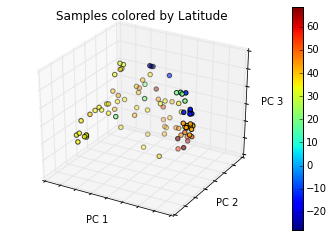

In [62]:
scatter_3d(soil_pcoa_matrix, soil_ordered_latitudes, "Samples colored by Latitude")

If the answer to the above question is "not much", or that there doesn't seem to be much association, you're on the right track.

In the next plot, we'll color the points by the pH of the soil sample they represent. What does this plot tell you about the relationship between the similarity of microbial communities taken from similar and dissimilar pH? 

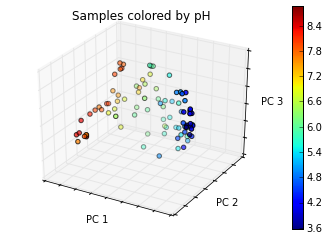

In [63]:
scatter_3d(soil_pcoa_matrix, soil_ordered_pHs, "Samples colored by pH")

Taken together, these plots illustrate that soil microbial community composition is much more closely associated with pH than it is with latitude: the key result that was presented in [Lauber *et al.* (2009)](http://www.ncbi.nlm.nih.gov/pubmed/19502440). 

## PCoA versus PCA: what's the difference?


You may have also heard of a method related to PCoA, called Principal Components Analysis or PCA. There is a key difference between these methods that is important for our useds. PCoA, which is what we've been working with, performs ordination with a distance matrix as input. PCA on the other hand performs ordination with sample by observation count data, such as the OTU tables that we've been working with, as input. It achieves this by computing Euclidean distance (see [here](http://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.euclidean.html#scipy.spatial.distance.euclidean)) between the samples and then running PCoA. So, if your distance metric is Euclidean, PCA and PCoA are the same. In practice however, we want to be able to use distance metrics that work better for studying biological diversity, such as Bray-Curtis or UniFrac. Therefore we typically compute distances with whatever metric we want, and then run PCoA. 


## Are my ordination plots the same? Using Monte Carlo based Procrustes Analysis to compare scatter plots.

A question that come up frequently, often in method comparison, is "are these two ordination plots the same"? This could come up, for example, if you were comparing DNA sequence data from the same samples generated on the 454 Titanium platform with data generated on the Illumina MiSeq platform to see if you would derive the same biological conclusions based on either platform. This was done, for example, in [Additional Figure 1](http://genomebiology.com/2011/12/5/R50/additional) of [*Moving Pictures of the Human Microbiome*](http://genomebiology.com/content/12/5/R50).

Also, as discussed above, arbitrary choices during the ordination process can lead to plots that are flipped relative to each other. For example, looking again the soil data above, colored by pH, does the biological conclusion that you'd derive from these two plots differ? 

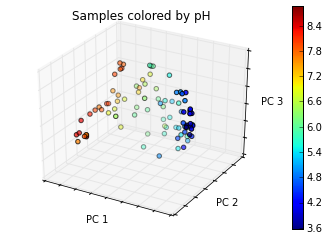

In [64]:
scatter_3d(soil_pcoa_matrix, soil_ordered_pHs, "Samples colored by pH")

In [65]:
flipped_soil_pcoa_matrix = soil_pcoa_matrix * -1

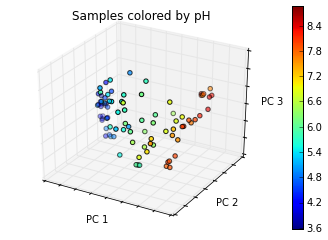

In [66]:
scatter_3d(flipped_soil_pcoa_matrix, soil_ordered_pHs, "Samples colored by pH")

Specifically, what we want to ask when comparing coordinate matrices (such as our ``soil_pcoa_matrix`` and our ``flipped_soil_pcoa_matrix``, is **given a pair of coordinate matrices, is their shape (in two or three dimensions) the same?** The reason we care is that we want to know, **given a pair of ordination plots, would we derive the same biological conclusions regardless of which plot we look at?**

The technique that we use to answer this question is call Procrustes analysis (you can read about the origin of the name [here](http://en.wikipedia.org/wiki/Procrustes)). Procrustes analysis takes two coordinate matrices as input and effectively tries to find the best superimposition of one on top of the other. The transformations that are applies are as follows:

* Translation (the mean of all points is set to 1 on each dimension)
* Scaling (root mean square distance of all points from the origin is 1 on each dimension)
* Rotation (choosing one set of points as the reference, and rotate the other to minimize the sum of squares distance (SSD) between the corresponding points)

The output is a pair of *transformed coordinate matrices*, and an $M^{2}$ statistic which represents how dissimilar the coordinate matrices are to each other (so a small $M^{2}$ means that the coordinate matrices, and the plots, are more similar). 

[Procrustes analysis is implemented in scikit-bio](http://scikit-bio.org/generated/skbio.maths.stats.spatial.procrustes.html), and we'll use that implementation here. In this next cell we'll apply Procrustes analysis to the first three dimensions of the above pair of plots, and then compare the result. We look only at the first three dimensions because those are the dimensions that we're visualizing, and we want to know if we'd come to the same conclusion by looking at the different plots.


In [67]:
from skbio.stats.spatial import procrustes

transformed_matrix1, transformed_matrix2, m2 = procrustes(soil_pcoa_matrix[:3].T, flipped_soil_pcoa_matrix[:3].T)
transformed_matrix1 = transformed_matrix1.T
transformed_matrix2 = transformed_matrix2.T

The $M^{2}$ value that we can back is:

In [68]:
print m2

5.36542092801e-32


And the resulting plots are as follows. Compare these to the plots above - what's different?

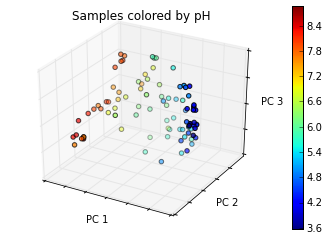

In [69]:
scatter_3d(transformed_matrix1, soil_ordered_pHs, "Samples colored by pH")

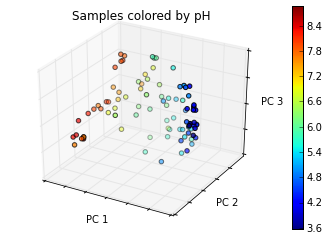

In [70]:
scatter_3d(transformed_matrix2, soil_ordered_pHs, "Samples colored by pH")

So this looks pretty good, right? The plots generated from the transformed coordinate matrices look identical to each other. 

What do you think about the $M^{2}$ value though? It looks low, which we know is good, but there is an important question to answer here: **is the observed $M^{2}$ lower than we would expect to see if these plots would lead us to different biological conclusions?** If you haven't looked at a lot of $M^{2}$ values, you don't really know the answer to that. What we need to know to judge whether this is a *good* $M^{2}$ value is what the distribution of $M^{2}$ values is for plots that don't map on to each other well. We can find that distribution using a Monte Carlo test, similar to what we looked at when [computing the significance of pairwise alignments](../algorithms/2-database-searching.ipynb#Is-my-alignment-"good"?-Determining-whether-an-alignment-is-statistically-significant.).

One way to be nearly guaranteed that a pair of plots won't align with each other is to shuffle the labels of the points in one of the plots, and leave them untouched in the other. Here I'll define a function which, given a distance matrix, returns another distance matrix with the sample labels shuffled. 

In [71]:
from random import shuffle 

def shuffle_distance_matrix(dm):
    shuffled_ids = list(soil_dm.ids)

    shuffle(shuffled_ids)
    shuffled_data = zeros(soil_dm.shape)

    for i, sid1 in enumerate(shuffled_ids):
        for j, sid2 in enumerate(shuffled_ids):
            shuffled_data[i][j] = soil_dm[sid1,sid2]
    result = DistanceMatrix(shuffled_data, shuffled_ids)
    return result

We can then create a random version of our distance matrix, compute PCoA on it, and just for fun, visualize it. Run this next cell a few times and notice how the plot changes.

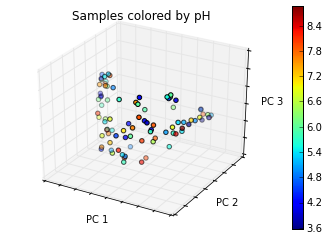

In [72]:
random_dm = shuffle_distance_matrix(soil_dm)

random_pcoa = PCoA(random_dm)
random_pcoa_result = random_pcoa.scores()
random_pcoa_matrix = random_pcoa_result.site.T
random_pcoa_ids = random_pcoa_result.site_ids
random_ordered_pHs = [soil_sample_md['pH'][sid] for sid in random_pcoa_ids]

scatter_3d(random_pcoa_matrix, soil_ordered_pHs, "Samples colored by pH")

We can now compare the plots with Procrustes analysis, and inspect the plots and the $M^{2}$ value. What do you think: would you derive the same conclusion from this pair of plots?

In [73]:
transformed_matrix1, transformed_matrix2, m2 = procrustes(soil_pcoa_matrix[:3].T, random_pcoa_matrix[:3].T)
transformed_matrix1 = transformed_matrix1.T
transformed_matrix2 = transformed_matrix2.T
print m2

0.97275019465


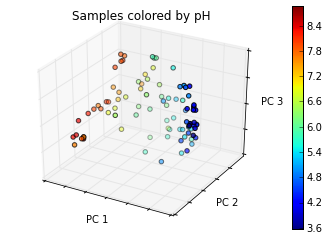

In [74]:
scatter_3d(transformed_matrix1, soil_ordered_pHs, "Samples colored by pH")

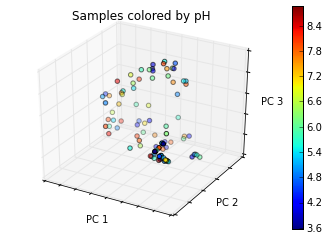

In [75]:
scatter_3d(transformed_matrix2, soil_ordered_pHs, "Samples colored by pH")

So now we know what an $M^{2}$ value looks like from plots that are essentially the same (our ``soil_pcoa_matrix`` and ``flipped_soil_pcoa_matrix``; we'll call this our *actual* $M^{2}$) and what an $M^{2}$ value looks like from plots that are completely different (our ``soil_pcoa_matrix`` and ``random_pcoa_matrix``). This is really useful: we can see that our actual $M^{2}$ is much less than the one from our randomly generated distance matrix. But, what if we just got unlucky with our randomization of the distance matrix. What we're really after here is a test of a hypothesis. Specifically, we have a null hypothesis and an alternative hypothesis:

$H_{0}$: The two ordination matrices are not illustrating the same pattern.
$H_{a}$: The two ordination matrices are illustrating the same pattern.

When you do this type of comparison, what you really need to do is compute $n$ random distance matrices, run PCoA on each, and then compute the $M^{2}$ value for each. This then gives us a distribution of $M^{2}$ values that we see when we know that $H_{0}$ is true. From that information, we can then compute, as a fraction, **how often we observe an $M^{2}$ at least as low as our actual $M^{2}$**. If this fraction is low, we can reject the null hypothesis on the assumption that the $M^{2}$ we observed is unlikely to have been drawn from that distribution. If the fraction is high, we fail to reject the null hypothesis, because the evidence that we have isn't sufficient to support $H_{a}$. We'll call this fraction $p$, and we'd compute it as follows:

$p = \frac{count\ random\ M^{2} <=\ actual\ M^{2}}{n}$

This should sound familiar: it's the defintion of a p-value where we're using this fraction as probability that our actual $M^{2}$ comes from our randomly generated distribution. The might seem different than how you compute p-values in your undergraduate statistics class because this is an **empirically derived p-value**. Rather than relying on some idea of what the distribution of $M^{2}$ values looks like under the null hypothesis (e.g., the table in the back of a textbook), we compute that distribution with data where we know that the null hypothesis is true (our random distance matrices). We can define a value $\alpha$ (often $\alpha = 0.05$) and say that if $p <= \alpha$ that we'll reject $H_{0}$ in favor of $H_{a}$. 

Let's try this out. First, let's get our actual $M^{2}$ again. Here we don't actually care about storing the transformed coordinate matrices, so we're just storing them in a variable named `_` (a python convention that is usually interpreted as *this function gives me back something that I'm not going to use*). 


In [76]:
_, _, actual_m2 = procrustes(soil_pcoa_matrix.T, flipped_soil_pcoa_matrix.T)
print actual_m2

3.7709749772e-30


Now we'll generate `n` random distance matrices, compute PCoA for each, and compare that PCoA coordinate matrix to our actual ``soil_pcoa_matrix``. We'll keep a list of the resulting $M^{2}$ values as we go - this will be the distribution that we compare our actual $M^{2}$ to.

In [77]:
trial_m2 = []
n = 99

for i in range(n):
    shuffle_dm = shuffle_distance_matrix(soil_dm)
    random_pcoa = PCoA(shuffle_dm)
    random_pcoa_result = random_pcoa.scores()
    random_pcoa_matrix = random_pcoa_result.site.T

    _, _, current_m2 = procrustes(soil_pcoa_matrix[:3].T, random_pcoa_matrix[:3].T)
    trial_m2.append(current_m2)

We can now look at the resulting list, and plot the distribution as a histogram.

In [78]:
print trial_m2

[0.95814077202261694, 0.98893486105117878, 0.9819590918347636, 0.98185382404814936, 0.99519515310537832, 0.99101124345134051, 0.98026590883205444, 0.97447589015117297, 0.98813438398077458, 0.98379083517105004, 0.97890099447934975, 0.98180427471655096, 0.96023192611230312, 0.98845148556616469, 0.99036747162801086, 0.98427879287043174, 0.99068903156858967, 0.97442671154028759, 0.98734921698218003, 0.96655178720743162, 0.96922289589578769, 0.98662648840067568, 0.97865084238422828, 0.96704398678557046, 0.98108053204335144, 0.98074499836602258, 0.97494503572668956, 0.97612159118156161, 0.95914807565967619, 0.97627688624289499, 0.9895338957368004, 0.97598397896561895, 0.98842799034118378, 0.97212822801758514, 0.98812414808198568, 0.97620196308041585, 0.97674512829899118, 0.99546370066465439, 0.98397549239362281, 0.96188210870572766, 0.99453616261438182, 0.99496012114118315, 0.98479027875941227, 0.98051769518705112, 0.97703717079870112, 0.98227071946902034, 0.98654829627185858, 0.982151244187

(0, 1.0)

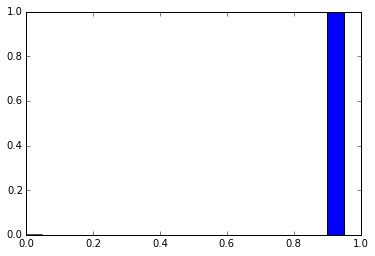

In [79]:
from pylab import hist, xlim
from numpy import arange
hist(trial_m2, bins=arange(0,1,0.05))
xlim(0,1.0)

What do you think? How does our actual $M^{2}$ compare to this distribution? We can quantify this as follows.

In [80]:
count_better = 0
for e in trial_m2:
    if e < actual_m2:
        count_better += 1
print "count better: %d" % count_better
print "fraction better: %f" % (count_better + 1 / len(trial_m2))

count better: 0
fraction better: 0.000000


Finally, you might be tempted to report this result as $p=0.0$, but that's not exactly accurate. You have to think about how many significant digits you have here (or alternatively, what the maximum precision of your p-value is). In this case, you've performed 100 tests, so you have only two significant digits. You therefore should report this p-value as $p < 0.01$.

This type of test, where we compute the distribution of the expected test statistic values under the null hypothesis is called a Monte Carlo test, and these are very useful in bioinforamtics where we often don't know what that distribution looks like (maybe because we suspect that the assumptions made by some test, such as the requirement that two distributions compared with a t-test, do not hold). Pick your favorite statistical test (maybe [Spearman correlation](http://docs.scipy.org/doc/scipy-0.7.x/reference/generated/scipy.stats.spearmanr.html) or the [two-sample t-test](http://docs.scipy.org/doc/scipy-0.7.x/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind)). How would you compute this background distribution for that test? Try coding it up as an exercise, using a pre-existing implementation of the actual test like the ones I link to in the previous sentence.

If you're interested in learning more about the topics presented in this chapter, I recommend [Measuring Biological Diversity](http://www.amazon.com/Measuring-Biological-Diversity-Anne-Magurran/dp/0632056339) by Anne E. Magurran, and the [QIIME tutorials](http://qiime.org/tutorials/index.html). The [QIIME software package](http://www.qiime.org) is designed for performing the types of analyses described in this chapter. 

## Acknowledgements

The majority of content in this section is based on knowledge that I gained through years of working with [Rob Knight](https://knightlab.colorado.edu/) and the rest of the [QIIME](http://qiime.org/) [development group](https://github.com/biocore/qiime/graphs/contributors). Thanks everyone, I'm looking forward to many more years of productive, fun and exciting work together!